## generate data

In [1]:
import os, shutil
import random
import math

import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as tnf
import torch.distributions as td

import sklearn.linear_model
import sklearn.preprocessing

import copy
from pprint import pprint
import time, datetime

# import pyro
# import pyro.distributions as dist
# from pyro.nn import PyroModule, PyroSample

# import loss_landscapes
# import loss_landscapes.metrics


# from ax.service.ax_client import AxClient
# from ax.service.utils.instantiation import ObjectiveProperties
# from ax.modelbridge.generation_strategy import GenerationStrategy, GenerationStep
# from ax.modelbridge.registry import Models

# from ax.utils.notebook.plotting import render
# import plotly.io as pio
# pio.renderers.default = "png"

# import cooper

In [2]:
# %matplotlib ipympl
# %matplotlib inline
%load_ext line_profiler

In [3]:
pltparams = {
    'legend.fontsize': 'x-large',
    'axes.labelsize': 'x-large',
    'axes.titlesize': 'x-large',
    'xtick.labelsize': 'x-large',
    'ytick.labelsize': 'x-large',
    'figure.titlesize': 'x-large',
    'savefig.dpi': 100,
}
plt.rcParams.update(pltparams)

# sns.set(font_scale = 1.2)

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 
# data_path = "/mnt/beegfs/projects/power-conv/data"
random_seed=2022
saved_model_path = "/home/phan/Workspace/saved_model"

In [5]:
def set_random_seed(random_seed):
    np.random.seed(random_seed)
    torch.manual_seed(random_seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(random_seed)
        
def set_all_random_seeds(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

# random_seed=2022
# set_all_random_seeds(random_seed)

In [6]:
# os.listdir(data_path)

In [7]:
# !tar -xzf /mnt/beegfs/projects/power-conv/data/xls.tar.gz --directory /mnt/beegfs/projects/power-conv/data/
# !tar -czvf /mnt/beegfs/projects/power-conv/data/csv.tar.gz /mnt/beegfs/projects/power-conv/data/csv

https://blog.tensorflow.org/2018/10/industrial-ai-bhges-physics-based.html

The phenomenon of fatigue crack propagation can be modeled with the Paris law. Paris law relates the rate of crack growth $\left(da/dN\right)$ to the stress intensity factor  $\left(\Delta K = \Delta\sigma\sqrt{\pi a}\right)$ through the equation below:

$\frac{da}{dN}=C(\Delta\sigma\sqrt{\pi a})^m$
\begin{align}
ln\ \frac {da}{dN} = ln\ C + m\ ln\ (\Delta\sigma\sqrt{\pi a}) = ln\ C + m\ (ln \Delta \sigma + 0.5 ln\ \pi + 0.5 ln\ a)
\end{align}

Where $a$ is the crack length, $N$ is the number of loading cycles, $\sigma$ is the stress, and $C, m$ are material properties.
Integrating the Paris law for a specific geometry and loading configuration, we arrive at the analytical formulation for the size of a crack as a function of the loading cycle as shown below:

$a(N) = \left[ N  C \left(1-\frac{m}{2}\right) \left(\Delta\sigma\sqrt{\pi}\right)^m + a_0^{1-\frac{m}{2}}\right]^\frac{2}{2-m}$

where $a_0$ is the initial crack length.
The parameters $C$ and $m$ need to be calibrated for each application with crack length $(a)$ vs loading cycles $(N)$ data

\begin{align}
\int_{N_0}^{N_f} dN = \int_{a_0}^{a_f} \frac {da} {C ( \sigma \sqrt{\pi a})^m} 
=> N |_{N_0}^{N_f} = \frac 1 {C (\sigma \sqrt \pi)^m} \int_{a_0}^{a_f} a^{-m/2} da 
=> N_f - N_0 = \frac 1 {C (\sigma \sqrt \pi)^m} \frac 1 {1 - m/2} a^{1-m/2} |_{a_0}^{a_f}
=> N_f - N_0 = \frac 1 {C (\sigma \sqrt \pi)^m} \frac 1 {1 - m/2} (a_f^{1 - m/2} - a_0^{1 - m/2})
\end{align}

In [8]:
def paris_law(a, C, m, dsigma):
    righthandside = C * dsigma**m * (np.pi * a)**(m/2)
    return righthandside

In [9]:
def cycle_to_crack(N, C, m, a0, dsigma):
    a_N = ( N*C*(1 - m/2) * (dsigma*np.pi**0.5)**m + a0**(1 - m/2) )**(2/(2 - m))
    return a_N


Text(0, 0.5, 'crack length')

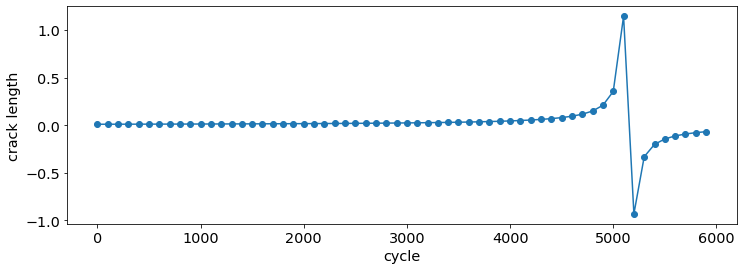

In [10]:
paris_C = np.exp(-23.5)
paris_m = 4.
paris_dsigma = 75.
paris_a0 = 0.01

N = np.arange(0., 6000., 100)
plt.figure(figsize=(12,4))
plt.plot(N, cycle_to_crack(N, paris_C, paris_m, paris_a0, paris_dsigma), marker="o")
plt.xlabel("cycle")
plt.ylabel("crack length")

/tmp/ipykernel_15612/2927881142.py:2: RuntimeWarning: invalid value encountered in log
  plt.plot(N[:], np.log(cycle_to_crack(N, paris_C, paris_m, paris_a0, paris_dsigma)), marker="o")


Text(0, 0.5, 'crack length')

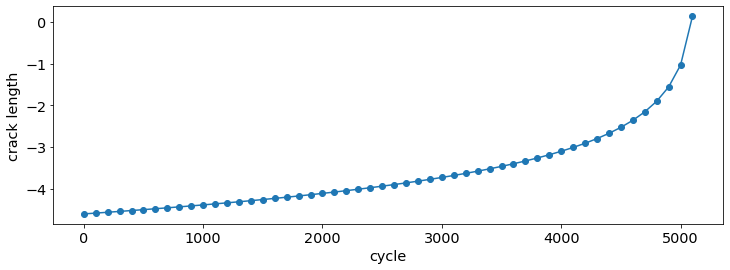

In [11]:
plt.figure(figsize=(12,4))
plt.plot(N[:], np.log(cycle_to_crack(N, paris_C, paris_m, paris_a0, paris_dsigma)), marker="o")
plt.xlabel("cycle")
plt.ylabel("crack length")

Text(0, 0.5, 'crack length')

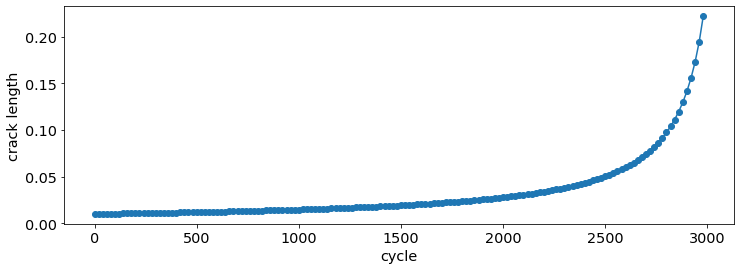

In [12]:
paris_C = np.exp(-23)
paris_m = 4.
paris_dsigma = 75.
paris_a0 = 0.01

N = np.arange(0., 3000., 20)
a = cycle_to_crack(N, paris_C, paris_m, paris_a0, paris_dsigma)
plt.figure(figsize=(12,4))
plt.plot(N, a, marker="o")
plt.xlabel("cycle")
plt.ylabel("crack length")

Text(0, 0.5, 'crack length')

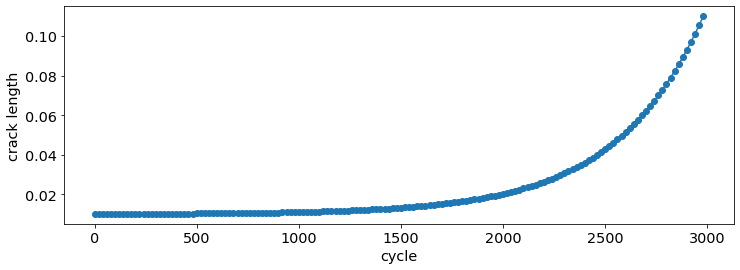

In [13]:
def power_func(offset, multi, powerbase, x):
    return offset + multi * powerbase**x


y = power_func(0.01, 1e-4, 1e3, N/max(N))
plt.figure(figsize=(12,4))
plt.plot(N, y, marker="o")
plt.xlabel("cycle")
plt.ylabel("crack length")

Text(0, 0.5, 'crack length')

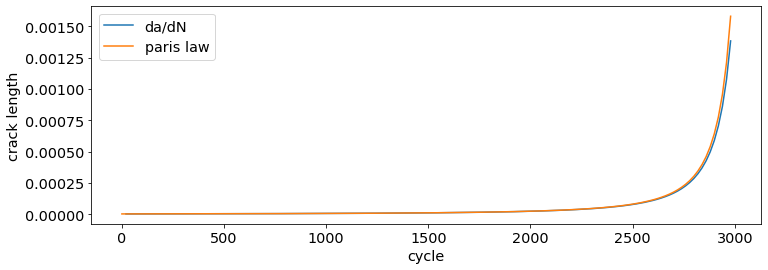

In [14]:
# dadN = (a[1:] - a[:-1]) / (N[1:] - N[:-1])
dadN = np.diff(a) / np.diff(N)
# print(np.mean(dadN), np.min(dadN), np.max(dadN))
parislaw_rightside = paris_law(a, paris_C, paris_m, paris_dsigma)

plt.figure(figsize=(12,4))
plt.plot(N[1:], dadN, label="da/dN")
plt.plot(N, parislaw_rightside, label="paris law")
# plt.ylim(0.001, 0.0015)
plt.legend()
plt.xlabel("cycle")
plt.ylabel("crack length")

Text(0, 0.5, 'crack length')

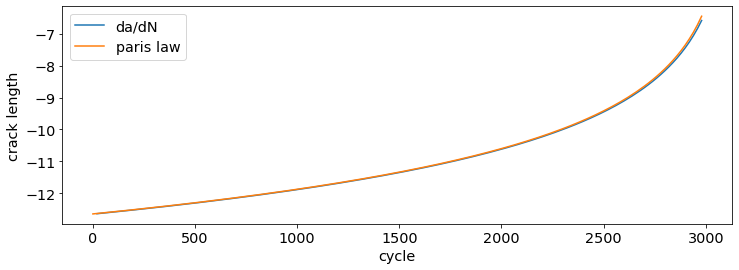

In [15]:
plt.figure(figsize=(12,4))
plt.plot(N[1:], np.log(dadN), label="da/dN")
plt.plot(N, np.log(parislaw_rightside), label="paris law")
plt.legend()
plt.xlabel("cycle")
plt.ylabel("crack length")

## preprocess

In [16]:
def generate_data(C, m, a0, dsigma, trainsize, startN=0., endN=1000., stepN=10, noise_strength=1e-3, random_seed=None):
    N = np.arange(startN, endN, stepN)
    true_target = cycle_to_crack(N, C, m, a0, dsigma)
    if random_seed: np.random.seed(random_seed)

    noise = np.random.normal(0, 1, N.shape[0]) * noise_strength
#     print(np.max(true_target) - np.min(true_target), np.mean(true_target), np.std(true_target))
    noisy_target = true_target + noise
    
    trainidx = int(N.shape[0] * trainsize)
    
    trainx = N[:trainidx]
    testx = N[trainidx:]
    trainy = noisy_target[:trainidx]
    testy = noisy_target[trainidx:]
    
    return trainx, trainy, testx, testy

def scale_data(original_data):
    scaler = sklearn.preprocessing.MinMaxScaler()
    scaled = scaler.fit_transform(original_data)

    return scaler, scaled.squeeze()

In [17]:
paris_C = np.exp(-23)
paris_m = 4.
paris_dsigma = 75.
paris_a0 = 0.01

train_input, train_target, test_input, test_target = generate_data(paris_C, paris_m, paris_a0, paris_dsigma, trainsize=0.8, 
    startN=0., endN=3000., stepN=20, noise_strength=1e-3, random_seed=random_seed)


Text(0, 0.5, 'crack length')

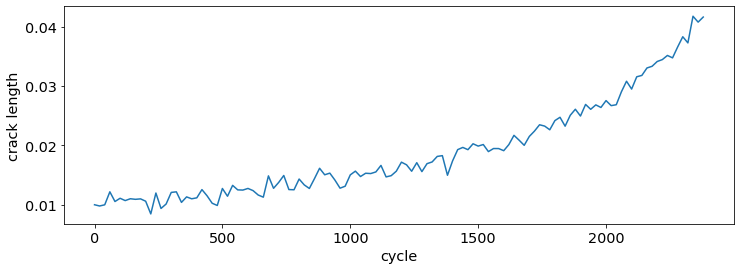

In [18]:
plt.figure(figsize=(12, 4))
plt.plot(train_input, train_target)
plt.xlabel("cycle")
plt.ylabel("crack length")

Text(0, 0.5, 'crack length')

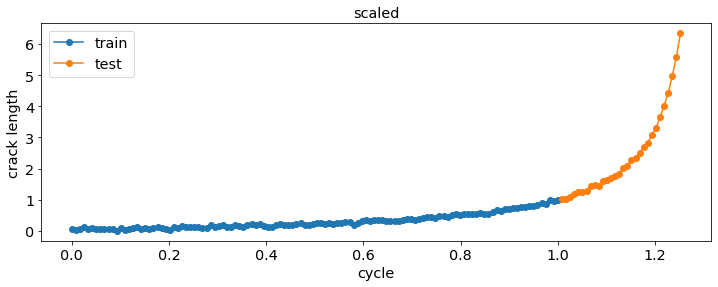

In [19]:
train_xscaler, train_xscaled = scale_data(train_input.reshape(-1, 1))
train_yscaler, train_yscaled = scale_data(train_target.reshape(-1, 1))

test_xscaled = train_xscaler.transform(test_input.reshape(-1, 1)).squeeze()
test_yscaled = train_yscaler.transform(test_target.reshape(-1, 1)).squeeze()

plt.figure(figsize=(12, 4))
plt.plot(train_xscaled, train_yscaled, marker="o", label="train")
plt.plot(test_xscaled, test_yscaled, marker="o", label="test")
plt.legend()
plt.title("scaled")
plt.xlabel("cycle")
plt.ylabel("crack length")

Text(0, 0.5, 'crack length')

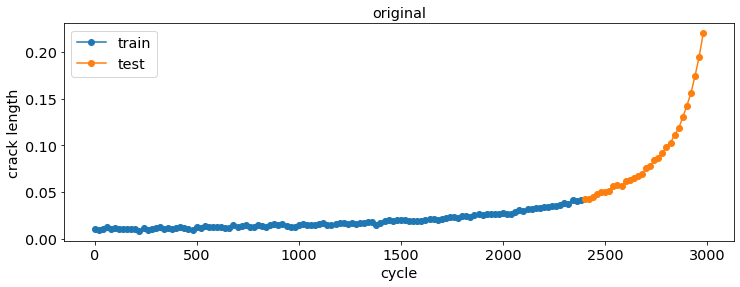

In [20]:
plt.figure(figsize=(12, 4))
plt.plot(train_input, train_target, marker="o", label="train")
plt.plot(test_input, test_target, marker="o", label="test")
plt.legend()
plt.title("original")
plt.xlabel("cycle")
plt.ylabel("crack length")

Text(0, 0.5, 'crack length')

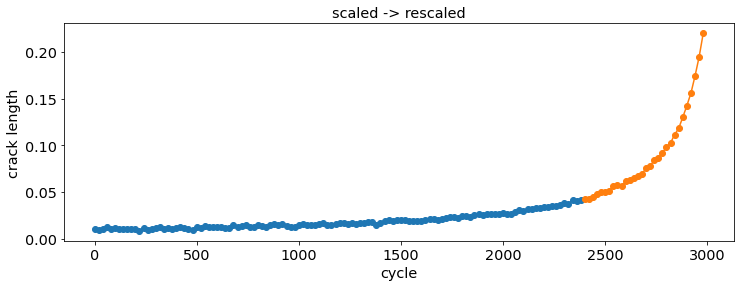

In [21]:
train_xrescaled = train_xscaler.inverse_transform(train_xscaled.reshape(-1, 1)).squeeze()
train_yrescaled = train_yscaler.inverse_transform(train_yscaled.reshape(-1, 1)).squeeze()

test_xrescaled = train_xscaler.inverse_transform(test_xscaled.reshape(-1, 1)).squeeze()
test_yrescaled = train_yscaler.inverse_transform(test_yscaled.reshape(-1, 1)).squeeze()

plt.figure(figsize=(12,4))
plt.plot(train_xrescaled, train_yrescaled, marker="o")
plt.plot(test_xrescaled, test_yrescaled, marker="o")
plt.title("scaled -> rescaled")
plt.xlabel("cycle")
plt.ylabel("crack length")

## check preprocessing

In [22]:
def plot_twinx(x, y1, label1, y2, label2, y3=None, label3=None, title=None):
    fig, ax1 = plt.subplots(figsize=(8,4))
    ax2 = ax1.twinx()
    ax1.set_xlabel("cycle")

    plot1 = ax1.plot(x, y1, label=label1, color="blue") #, marker="o"
    ax1.set_ylabel(label1, color="blue")

    plot2 = ax2.plot(x, y2, label=label2, color="orange")#, marker="o"
    ax2.set_ylabel(label2, color="orange")
    
    if y3 is not None:
        ax2.plot(x, y3, label=label3, color="green")#, marker="o"
        ax1.plot([], [], label=label3, color="green")
    
#     hack for legend
    ax1.plot([], [], label=label2, color="orange")#, marker="o"
    ax1.legend()
    
    if title: ax1.set_title(title)
    
    return fig

Text(0, 0.5, 'crack length')

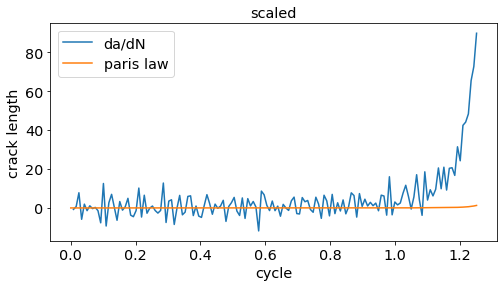

In [23]:
all_xscaled = np.concatenate([train_xscaled, test_xscaled])
all_yscaled = np.concatenate([train_yscaled, test_yscaled])

dadN_scaled = np.diff(all_yscaled) / np.diff(all_xscaled)
parislaw_scaled = paris_law(all_yscaled, paris_C, paris_m, paris_dsigma)

plt.figure(figsize=(8,4))
plt.plot(all_xscaled[1:], dadN_scaled, label="da/dN")
plt.plot(all_xscaled, parislaw_scaled, label="paris law")
plt.legend()
plt.title("scaled")
plt.xlabel("cycle")
plt.ylabel("crack length")

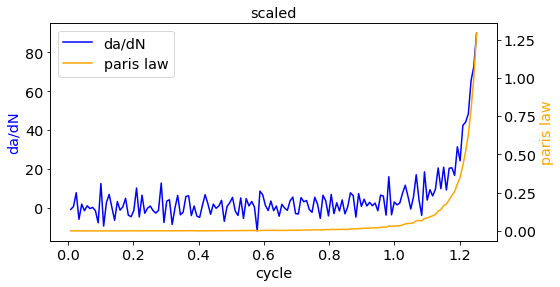

In [24]:
fig = plot_twinx(all_xscaled[1:], dadN_scaled, "da/dN", parislaw_scaled[1:], "paris law", title="scaled")

Text(0, 0.5, 'crack length')

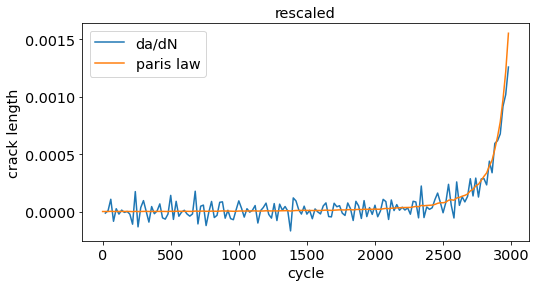

In [25]:
all_xrescaled = train_xscaler.inverse_transform(all_xscaled.reshape(-1, 1)).squeeze()
all_yrescaled = train_yscaler.inverse_transform(all_yscaled.reshape(-1, 1)).squeeze()


dadN_rescaled = np.diff(all_yrescaled) / np.diff(all_xrescaled)
parislaw_rescaled = paris_law(all_yrescaled, paris_C, paris_m, paris_dsigma)

plt.figure(figsize=(8,4))
plt.plot(all_xrescaled[1:], dadN_rescaled, label="da/dN", )
plt.plot(all_xrescaled, parislaw_rescaled, label="paris law")
plt.legend()
plt.title("rescaled")
plt.xlabel("cycle")
plt.ylabel("crack length")
# print(parislaw_rescaled)


Text(0, 0.5, 'crack length')

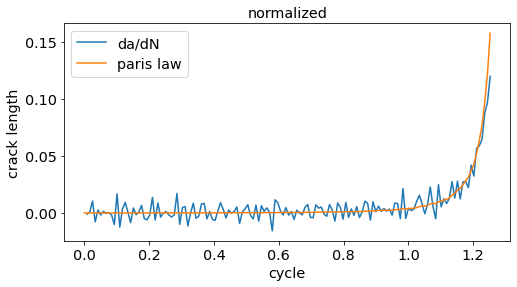

In [26]:
plt.figure(figsize=(8,4))
plt.plot(all_xscaled[1:], dadN_scaled/sum(dadN_scaled), label="da/dN")
plt.plot(all_xscaled, parislaw_scaled/sum(parislaw_scaled), label="paris law")
plt.legend()
plt.title("normalized")
plt.xlabel("cycle")
plt.ylabel("crack length")

Text(0, 0.5, 'crack length')

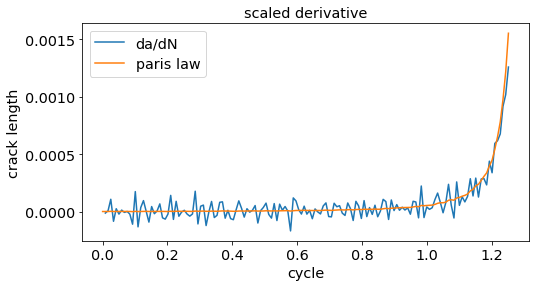

In [27]:
plt.figure(figsize=(8,4))
plt.plot(all_xscaled[1:], dadN_scaled*(max(train_target) - min(train_target))/(max(train_input) - min(train_input)), label="da/dN")
plt.plot(all_xscaled, parislaw_rescaled, label="paris law")
plt.legend()
plt.title("scaled derivative")
plt.xlabel("cycle")
plt.ylabel("crack length")
# plt.xlim(0,1)

In [28]:
totensor = lambda array:torch.tensor(array).reshape(-1, 1).float()
# train_xtensor = totensor(train_xscaled)
# train_ytensor = totensor(train_yscaled)
# test_xtensor = totensor(test_xscaled)
# test_ytensor = totensor(test_yscaled)

train_xtensor = totensor(train_input)
train_ytensor = totensor(train_target)
test_xtensor = totensor(test_input)
test_ytensor = totensor(test_target)

print(train_xtensor.shape, train_ytensor.shape, test_xtensor.shape, test_ytensor.shape)

torch.Size([120, 1]) torch.Size([120, 1]) torch.Size([30, 1]) torch.Size([30, 1])


In [29]:
tensor_to_array = lambda tensor: tensor.detach().cpu().numpy().squeeze()
array_to_tensor = lambda array: torch.tensor(array, device=device)

class TorchMinMaxScaler:
    def fit(self, data):
        self.min = torch.min(data)
        self.max = torch.max(data)
        return self
        
    def forward(self, data):
        scaled = (data - self.min) / (self.max - self.min)
        return scaled
    
    def inverse(self, data):
        rescaled = data * (self.max - self.min) + self.min
        return rescaled

In [30]:
train_xscaler_torch = TorchMinMaxScaler().fit(train_xtensor)
train_yscaler_torch = TorchMinMaxScaler().fit(train_ytensor)

train_xtensor = train_xscaler_torch.forward(train_xtensor)
train_ytensor = train_yscaler_torch.forward(train_ytensor)
test_xtensor = train_xscaler_torch.forward(test_xtensor)
test_ytensor = train_yscaler_torch.forward(test_ytensor)

print(train_xtensor.shape, train_ytensor.shape, test_xtensor.shape, test_ytensor.shape)


torch.Size([120, 1]) torch.Size([120, 1]) torch.Size([30, 1]) torch.Size([30, 1])


Text(0, 0.5, 'crack length')

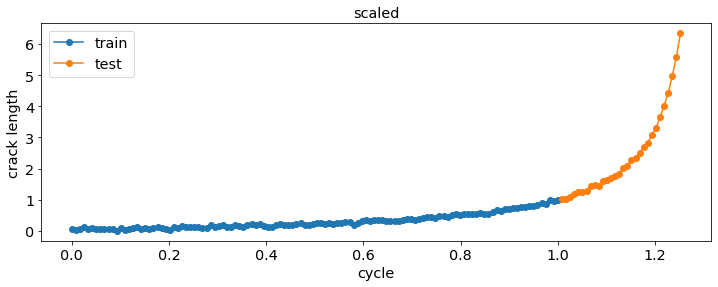

In [31]:
plt.figure(figsize=(12, 4))
plt.plot(train_xtensor, train_ytensor, marker="o", label="train")
plt.plot(test_xtensor, test_ytensor, marker="o", label="test")
plt.legend()
plt.title("scaled")
plt.xlabel("cycle")
plt.ylabel("crack length")

Text(0, 0.5, 'crack length')

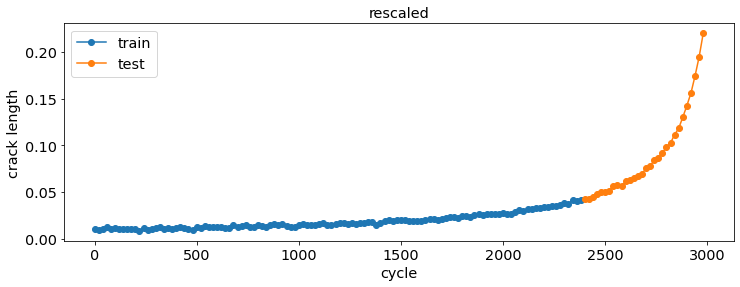

In [32]:
plt.figure(figsize=(12, 4))
plt.plot(train_xscaler_torch.inverse(train_xtensor), train_yscaler_torch.inverse(train_ytensor), marker="o", label="train")
plt.plot(train_xscaler_torch.inverse(test_xtensor), train_yscaler_torch.inverse(test_ytensor), marker="o", label="test")
plt.legend()
plt.title("rescaled")
plt.xlabel("cycle")
plt.ylabel("crack length")

In [33]:
def plot_target_prediction(traininput, traintarget, trainprediction, testinput, testtarget, testprediction=None,
    title=None, figsize=(12, 4), marker="o"):
    
    fig = plt.figure(figsize=figsize)
    plt.plot(traininput, traintarget, label="train target", marker=marker)
    plt.plot(testinput, testtarget, label="test target", marker=marker)
    plt.plot(traininput, trainprediction, label="train prediction", marker=marker)
    
    if testprediction is not None:
        plt.plot(testinput, testprediction, marker=marker, label="test prediction")
    # plt.ylim(-0.01, 0.02)
        
    if title: plt.title(title)    
    
    plt.legend()
    plt.xlabel("cycle")
    plt.ylabel("crack length")

    return fig

## Data tensor

torch.Size([120, 1]) torch.Size([120, 1]) torch.Size([30, 1]) torch.Size([30, 1])


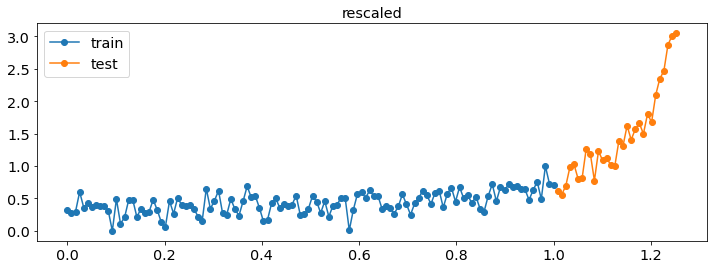

In [34]:
def generate_data_tensor():
    paris_C = np.exp(-23)
    paris_m = 4.
    paris_dsigma = 75.
    paris_a0 = 0.01

    train_input, train_target, test_input, test_target = generate_data(paris_C, paris_m, paris_a0, paris_dsigma, trainsize=0.8, 
        startN=0., endN=3000., stepN=20, noise_strength=1e-2, random_seed=random_seed)

    # train_xtensor = totensor(train_input)
    # train_ytensor = totensor(train_target)
    # test_xtensor = totensor(test_input)
    # test_ytensor = totensor(test_target)

    # print(train_xtensor.shape, train_ytensor.shape, test_xtensor.shape, test_ytensor.shape)

    train_xscaler_torch = TorchMinMaxScaler().fit(totensor(train_input))
    train_yscaler_torch = TorchMinMaxScaler().fit(totensor(train_target))

    train_xtensor = train_xscaler_torch.forward(totensor(train_input))
    train_ytensor = train_yscaler_torch.forward(totensor(train_target))
    test_xtensor = train_xscaler_torch.forward(totensor(test_input))
    test_ytensor = train_yscaler_torch.forward(totensor(test_target))

    print(train_xtensor.shape, train_ytensor.shape, test_xtensor.shape, test_ytensor.shape)
    
    fig = plt.figure(figsize=(12, 4))
    # plt.plot(train_xscaler_torch.inverse(train_xtensor), train_yscaler_torch.inverse(train_ytensor), marker="o", label="train")
    # plt.plot(train_xscaler_torch.inverse(test_xtensor), train_yscaler_torch.inverse(test_ytensor), marker="o", label="test")
    plt.plot(train_xtensor, train_ytensor, marker="o", label="train")
    plt.plot(test_xtensor, test_ytensor, marker="o", label="test")
    plt.legend()
    plt.title("rescaled")
    
    return train_xtensor, train_ytensor, test_xtensor, test_ytensor, fig

train_xtensor, train_ytensor, test_xtensor, test_ytensor, fig = generate_data_tensor()

## regular neural network

In [35]:
class FullyConnected(nn.Module):
    "Defines a fully connected neural network"
    def __init__(self, layer_size, activation=nn.ReLU):
        super().__init__()
#         activation = nn.Tanh
#         activation = nn.ReLU
        layers = []
        
        for i in range(len(layer_size) - 2):
            layers.append(nn.Linear(layer_size[i], layer_size[i+1]))
            layers.append(activation())            
        
        self.layers = nn.Sequential(
            *layers,
            nn.Linear(layer_size[-2], layer_size[-1])
        )
        
    def forward(self, inpt):
        outpt = inpt
        for layer in self.layers:
            outpt = layer(outpt)
        
        # enforce positive value by model the ln and take exp
#         return torch.exp(outpt)
        return outpt
    
model = FullyConnected([1, 16, 8, 1])
model(torch.rand(2, 1)).shape

torch.Size([2, 1])

In [36]:
class FullyConnectedExp(nn.Module):
    "Defines a fully connected neural network"
    def __init__(self, layer_size, activation=nn.ReLU):
        super().__init__()
#         activation = nn.Tanh
#         activation = nn.ReLU
        layers = []
        
        for i in range(len(layer_size) - 2):
            layers.append(nn.Linear(layer_size[i], layer_size[i+1]))
            layers.append(activation())            
        
        self.layers = nn.Sequential(
            *layers,
            nn.Linear(layer_size[-2], layer_size[-1])
        )
        
    def forward(self, inpt):
        outpt = inpt
        for layer in self.layers:
            outpt = layer(outpt)
        
        # enforce positive value by model the ln and take exp
        return torch.exp(outpt)
#         return outpt

model = FullyConnectedExp([1, 16, 8, 1])
model(torch.rand(2, 1)).shape

torch.Size([2, 1])

In [37]:
def predict_model(model, inputdata, targetdata=None):
    model.eval()
    loss = None
    
    with torch.no_grad():
        outputdata = model(inputdata.to(device))
#         predictions = outputdata
        if targetdata is not None:
            loss = tnf.mse_loss(outputdata, targetdata.to(device)).detach().item()
        
    return outputdata.detach().cpu(), loss

## train regular neural network

In [38]:
def train_model(model, traininput, trainlabel, epochs=5):
#     optim = torch.optim.Adam(model.parameters(), lr=1e-1, weight_decay=1e-6)
    optim = torch.optim.Adam(model.parameters(), lr=1e-1, weight_decay=1e-6)
    traininput = traininput.to(device)
    trainlabel = trainlabel.to(device)
#     scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, mode='min', 
#         factor=0.1, patience=10, threshold_mode="rel", threshold=1e-2, verbose=True)

    losses = []
    model.train()
    
    for epoch in range(epochs):
        optim.zero_grad()
        outputdata = model(traininput)
#         predictions = outputdata[0]
#         print(f"{predictions.shape=}, {trainlabel.shape=}")
        loss = tnf.mse_loss(outputdata, trainlabel)
        
        loss.backward()
        optim.step()        
#         scheduler.step(loss)
        losses.append(loss.detach().item())
        
        if epochs < 10 or epoch % (epochs//10) == 0:
            print(f"Epoch {epoch+1} loss = {loss}")
            
    return losses

Epoch 1 loss = 1.0228309631347656
Epoch 11 loss = 0.2936426103115082
Epoch 21 loss = 0.21955536305904388
Epoch 31 loss = 0.11424847692251205
Epoch 41 loss = 0.07410994172096252
Epoch 51 loss = 0.04133971035480499
Epoch 61 loss = 0.030890585854649544
Epoch 71 loss = 0.025719502940773964
Epoch 81 loss = 0.029265213757753372
Epoch 91 loss = 0.024397574365139008


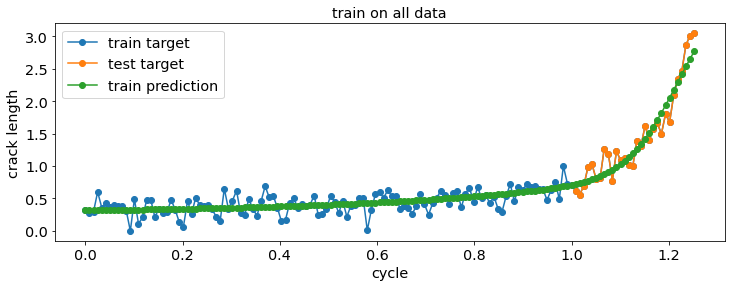

In [39]:
model = FullyConnected([1, 4, 4, 1], activation=nn.Tanh).to(device)
# model = nn.Linear(1,1).to(device)
losses = train_model(model, torch.cat([train_xtensor, test_xtensor]), torch.cat([train_ytensor, test_ytensor]), epochs=100)

train_predictions, _ = predict_model(model, torch.cat([train_xtensor, test_xtensor]))
# test_predictions, test_loss = predict_model(model, test_xtensor, test_ytensor)
# print(train_predictions.shape, test_predictions.shape)

fig = plot_target_prediction(torch.cat([train_xtensor, test_xtensor]), torch.cat([train_ytensor, test_ytensor]), train_predictions, 
                       test_xtensor, test_ytensor, title="train on all data")
# print(f"{test_loss = }")



Epoch 1 loss = 0.38936862349510193
Epoch 11 loss = 0.15441447496414185
Epoch 21 loss = 0.06558854132890701
Epoch 31 loss = 0.056104857474565506
Epoch 41 loss = 0.033344052731990814
Epoch 51 loss = 0.026130886748433113
Epoch 61 loss = 0.023266205564141273
Epoch 71 loss = 0.022550329566001892
Epoch 81 loss = 0.021361257880926132
Epoch 91 loss = 0.021266721189022064


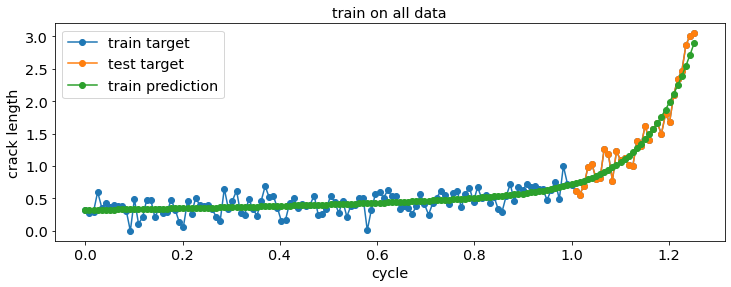

In [40]:
model = FullyConnectedExp([1, 4, 4, 1], activation=nn.Tanh).to(device)
# model = nn.Linear(1,1).to(device)
losses = train_model(model, torch.cat([train_xtensor, test_xtensor]), torch.cat([train_ytensor, test_ytensor]), epochs=100)

train_predictions, _ = predict_model(model, torch.cat([train_xtensor, test_xtensor]))
# test_predictions, test_loss = predict_model(model, test_xtensor, test_ytensor)
# print(train_predictions.shape, test_predictions.shape)

fig = plot_target_prediction(torch.cat([train_xtensor, test_xtensor]), torch.cat([train_ytensor, test_ytensor]), train_predictions, 
                       test_xtensor, test_ytensor, title="train on all data")
# print(f"{test_loss = }")



In [41]:

# fig = plt.figure(figsize=(12, 4))
# plt.plot(train_xscaled, train_yscaled, marker="o", label="train target")
# plt.plot(test_xscaled, test_yscaled, marker="o", label="test target")
# plt.plot(np.concatenate([train_xscaled, test_xscaled]), train_predictions, marker="o", label="train prediction")
# # plt.plot(testinput, testprediction, marker="o", label="test prediction")
# # plt.ylim(-0.01, 0.02)
# plt.legend()

In [42]:
# def rescale_data(scaler, scaled):
#     return scaler.inverse_transform(scaled)

# fig = plot_target_prediction(train_xrescaled, train_yrescaled, rescale_data(train_yscaler, train_predictions), 
#     test_xrescaled, test_yrescaled, rescale_data(train_yscaler, test_predictions))

# fig = plot_target_prediction(train_xrescaled, train_yrescaled, train_yscaler_torch.inverse(train_predictions), 
#     test_xrescaled, test_yrescaled, train_yscaler_torch.inverse(test_predictions))

## neural network with physics

\begin{align}
\frac{da}{dN}=C(\Delta\sigma\sqrt{\pi a})^m
\\
ln\ \frac {da}{dN} = ln\ C + m\ ln\ (\Delta\sigma\sqrt{\pi a}) = ln\ C + m\ (ln \Delta \sigma + 0.5 ln\ \pi + 0.5 ln\ a)
\end{align}

Rescale derivative after normalization
\begin{align}
T_x(x) = \tilde x = \frac {x - min_x} {max_x - min_x} \\
T_y(y) = \tilde y = \frac {y - min_y} {max_y - min_y} \\
\hat y = model(\tilde x) \\
\\
paris(T_y^{-1}(\hat y)) = \frac d {dx} T_y^{-1} (\hat y) \\
\\
paris(T_y^{-1}(\hat y)) = paris(\hat y(max_y - min_y) + min_y) \\
\\
\frac d {dx} T_y^{-1} (\hat y) = \frac d {d \tilde x} (T_Y^{-1}(\hat y) ) \frac {d \tilde x} {dx} \\
= \frac d {d \tilde x} (model(\tilde x) (max_y - min_y) + min_y) . \frac d {dx} (\frac {x - min_x} {max_x - min_x}) \\
= (max_y - min_y) . \frac {d\ model(\tilde x)} {d \tilde x} . \frac 1 {max_x - min_x}
\end{align}

<!-- paris(\hat y(max_y - min_y) + min_y) = \frac d {dx} (\hat y(max_y - min_y) + min_y) \\ -->


In [43]:
# def paris_law_torch(C, m, a, dsigma):
#     righthandside = C * (dsigma * torch.sqrt(np.pi * a))**m
#     return righthandside

def paris_law_torch_log(loga, C, m, dsigma):
    # log_righthandside = np.log(C) + m * (np.log(dsigma) * 0.5 * np.log(np.pi) + 0.5 * torch.log(a))
    log_righthandside = torch.log(torch.tensor(C)) + m * (torch.log(torch.tensor(dsigma)) * 0.5 * torch.log(torch.tensor(np.pi)) + 0.5 * loga)
    return log_righthandside

def sample_physics_points(xmin, xmax, xstep):
    return torch.linspace(xmin, xmax, steps=xstep).reshape(-1, 1).requires_grad_(True).to(device)                

def compute_data_physics_loss(paris_C, paris_m, paris_dsigma, model, inputdata, targetdata, inputphysics, 
    inputscaler, outputscaler, physics_coeff):
    
    data_prediction = model(inputdata)
    dataloss = tnf.mse_loss(data_prediction, targetdata)

    inputphysics.requires_grad_(True)
    prediction_physics = model(inputphysics)       
#     physics_diff = torch.diff(prediction_physics, dim=0)

    derivative = torch.autograd.grad(outputs=prediction_physics, inputs=inputphysics, 
        grad_outputs=torch.ones_like(inputphysics), retain_graph=True, create_graph=True)[0]
    # detach ?
    rescaled_derivative = derivative * (outputscaler.max - outputscaler.min) / (inputscaler.max - inputscaler.min)
    
    physics_constraint = 1 * paris_law(outputscaler.inverse(prediction_physics), paris_C, paris_m, paris_dsigma)
    physicsloss = physics_coeff * (rescaled_derivative - physics_constraint)**2
    
    return dataloss, torch.mean(physicsloss), rescaled_derivative, physics_constraint, prediction_physics

In [44]:
def compute_data_physics_loss_log(paris_C, paris_m, paris_dsigma, model, inputdata, targetdata, inputphysics, 
    inputscaler, outputscaler, physics_coeff):
    
    data_prediction = model(inputdata)
#     data_prediction = torch.exp(data_prediction)
    dataloss = tnf.mse_loss(data_prediction, targetdata)

    inputphysics.requires_grad_(True)
    prediction_physics = model(inputphysics)       
#     prediction_physics = torch.exp(prediction_physics)
#     physics_diff = torch.diff(prediction_physics, dim=0)

    derivative = torch.autograd.grad(outputs=prediction_physics, inputs=inputphysics, 
        grad_outputs=torch.ones_like(inputphysics), retain_graph=True, create_graph=True)[0]
    rescaled_derivative = derivative * (outputscaler.max - outputscaler.min) / (inputscaler.max - inputscaler.min)
    log_clipped_rescaled_derivative = torch.log(torch.clamp(rescaled_derivative, min=1e-6))
    
    physics_constraint = 1 * paris_law_torch_log(
        torch.log(torch.clamp(outputscaler.inverse(prediction_physics), min=1e-6)), 
        paris_C, paris_m, paris_dsigma)
    physicsloss = physics_coeff * torch.abs(log_clipped_rescaled_derivative - physics_constraint)
#     / physics_constraint
#     physicsloss = physics_coeff * torch.mean(torch.pow(torch.log(rescaled_derivative) - torch.log(physics_constraint), 2))

#     loss = dataloss + physicsloss
    
    return dataloss, torch.mean(physicsloss), log_clipped_rescaled_derivative, physics_constraint, prediction_physics
# , physics_diff.detach().cpu().numpy()

In [45]:
min_xphysics = min(min(train_xtensor), min(test_xtensor)).detach().item()
max_xphysics = max(max(train_xtensor), max(test_xtensor)).detach().item()
# min_xphysics = min(test_xtensor).detach().item()
# max_xphysics = max(test_xtensor).detach().item()
physics_xtensor = sample_physics_points(min_xphysics, max_xphysics, xstep=100)

In [46]:

def train_model_debug(model, traininput, trainlabel, physicsinput, xscaler, yscaler, 
    C , m, dsigma, epochs=5, data_coeff=1, physics_coeff=1, optim=None, verbose=True):
    # using only data loss, physics loss computed but not back progagated
    if optim is None:
        optim = torch.optim.Adam(model.parameters(), lr=1e-1, weight_decay=1e-6)
    
    traininput = traininput.to(device)
    trainlabel = trainlabel.to(device)
    physicsinput = physicsinput.to(device)
#     scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, mode='min', 
#         factor=0.1, patience=10, threshold_mode="rel", threshold=1e-2, verbose=True)

    losses = dict(dataloss=[], physicsloss=[])
    model.train()
    
    for epoch in range(epochs):
        optim.zero_grad()
        
#         min_input = min(min(traininput), min(testinput)).detach().item()
#         max_input = max(max(traininput), max(testinput)).detach().item()
#         xphysics = torch.linspace(min_input, max_input, steps=100).reshape(-1, 1).requires_grad_(True).to(device)
        
        dataloss, physicsloss, rescaled_derivative, physics_constraint, prediction_physics = compute_data_physics_loss(paris_C, paris_m, paris_dsigma, 
           model, traininput, trainlabel, physicsinput, xscaler, yscaler, physics_coeff=physics_coeff)
        
#         loss = dataloss + physicsloss
        loss = data_coeff * dataloss + physics_coeff * physicsloss
        loss.backward()
        optim.step()        
#         scheduler.step(loss)
        losses["dataloss"].append(dataloss.detach().item())
        losses["physicsloss"].append(physicsloss.detach().item())
        
        if verbose and (epochs < 10 or epoch % (epochs//10) == 0):
            print(f"\n Epoch {epoch+1} loss = {loss.detach().item()}") 
            print(f"data loss = {dataloss=} ; physics loss = {physicsloss}")
#             print(f"physic loss 2 = {physicsloss2.detach().item()}")
#             figs.append(plot_twinx(tensor_to_array(physicsinput), tensor_to_array(rescaled_derivative), "derivative",
#                 tensor_to_array(physics_constraint), "predictive paris"))#, paris_law(all_yscaled, paris_C, paris_m, paris_dsigma), "target paris"))

            fig = plt.figure(figsize=(8,4))
#             print(physics_diff.shape, physicsinput.shape)
# * (yscaler.max.item() - yscaler.min.item()) / (xscaler.max.item() - xscaler.min.item())
#             plt.plot(tensor_to_array(physicsinput[1:]), physics_diff / 17 , label="physics diff", marker="o")
            plt.plot(tensor_to_array(physicsinput), tensor_to_array(rescaled_derivative), label="rescaled derivative", marker="o")
            plt.plot(tensor_to_array(physicsinput), tensor_to_array(physics_constraint), label="paris", marker="o")
            
            plt.legend()
            figs.append(fig)
            
            plt.close()            
    return losses


 Epoch 1 loss = 0.602006196975708
data loss = dataloss=tensor(0.6020, grad_fn=<MseLossBackward0>) ; physics loss = 6.690808497522571e-12

 Epoch 101 loss = 0.01863541081547737
data loss = dataloss=tensor(0.0186, grad_fn=<MseLossBackward0>) ; physics loss = 2.764318773884611e-10

 Epoch 201 loss = 0.018274588510394096
data loss = dataloss=tensor(0.0183, grad_fn=<MseLossBackward0>) ; physics loss = 2.845799429440632e-10

 Epoch 301 loss = 0.01817994751036167
data loss = dataloss=tensor(0.0182, grad_fn=<MseLossBackward0>) ; physics loss = 2.89995805147214e-10

 Epoch 401 loss = 0.018136460334062576
data loss = dataloss=tensor(0.0181, grad_fn=<MseLossBackward0>) ; physics loss = 3.0389241123529587e-10

 Epoch 501 loss = 0.01812434382736683
data loss = dataloss=tensor(0.0181, grad_fn=<MseLossBackward0>) ; physics loss = 3.1397690003487355e-10

 Epoch 601 loss = 0.018119139596819878
data loss = dataloss=tensor(0.0181, grad_fn=<MseLossBackward0>) ; physics loss = 3.2203814614994997e-10

 Epo

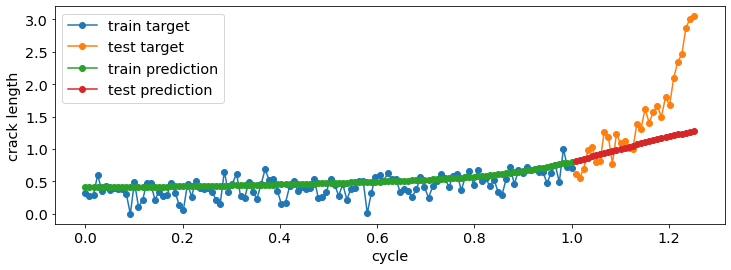

In [47]:
model = FullyConnected([1, 4, 4, 1], activation=nn.Tanh).to(device)
figs=[]
epochs = 1000
physics_coeff = 1
# fig = plt.figure(1, figsize=(12,4))
losses = train_model_debug(model, train_xtensor, train_ytensor, physics_xtensor, 
    train_xscaler_torch, train_yscaler_torch, paris_C, paris_m, paris_dsigma, epochs=epochs, physics_coeff=physics_coeff)

train_predictions, _ = predict_model(model, train_xtensor)
test_predictions, test_loss = predict_model(model, test_xtensor, test_ytensor)
# print(train_predictions.shape, test_predictions.shape)

fig = plot_target_prediction(train_xtensor, train_ytensor, train_predictions, 
                       test_xtensor, test_ytensor, test_predictions)


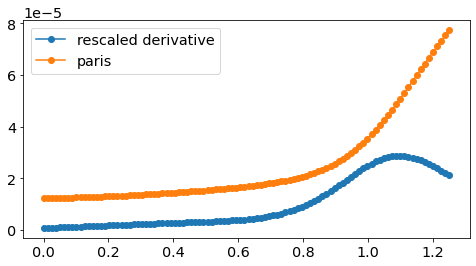

In [48]:
figs[-1]

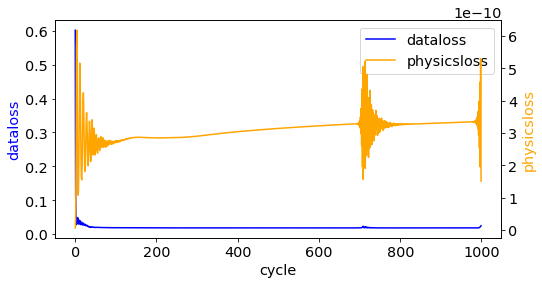

In [49]:
fig = plot_twinx(np.arange(epochs), losses["dataloss"], "dataloss", losses["physicsloss"], "physicsloss")

## All train data


 Epoch 1 loss = 1.355987787246704
data loss = dataloss=tensor(1.3560, grad_fn=<MseLossBackward0>) ; physics loss = 4.094898465450969e-12

 Epoch 11 loss = 0.3010590672492981
data loss = dataloss=tensor(0.3011, grad_fn=<MseLossBackward0>) ; physics loss = 4.013257504098533e-10

 Epoch 21 loss = 0.23313631117343903
data loss = dataloss=tensor(0.2331, grad_fn=<MseLossBackward0>) ; physics loss = 2.394776876801785e-10

 Epoch 31 loss = 0.14862655103206635
data loss = dataloss=tensor(0.1486, grad_fn=<MseLossBackward0>) ; physics loss = 9.309518711475562e-10

 Epoch 41 loss = 0.11447775363922119
data loss = dataloss=tensor(0.1145, grad_fn=<MseLossBackward0>) ; physics loss = 9.148760082844376e-10

 Epoch 51 loss = 0.07806971669197083
data loss = dataloss=tensor(0.0781, grad_fn=<MseLossBackward0>) ; physics loss = 8.788408334403641e-10

 Epoch 61 loss = 0.05037520453333855
data loss = dataloss=tensor(0.0504, grad_fn=<MseLossBackward0>) ; physics loss = 7.614229247110416e-10

 Epoch 71 loss =

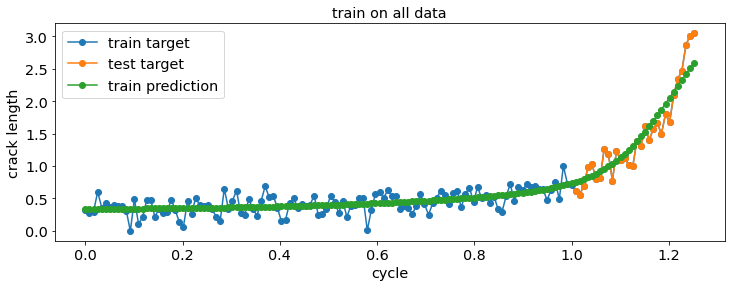

In [50]:
model = FullyConnected([1, 4, 4, 1], activation=nn.Tanh).to(device)
figs=[]
epochs = 100
physics_coeff = 1
# fig = plt.figure(1, figsize=(12,4))
losses = train_model_debug(model, torch.cat([train_xtensor, test_xtensor]), torch.cat([train_ytensor, test_ytensor]), physics_xtensor, 
    train_xscaler_torch, train_yscaler_torch, paris_C, paris_m, paris_dsigma, epochs=epochs, physics_coeff=physics_coeff)

train_predictions, _ = predict_model(model, torch.cat([train_xtensor, test_xtensor]))
# test_predictions, test_loss = predict_model(model, test_xtensor, test_ytensor)
# print(train_predictions.shape, test_predictions.shape)

fig = plot_target_prediction(torch.cat([train_xtensor, test_xtensor]), torch.cat([train_ytensor, test_ytensor]), train_predictions, 
                       test_xtensor, test_ytensor, title="train on all data")


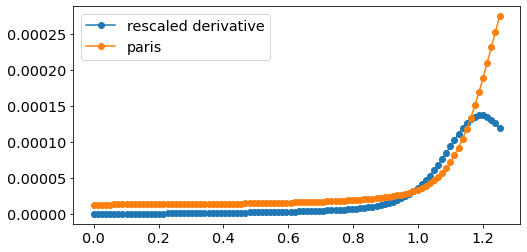

In [51]:
figs[-1]

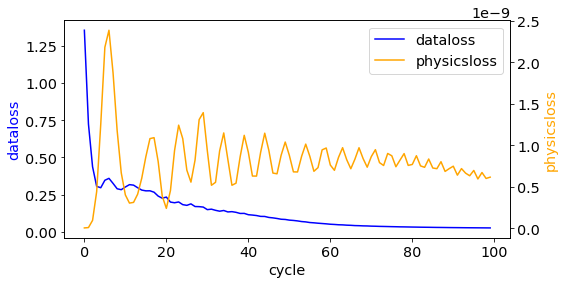

In [52]:
fig = plot_twinx(np.arange(epochs), losses["dataloss"], "dataloss", losses["physicsloss"], "physicsloss")


 Epoch 1 loss = 0.6598108410835266
data loss = dataloss=tensor(0.6598, grad_fn=<MseLossBackward0>) ; physics loss = 6.30017105152092e-09

 Epoch 11 loss = 0.29459095001220703
data loss = dataloss=tensor(0.2946, grad_fn=<MseLossBackward0>) ; physics loss = 1.53105927935826e-09

 Epoch 21 loss = 0.11915243417024612
data loss = dataloss=tensor(0.1192, grad_fn=<MseLossBackward0>) ; physics loss = 1.1127011534384224e-09

 Epoch 31 loss = 0.07070621103048325
data loss = dataloss=tensor(0.0707, grad_fn=<MseLossBackward0>) ; physics loss = 3.564418760149124e-10

 Epoch 41 loss = 0.0508493036031723
data loss = dataloss=tensor(0.0508, grad_fn=<MseLossBackward0>) ; physics loss = 3.3174721303375065e-10

 Epoch 51 loss = 0.03677871450781822
data loss = dataloss=tensor(0.0368, grad_fn=<MseLossBackward0>) ; physics loss = 4.1268030659402655e-10

 Epoch 61 loss = 0.029767487198114395
data loss = dataloss=tensor(0.0298, grad_fn=<MseLossBackward0>) ; physics loss = 5.9198473900679e-10

 Epoch 71 loss 

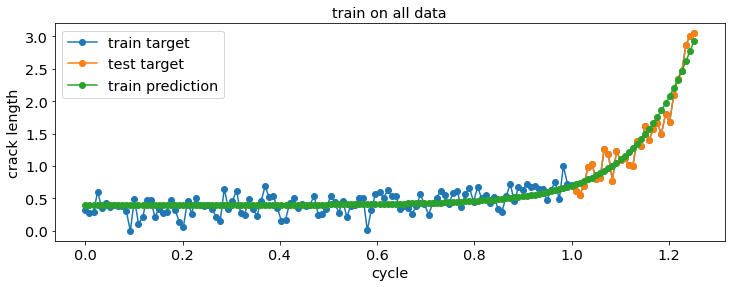

In [53]:
model = FullyConnectedExp([1, 4, 4, 1], activation=nn.Tanh).to(device)
figs=[]
epochs = 100
physics_coeff = 1
# fig = plt.figure(1, figsize=(12,4))
losses = train_model_debug(model, torch.cat([train_xtensor, test_xtensor]), torch.cat([train_ytensor, test_ytensor]), physics_xtensor, 
    train_xscaler_torch, train_yscaler_torch, paris_C, paris_m, paris_dsigma, epochs=epochs, physics_coeff=physics_coeff)

train_predictions, _ = predict_model(model, torch.cat([train_xtensor, test_xtensor]))
# test_predictions, test_loss = predict_model(model, test_xtensor, test_ytensor)
# print(train_predictions.shape, test_predictions.shape)

fig = plot_target_prediction(torch.cat([train_xtensor, test_xtensor]), torch.cat([train_ytensor, test_ytensor]), train_predictions, 
                       test_xtensor, test_ytensor, title="train on all data")


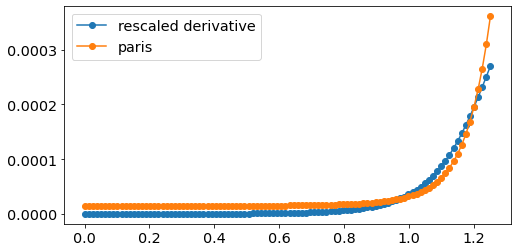

In [54]:
figs[-1]

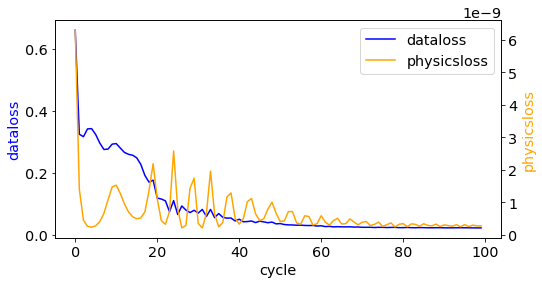

In [55]:
fig = plot_twinx(np.arange(epochs), losses["dataloss"], "dataloss", losses["physicsloss"], "physicsloss")

## Only physics loss


 Epoch 1 loss = 19582775296.0
data loss = dataloss=tensor(0.3380, grad_fn=<MseLossBackward0>) ; physics loss = 1.9582775831222534

 Epoch 201 loss = 23435.59765625
data loss = dataloss=tensor(1.0276, grad_fn=<MseLossBackward0>) ; physics loss = 2.3435597995558055e-06

 Epoch 401 loss = 20444.859375
data loss = dataloss=tensor(1.0291, grad_fn=<MseLossBackward0>) ; physics loss = 2.044485881924629e-06

 Epoch 601 loss = 17395.990234375
data loss = dataloss=tensor(1.0323, grad_fn=<MseLossBackward0>) ; physics loss = 1.7395989289070712e-06

 Epoch 801 loss = 14472.435546875
data loss = dataloss=tensor(1.0357, grad_fn=<MseLossBackward0>) ; physics loss = 1.4472435623247293e-06

 Epoch 1001 loss = 11847.2646484375
data loss = dataloss=tensor(1.0392, grad_fn=<MseLossBackward0>) ; physics loss = 1.1847264431708027e-06

 Epoch 1201 loss = 9577.666015625
data loss = dataloss=tensor(1.0426, grad_fn=<MseLossBackward0>) ; physics loss = 9.577665878168773e-07

 Epoch 1401 loss = 7659.66357421875
da

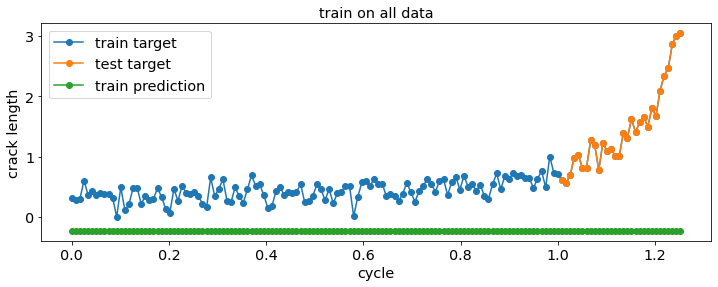

In [56]:
model = FullyConnected([1, 4, 4, 1], activation=nn.Tanh).to(device)
figs=[]
epochs = 2000

# fig = plt.figure(1, figsize=(12,4))
losses = train_model_debug(model, torch.cat([train_xtensor, test_xtensor]), torch.cat([train_ytensor, test_ytensor]), physics_xtensor, 
    train_xscaler_torch, train_yscaler_torch, paris_C, paris_m, paris_dsigma, epochs=epochs, 
    data_coeff=0, physics_coeff=1e10)

train_predictions, _ = predict_model(model, torch.cat([train_xtensor, test_xtensor]))
# test_predictions, test_loss = predict_model(model, test_xtensor, test_ytensor)
# print(train_predictions.shape, test_predictions.shape)

fig = plot_target_prediction(torch.cat([train_xtensor, test_xtensor]), torch.cat([train_ytensor, test_ytensor]), train_predictions, 
                       test_xtensor, test_ytensor, title="train on all data")


In [57]:

def train_model_physics(model, traininput, trainlabel, physicsinput, xscaler, yscaler, 
    paris_C , paris_m, paris_dsigma, epochs=5, physics_coeff=1, optim=None, verbose=True):
    
    if optim is None:
        optim = torch.optim.Adam(model.parameters(), lr=1e-1, weight_decay=1e-6)
    
    traininput = traininput.to(device)
    trainlabel = trainlabel.to(device)
    physicsinput = physicsinput.to(device)
#     scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, mode='min', 
#         factor=0.1, patience=10, threshold_mode="rel", threshold=1e-2, verbose=True)

    losses = dict(dataloss=[], physicsloss=[])
    model.train()
    
    for epoch in range(epochs):
        optim.zero_grad()
               
        dataloss, physicsloss, rescaled_derivative, physics_constraint, prediction_physics = compute_data_physics_loss(paris_C, paris_m, paris_dsigma, 
           model, traininput, trainlabel, physicsinput, xscaler, yscaler, physics_coeff=physics_coeff)
        
        loss = dataloss + physicsloss
        loss.backward()
        optim.step()        
#         scheduler.step(loss)
        losses["dataloss"].append(dataloss.detach().item())
        losses["physicsloss"].append(physicsloss.detach().item())
        
        if verbose and (epochs < 10 or epoch % (epochs//10) == 0):
            print(f"\n Epoch {epoch+1} loss = {loss.detach().item()}") 
            print(f"data loss = {dataloss.detach().item()} ; physics loss = {physicsloss.detach().item()}")
#             print(f"physic loss 2 = {physicsloss2.detach().item()}")
#             figs.append(plot_twinx(tensor_to_array(xphysics), tensor_to_array(rescaled_derivative), "derivative",
#                 tensor_to_array(physics_constraint), "predictive paris"))#, paris_law(all_yscaled, paris_C, paris_m, paris_dsigma), "target paris"))

            fig = plt.figure(figsize=(8,4))
            plt.plot(tensor_to_array(physicsinput), tensor_to_array(rescaled_derivative), label="rescaled derivative", marker="o")
            plt.plot(tensor_to_array(physicsinput), tensor_to_array(physics_constraint), label="paris", marker="o")
            plt.legend()
            figs.append(fig)
            
            plt.close()            
    return losses

In [58]:
minparam = 10
maxparam = -10

for param in model.parameters():
#     print(param)
    minparam = min(minparam, torch.min(param.data))
    maxparam = max(maxparam, torch.max(param.data))
    
minparam, maxparam

(tensor(-1.0066), tensor(1.0111))


 Epoch 1 loss = 1.2142268419265747
data loss = 1.2142268419265747 ; physics loss = 4.2311836814194065e-15

 Epoch 11 loss = 0.31129053235054016
data loss = 0.31129053235054016 ; physics loss = 2.9117417569939075e-13

 Epoch 21 loss = 0.264981210231781
data loss = 0.264981210231781 ; physics loss = 3.0442369545330417e-13

 Epoch 31 loss = 0.18411211669445038
data loss = 0.18411211669445038 ; physics loss = 6.359867602175051e-13

 Epoch 41 loss = 0.14688163995742798
data loss = 0.14688163995742798 ; physics loss = 9.64393387196949e-13

 Epoch 51 loss = 0.12501971423625946
data loss = 0.12501971423625946 ; physics loss = 1.1260675551738597e-12

 Epoch 61 loss = 0.09974397718906403
data loss = 0.09974397718906403 ; physics loss = 8.950052070993975e-13

 Epoch 71 loss = 0.07677818834781647
data loss = 0.07677818834781647 ; physics loss = 7.338527029977782e-13

 Epoch 81 loss = 0.05803408473730087
data loss = 0.05803408473730087 ; physics loss = 8.698116012173518e-13

 Epoch 91 loss = 0.045

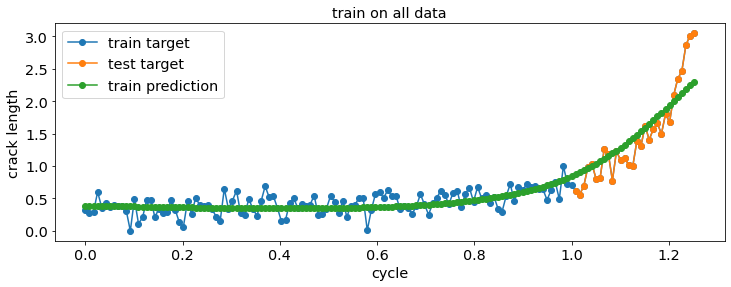

In [59]:
model = FullyConnected([1, 4, 4, 1], activation=nn.Tanh).to(device)
figs=[]
epochs = 100
physics_coeff = 1e-3

losses = train_model_physics(model, torch.cat([train_xtensor, test_xtensor]), torch.cat([train_ytensor, test_ytensor]), physics_xtensor, 
    train_xscaler_torch, train_yscaler_torch, paris_C, paris_m, paris_dsigma, epochs=epochs, physics_coeff=physics_coeff)

train_predictions, _ = predict_model(model, torch.cat([train_xtensor, test_xtensor]))
# test_predictions, test_loss = predict_model(model, test_xtensor, test_ytensor)
# print(train_predictions.shape, test_predictions.shape)

fig = plot_target_prediction(torch.cat([train_xtensor, test_xtensor]), torch.cat([train_ytensor, test_ytensor]), train_predictions, 
                       test_xtensor, test_ytensor, title="train on all data")

# print(f"{test_loss = }")

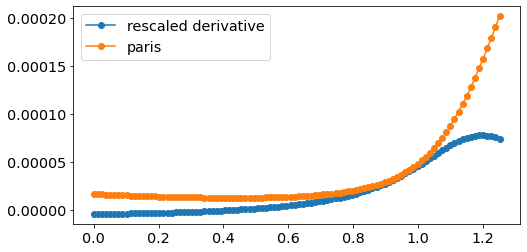

In [60]:
figs[-1]

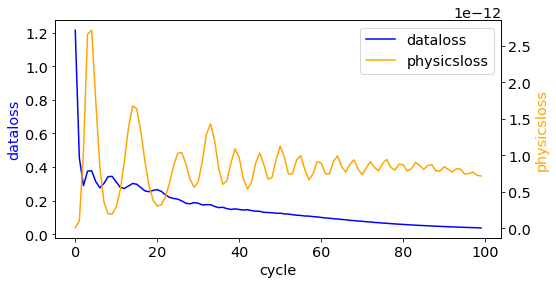

In [61]:
fig = plot_twinx(np.arange(epochs), losses["dataloss"], "dataloss", losses["physicsloss"], "physicsloss")


 Epoch 1 loss = 1.3130695819854736
data loss = 1.3130695819854736 ; physics loss = 4.825063417389364e-13

 Epoch 11 loss = 0.059392571449279785
data loss = 0.059392571449279785 ; physics loss = 1.2318331034030794e-12

 Epoch 21 loss = 0.02702818065881729
data loss = 0.02702818065881729 ; physics loss = 1.91520584114091e-12

 Epoch 31 loss = 0.024766629561781883
data loss = 0.024766629561781883 ; physics loss = 1.732736892336162e-12

 Epoch 41 loss = 0.02158132940530777
data loss = 0.02158132940530777 ; physics loss = 2.1069983865279474e-12

 Epoch 51 loss = 0.020128877833485603
data loss = 0.020128877833485603 ; physics loss = 2.681108373508989e-12

 Epoch 61 loss = 0.01987680047750473
data loss = 0.01987680047750473 ; physics loss = 2.943428487056643e-12

 Epoch 71 loss = 0.019313568249344826
data loss = 0.019313568249344826 ; physics loss = 2.503324804392637e-12

 Epoch 81 loss = 0.018956638872623444
data loss = 0.018956638872623444 ; physics loss = 2.7854465695781316e-12

 Epoch 91

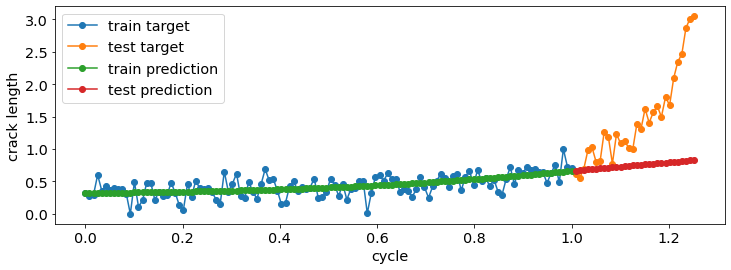

In [62]:
model = FullyConnected([1, 4, 4, 1], activation=nn.Tanh).to(device)
figs=[]
epochs = 100
physics_coeff = 1e-2
# fig = plt.figure(1, figsize=(12,4))
# losses = train_model_physics(model, train_xtensor, train_ytensor, physics_xtensor, 
#     train_xscaler_torch, train_yscaler_torch, paris_C, paris_m, paris_dsigma, epochs=epochs, physics_coeff=physics_coeff)

losses = train_model_physics(model, train_xtensor, train_ytensor, physics_xtensor, 
    train_xscaler_torch, train_yscaler_torch, paris_C, paris_m, paris_dsigma, epochs=epochs, physics_coeff=physics_coeff)

train_predictions, _ = predict_model(model, train_xtensor)
test_predictions, test_loss = predict_model(model, test_xtensor, test_ytensor)
# print(train_predictions.shape, test_predictions.shape)

# fig = plot_target_prediction(train_xscaled, train_yscaled, torch.exp(train_predictions), 
#                        test_xscaled, test_yscaled, torch.exp(test_predictions))
fig = plot_target_prediction(train_xtensor, train_ytensor, train_predictions, 
                       test_xtensor, test_ytensor, test_predictions)

print(f"{test_loss = }")

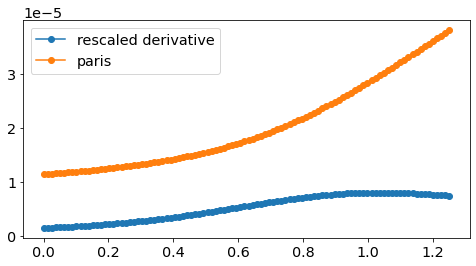

In [63]:
figs[-1]

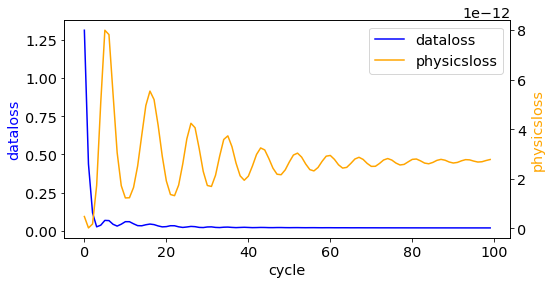

In [64]:
fig = plot_twinx(np.arange(epochs), losses["dataloss"], "dataloss", losses["physicsloss"], "physicsloss")

## Long training with physics


 Epoch 1 loss = 0.669815719127655
data loss = 0.669815719127655 ; physics loss = 6.251533513079721e-09

 Epoch 1001 loss = 0.018223006278276443
data loss = 0.018223006278276443 ; physics loss = 3.058779063369599e-10

 Epoch 2001 loss = 0.018130892887711525
data loss = 0.018130892887711525 ; physics loss = 3.177156038258744e-10

 Epoch 3001 loss = 0.01811828278005123
data loss = 0.01811828278005123 ; physics loss = 3.3656077924604233e-10

 Epoch 4001 loss = 0.018113374710083008
data loss = 0.018113374710083008 ; physics loss = 3.524682767874765e-10

 Epoch 5001 loss = 0.01810935139656067
data loss = 0.01810935139656067 ; physics loss = 3.624885391850796e-10

 Epoch 6001 loss = 0.01806584559381008
data loss = 0.01806584559381008 ; physics loss = 3.512725388343796e-10

 Epoch 7001 loss = 0.01771439053118229
data loss = 0.01771439053118229 ; physics loss = 3.047418428714366e-10

 Epoch 8001 loss = 0.01766318641602993
data loss = 0.01766318641602993 ; physics loss = 4.5361420175638045e-10


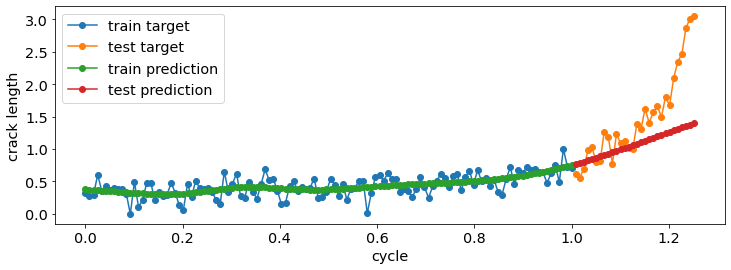

In [65]:
model = FullyConnectedExp([1, 4, 4, 1], activation=nn.Tanh).to(device)
figs=[]
epochs = 20000
physics_coeff = 1
# fig = plt.figure(1, figsize=(12,4))
# losses = train_model_physics(model, train_xtensor, train_ytensor, physics_xtensor, 
#     train_xscaler_torch, train_yscaler_torch, paris_C, paris_m, paris_dsigma, epochs=epochs, physics_coeff=physics_coeff)

losses = train_model_physics(model, train_xtensor, train_ytensor, physics_xtensor, 
    train_xscaler_torch, train_yscaler_torch, paris_C, paris_m, paris_dsigma, epochs=epochs, physics_coeff=physics_coeff,
    optim = torch.optim.Adam(model.parameters(), lr=1e-2, weight_decay=0))

train_predictions, _ = predict_model(model, train_xtensor)
test_predictions, test_loss = predict_model(model, test_xtensor, test_ytensor)
# print(train_predictions.shape, test_predictions.shape)

# fig = plot_target_prediction(train_xscaled, train_yscaled, torch.exp(train_predictions), 
#                        test_xscaled, test_yscaled, torch.exp(test_predictions))
fig = plot_target_prediction(train_xtensor, train_ytensor, train_predictions, 
                       test_xtensor, test_ytensor, test_predictions)

print(f"{test_loss = }")

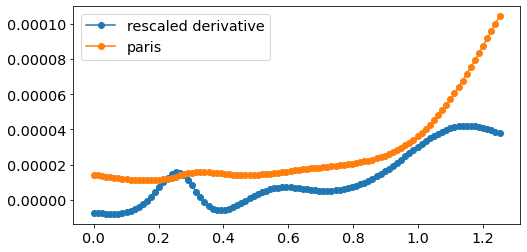

In [66]:
figs[-1]

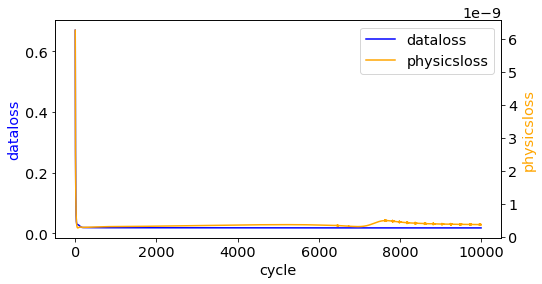

In [67]:
# # plt.figure(figsize=(8, 4))
# fig, ax1 = plt.subplots(figsize=(8,4))
# ax2 = ax1.twinx()

# plot1 = ax1.plot(np.arange(epochs), losses["dataloss"], marker="o", label="data loss", color="blue")
# ax1.set_ylabel("dataloss", color="blue")

# plot2 = ax2.plot(np.arange(epochs), losses["physicsloss"], marker="o", label="physics loss", color="orange")
# ax2.set_ylabel("physics loss", color="orange")

# # hack for legend
# ax1.plot([], [], color="orange", label="physicsloss")
# ax1.legend()

fig = plot_twinx(np.arange(epochs), losses["dataloss"], "dataloss", losses["physicsloss"], "physicsloss")


 Epoch 1 loss = 0.9202161431312561
data loss = 0.9202161431312561 ; physics loss = 6.8827864414811035e-12

 Epoch 1001 loss = 0.020010512322187424
data loss = 0.020010512322187424 ; physics loss = 2.6164576061304956e-10

 Epoch 2001 loss = 0.018314829096198082
data loss = 0.018314829096198082 ; physics loss = 2.8306373911490823e-10

 Epoch 3001 loss = 0.01817936636507511
data loss = 0.01817936636507511 ; physics loss = 2.847085345258904e-10

 Epoch 4001 loss = 0.018146656453609467
data loss = 0.018146656453609467 ; physics loss = 2.8563598708508664e-10

 Epoch 5001 loss = 0.018137140199542046
data loss = 0.018137140199542046 ; physics loss = 2.8783828098788433e-10

 Epoch 6001 loss = 0.018129687756299973
data loss = 0.018129687756299973 ; physics loss = 2.883326355451743e-10

 Epoch 7001 loss = 0.018121039494872093
data loss = 0.018121039494872093 ; physics loss = 2.959191780504966e-10

 Epoch 8001 loss = 0.018112948164343834
data loss = 0.018112948164343834 ; physics loss = 3.1490599

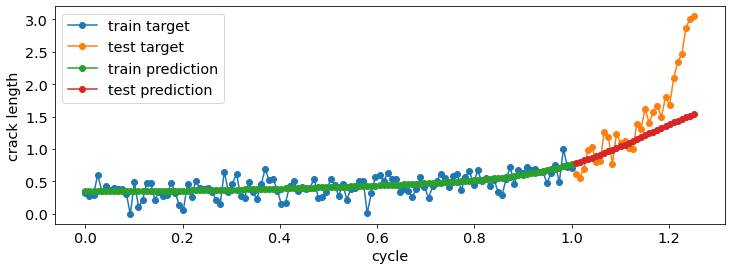

In [68]:
model = FullyConnected([1, 4, 4, 1], activation=nn.Tanh).to(device)
figs=[]
epochs = 20000
physics_coeff = 1
# fig = plt.figure(1, figsize=(12,4))
# losses = train_model_physics(model, train_xtensor, train_ytensor, physics_xtensor, 
#     train_xscaler_torch, train_yscaler_torch, paris_C, paris_m, paris_dsigma, epochs=epochs, physics_coeff=physics_coeff)

losses = train_model_physics(model, train_xtensor, train_ytensor, physics_xtensor, 
    train_xscaler_torch, train_yscaler_torch, paris_C, paris_m, paris_dsigma, epochs=epochs, physics_coeff=physics_coeff,
    optim = torch.optim.Adam(model.parameters(), lr=1e-2, weight_decay=0))

train_predictions, _ = predict_model(model, train_xtensor)
test_predictions, test_loss = predict_model(model, test_xtensor, test_ytensor)
# print(train_predictions.shape, test_predictions.shape)

# fig = plot_target_prediction(train_xscaled, train_yscaled, torch.exp(train_predictions), 
#                        test_xscaled, test_yscaled, torch.exp(test_predictions))
fig = plot_target_prediction(train_xtensor, train_ytensor, train_predictions, 
                       test_xtensor, test_ytensor, test_predictions)

print(f"{test_loss = }")

## gradient magnitude

observation data: $\{x[i], y[i]\}, i = 1...n[obs]$ \
model prediction with paramater w: $\hat y = h(x; w)$ \
physics constraint: $$\frac {d h(x; w)} {dx} = f(x)$$

static scalarization of multi task loss:

\begin{align}
L = L_{obs} + \lambda_{phy} L_{phy}
= \sum_{i=1}^{n[obs]}(h(x[i]; w) - y[i])^2 + \lambda_{phy} \sum_{j=1}^{n[phy]} (\frac {d h(x[j]; w)} {dx} - f(x_j))^2
\end{align}

Gradient magnitude scalarization according to "Optimally weighted loss functions for solving PDEs with Neural Networks"
(https://arxiv.org/pdf/2002.06269.pdf)

\begin{align}
L = \frac {L_{obs}} {||\nabla_x L_{obs}||^2} + \frac {L_{phy}} {||f(x)||^2} \\
= \frac {\sum_{i=1}^{n[obs]}(h(x[i]; w) - y[i])^2} {\sum_{i=1}^{n[obs]} y[i]^2}
+ \frac {\sum_{j=1}^{n[phy]} (\frac {d h(x[j]; w)} {dx} - f(x_j)^2} {\sum_{i=1}^{n[phy]} (|\frac {d h(x[j]; w)} {dx}| + |f(x_j)|)^2}
\end{align}


In [65]:

def train_model_physics_magnitude_norm(model, traininput, trainlabel, physicsinput, xscaler, yscaler, 
    paris_C , paris_m, paris_dsigma, epochs=5, physics_coeff=1, optim=None, verbose=True):
    
    if optim is None:
        optim = torch.optim.Adam(model.parameters(), lr=1e-1, weight_decay=1e-6)
    
    traininput = traininput.to(device)
    trainlabel = trainlabel.to(device)
    physicsinput = physicsinput.to(device)
#     scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, mode='min', 
#         factor=0.1, patience=10, threshold_mode="rel", threshold=1e-2, verbose=True)

    metric = dict(dataloss=[], physicsloss=[], normalized_dataloss=[], normalized_physicsloss=[])
    model.train()
    
    for epoch in range(epochs):
        optim.zero_grad()
               
        dataloss, physicsloss, rescaled_derivative, physics_constraint, physics_prediction = compute_data_physics_loss(paris_C, paris_m, paris_dsigma, 
           model, traininput, trainlabel, physicsinput, xscaler, yscaler, physics_coeff=physics_coeff)
        
        # # detach ???
        # differential_norm = torch.abs(rescaled_erivative.detach()) + torch.abs(physics_constraint.detach())
        differential_norm = torch.abs(rescaled_derivative) + torch.abs(physics_constraint)
        differential_norm = torch.sum(differential_norm**2)
        data_norm = torch.sum(trainlabel**2)

#         differential_norm = torch.abs(rescaled_derivative) + torch.abs(physics_constraint)
#         differential_norm = torch.sum(differential_norm)
#         data_norm = torch.sum(trainlabel)

        loss = dataloss / data_norm + physicsloss / differential_norm
        loss.backward()
        optim.step()        
#         scheduler.step(loss)
        metric["dataloss"].append(dataloss.detach().item())
        metric["physicsloss"].append(physicsloss.detach().item())
        metric["normalized_dataloss"].append((dataloss / data_norm).detach().item())
        metric["normalized_physicsloss"].append((physicsloss / differential_norm).detach().item())
        
        if verbose and (epochs < 10 or epoch % (epochs//10) == 0):
            print(f"\n Epoch {epoch+1} loss = {loss.detach().item()}") 
#             print(f"normalized data loss = {(dataloss / data_norm).detach().item()} ; normalized physics loss = {(physicsloss / differential_norm).detach().item()}")
            print(f"normalized data loss = {metric['normalized_dataloss'][-1]} ; normalized physics loss = {metric['normalized_physicsloss'][-1]}")
            print(f"{data_norm = } {differential_norm = }")

#             print(f"physic loss 2 = {physicsloss2.detach().item()}")
#             figs.append(plot_twinx(tensor_to_array(xphysics), tensor_to_array(rescaled_derivative), "derivative",
#                 tensor_to_array(physics_constraint), "predictive paris"))#, paris_law(all_yscaled, paris_C, paris_m, paris_dsigma), "target paris"))

            fig = plt.figure(figsize=(8,4))
            plt.plot(tensor_to_array(physicsinput), tensor_to_array(rescaled_derivative), label="rescaled derivative", marker="o")
            plt.plot(tensor_to_array(physicsinput), tensor_to_array(physics_constraint), label="paris", marker="o")
            plt.legend()
            figs.append(fig)
            
            plt.close()            
            
    
    for metricname, metricvalue in metric.items():
        metric[metricname] = np.array(metricvalue)
    
    return metric


 Epoch 1 loss = 0.010439908131957054
normalized data loss = 0.0013820263557136059 ; normalized physics loss = 0.009057881310582161
data_norm = tensor(26.2073) differential_norm = tensor(1.6948e-08, grad_fn=<SumBackward0>)

 Epoch 1001 loss = 0.0007644379511475563
normalized data loss = 0.0006982737686485052 ; normalized physics loss = 6.616415339522064e-05
data_norm = tensor(26.2073) differential_norm = tensor(1.6499e-06, grad_fn=<SumBackward0>)

 Epoch 2001 loss = 0.000731360400095582
normalized data loss = 0.0006957228761166334 ; normalized physics loss = 3.563751670299098e-05
data_norm = tensor(26.2073) differential_norm = tensor(2.9753e-06, grad_fn=<SumBackward0>)

 Epoch 3001 loss = 0.00072526402072981
normalized data loss = 0.0006952339317649603 ; normalized physics loss = 3.0030076231923886e-05
data_norm = tensor(26.2073) differential_norm = tensor(3.7639e-06, grad_fn=<SumBackward0>)

 Epoch 4001 loss = 0.0007236922974698246
normalized data loss = 0.0006950349197722971 ; normal

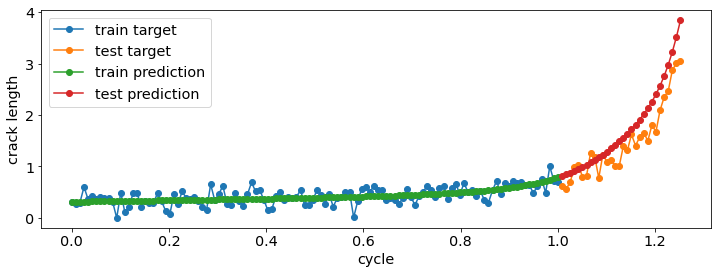

In [70]:
%%time 
model = FullyConnected([1, 4, 4, 1], activation=nn.Tanh).to(device)
figs=[]
epochs = 10000
physics_coeff = 1

optim = torch.optim.Adam(model.parameters(), lr=1e-2, weight_decay=1e-6)
metric = train_model_physics_magnitude_norm(model, train_xtensor, train_ytensor, physics_xtensor, 
    train_xscaler_torch, train_yscaler_torch, paris_C, paris_m, paris_dsigma, epochs=epochs, physics_coeff=physics_coeff,
    optim=optim)

train_predictions, _ = predict_model(model, train_xtensor)
test_predictions, test_loss = predict_model(model, test_xtensor, test_ytensor)
# print(train_predictions.shape, test_predictions.shape)

# fig = plot_target_prediction(train_xscaled, train_yscaled, torch.exp(train_predictions), 
#                        test_xscaled, test_yscaled, torch.exp(test_predictions))
fig = plot_target_prediction(train_xtensor, train_ytensor, train_predictions, 
                       test_xtensor, test_ytensor, test_predictions)

print(f"{test_loss = }")

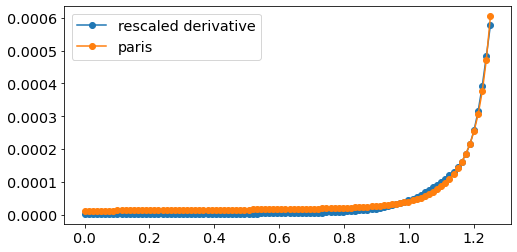

In [71]:
figs[-1]

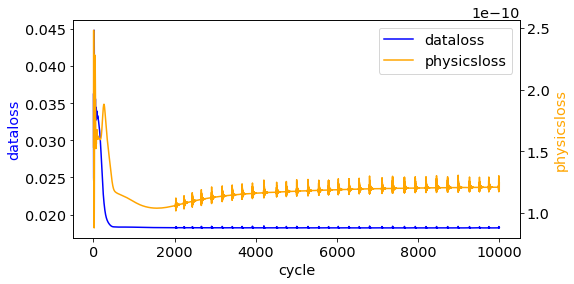

In [72]:
fig = plot_twinx(np.arange(epochs), metric["dataloss"], "dataloss", metric["physicsloss"], "physicsloss")

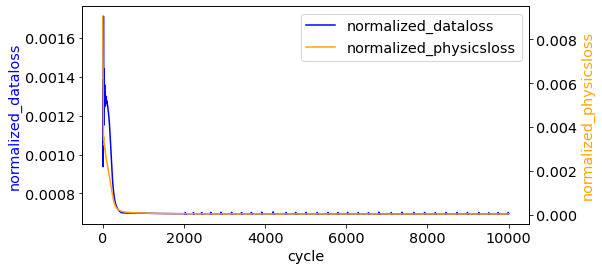

In [73]:
fig = plot_twinx(np.arange(epochs), metric["normalized_dataloss"], "normalized_dataloss", metric["normalized_physicsloss"], "normalized_physicsloss",)

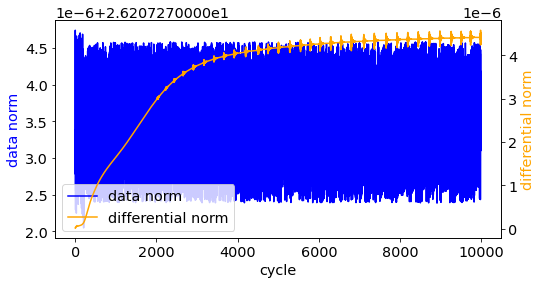

In [74]:
fig = plot_twinx(np.arange(epochs), metric["dataloss"] / metric["normalized_dataloss"], "data norm",
    metric["physicsloss"] / metric["normalized_physicsloss"], "differential norm",)


 Epoch 1 loss = 0.010958598926663399
normalized data loss = 0.0016953502781689167 ; normalized physics loss = 0.009263248182833195
data_norm = tensor(26.2073) differential_norm = tensor(6.1346e-08, grad_fn=<SumBackward0>)

 Epoch 1001 loss = 0.0007388804224319756
normalized data loss = 0.0006966905202716589 ; normalized physics loss = 4.218988760840148e-05
data_norm = tensor(26.2073) differential_norm = tensor(3.3488e-06, grad_fn=<SumBackward0>)

 Epoch 2001 loss = 0.0007136865169741213
normalized data loss = 0.0006949045928195119 ; normalized physics loss = 1.8781920516630635e-05
data_norm = tensor(26.2073) differential_norm = tensor(8.0577e-06, grad_fn=<SumBackward0>)

 Epoch 3001 loss = 0.0007081383955664933
normalized data loss = 0.0006939564482308924 ; normalized physics loss = 1.4181950064084958e-05
data_norm = tensor(26.2073) differential_norm = tensor(1.4972e-05, grad_fn=<SumBackward0>)

 Epoch 4001 loss = 0.0007066167891025543
normalized data loss = 0.0006935967830941081 ; no

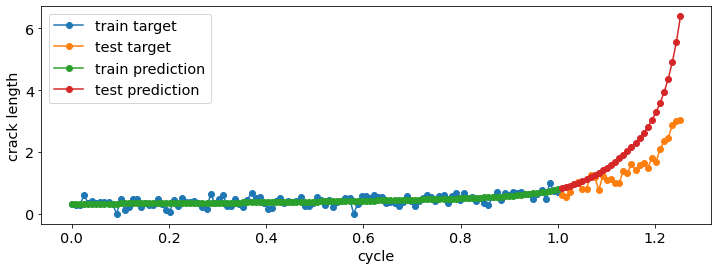

In [75]:
%%time

model = FullyConnectedExp([1, 4, 4, 1], activation=nn.Tanh).to(device)
figs=[]
epochs = 10000
physics_coeff = 1

optim = torch.optim.Adam(model.parameters(), lr=1e-2, weight_decay=1e-6)
metric = train_model_physics_magnitude_norm(model, train_xtensor, train_ytensor, physics_xtensor, 
    train_xscaler_torch, train_yscaler_torch, paris_C, paris_m, paris_dsigma, epochs=epochs, physics_coeff=physics_coeff,
    optim=optim)

train_predictions, _ = predict_model(model, train_xtensor)
test_predictions, test_loss = predict_model(model, test_xtensor, test_ytensor)
# print(train_predictions.shape, test_predictions.shape)

# fig = plot_target_prediction(train_xscaled, train_yscaled, torch.exp(train_predictions), 
#                        test_xscaled, test_yscaled, torch.exp(test_predictions))
fig = plot_target_prediction(train_xtensor, train_ytensor, train_predictions, 
                       test_xtensor, test_ytensor, test_predictions)

print(f"{test_loss = }")

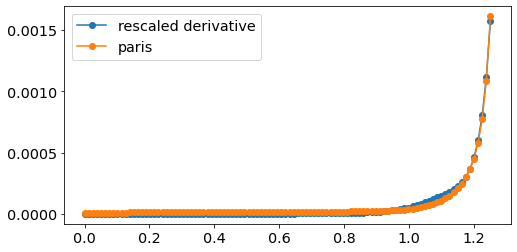

In [76]:
figs[-1]

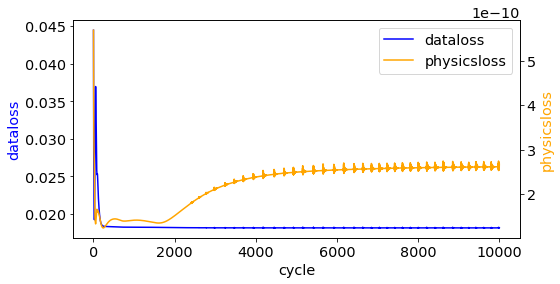

In [77]:
fig = plot_twinx(np.arange(epochs), metric["dataloss"], "dataloss", metric["physicsloss"], "physicsloss")

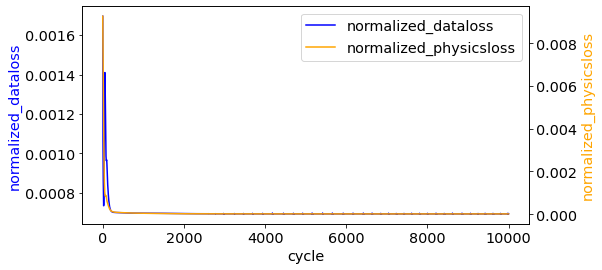

In [78]:
fig = plot_twinx(np.arange(epochs), metric["normalized_dataloss"], "normalized_dataloss", metric["normalized_physicsloss"], "normalized_physicsloss",)

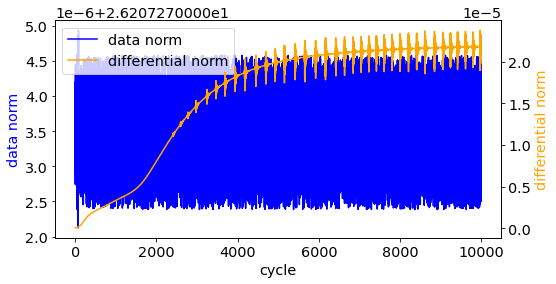

In [79]:
fig = plot_twinx(np.arange(epochs), metric["dataloss"] / metric["normalized_dataloss"], "data norm",
    metric["physicsloss"] / metric["normalized_physicsloss"], "differential norm",)

## Monte Carlo Dropout

In [66]:
def plot_target_prediction_sample(traininput, traintarget, trainprediction, testinput, testtarget, testprediction=None,
    title=None, figsize=(12, 4), marker="o"):
    
    fig = plt.figure(figsize=figsize)
    plt.plot(traininput, traintarget, label="train target", marker=marker)
    plt.plot(testinput, testtarget, label="test target", marker=marker)
    plt.plot(traininput, trainprediction.mean(0), label="train prediction mean", marker=marker)
    
    high_quantile = np.quantile(trainprediction, 0.975, axis=0)
    low_quantile = np.quantile(trainprediction, 0.025, axis=0)
    #         print(testinput.shape, high_quantile.shape, low_quantile.shape)
    plt.fill_between(traininput.squeeze(), low_quantile.squeeze(), high_quantile.squeeze(), color="green", alpha=0.2, label="train CI 0.95")
    
    if testprediction is not None:
        plt.plot(testinput, testprediction.mean(0), marker=marker, label="test prediction mean")
        high_quantile = np.quantile(testprediction, 0.975, axis=0)
        low_quantile = np.quantile(testprediction, 0.025, axis=0)
        #         print(testinput.shape, high_quantile.shape, low_quantile.shape)
        plt.fill_between(testinput.squeeze(), low_quantile.squeeze(), high_quantile.squeeze(), color="red", alpha=0.2, label="test CI 0.95")
        # plt.ylim(-0.01, 0.02)
    
    plt.legend(loc='upper left')
    plt.xlabel("cycle")
    plt.ylabel("crack length")
    
    if title: plt.title(title)

    return fig

In [81]:
# train_xtensor, train_ytensor, test_xtensor, test_ytensor, fig = generate_data_tensor()

In [82]:
class FullyConnectedExpDropout(nn.Module):
    "Defines a fully connected neural network"
    def __init__(self, layer_size, drop_proba=0.05, activation=nn.ReLU):
        super().__init__()
#         activation = nn.Tanh
#         activation = nn.ReLU
        layers = []
        
        for i in range(len(layer_size) - 2):
            layers.append(nn.Linear(layer_size[i], layer_size[i+1]))
            layers.append(nn.Dropout(drop_proba))
            layers.append(activation())            
        
        self.layers = nn.Sequential(
            *layers,
            nn.Linear(layer_size[-2], layer_size[-1])
        )
        
    def forward(self, inpt):
        outpt = inpt
        for layer in self.layers:
            outpt = layer(outpt)
        
        # enforce positive value by model the ln and take exp
        return torch.exp(outpt)
#         return outpt



 Epoch 1 loss = 0.026428669691085815
normalized data loss = 0.01652536541223526 ; normalized physics loss = 0.00990330521017313
data_norm = tensor(26.2073) differential_norm = tensor(3.9500e-07, grad_fn=<SumBackward0>)

 Epoch 1001 loss = 0.0010164575651288033
normalized data loss = 0.0008208791841752827 ; normalized physics loss = 0.00019557838095352054
data_norm = tensor(26.2073) differential_norm = tensor(1.0281e-06, grad_fn=<SumBackward0>)

 Epoch 2001 loss = 0.0009691152954474092
normalized data loss = 0.0008230300736613572 ; normalized physics loss = 0.00014608519268222153
data_norm = tensor(26.2073) differential_norm = tensor(9.9439e-07, grad_fn=<SumBackward0>)

 Epoch 3001 loss = 0.0011750032426789403
normalized data loss = 0.0008460027747787535 ; normalized physics loss = 0.0003290004679001868
data_norm = tensor(26.2073) differential_norm = tensor(1.2198e-06, grad_fn=<SumBackward0>)

 Epoch 4001 loss = 0.0009466661140322685
normalized data loss = 0.0008188140345737338 ; norma

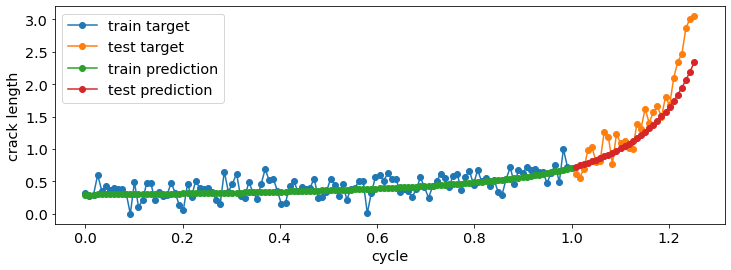

In [83]:
model = FullyConnectedExpDropout([1, 4, 4, 1], drop_proba=0.05, activation=nn.Tanh).to(device)
figs=[]
epochs = 10000
physics_coeff = 1

optim = torch.optim.Adam(model.parameters(), lr=1e-2, weight_decay=1e-6)
metric = train_model_physics_magnitude_norm(model, train_xtensor, train_ytensor, physics_xtensor, 
    train_xscaler_torch, train_yscaler_torch, paris_C, paris_m, paris_dsigma, epochs=epochs, physics_coeff=physics_coeff,
    optim=optim)

train_predictions, _ = predict_model(model, train_xtensor)
test_predictions, test_loss = predict_model(model, test_xtensor, test_ytensor)
# print(train_predictions.shape, test_predictions.shape)

# fig = plot_target_prediction(train_xscaled, train_yscaled, torch.exp(train_predictions), 
#                        test_xscaled, test_yscaled, torch.exp(test_predictions))
fig = plot_target_prediction(train_xtensor, train_ytensor, train_predictions, 
                       test_xtensor, test_ytensor, test_predictions)

print(f"{test_loss = }")

In [84]:
def enable_dropout(model):
    """ Enable dropout during test time """
    for module in model.modules():
        if isinstance(module, nn.Dropout):
            module.train()
    
    return model

def predict_dropout(model, sample_size, inputdata, targetdata=None):
    model.eval()
    model = enable_dropout(model)
    loss = None
    all_predictions = []
    
    with torch.no_grad():
        for iteration in range(sample_size):
            outputdata = model(inputdata.to(device))
    #         predictions = outputdata
            if targetdata is not None:
                loss = tnf.mse_loss(outputdata, targetdata.to(device)).detach().item()
                
            all_predictions.append(outputdata.detach().cpu().numpy())
        
    return np.stack(all_predictions, 0)

In [85]:
def plot_multiple_target_prediction(traininput, traintarget, trainprediction, testinput, testtarget, testprediction=None,
    title=None, figsize=(12, 4), marker="o"):
    
    fig = plt.figure(figsize=figsize)
    plt.plot(traininput, traintarget, label="train target", marker=marker)
    plt.plot(testinput, testtarget, label="test target", marker=marker) 
    plt.plot(traininput, trainprediction, label="train prediction", marker=marker)
            
    plt.plot([], [], label="test prediction", color="black")
    
    if testprediction is not None:
#         for sample_testprediction in testprediction:
# #             print(sample_testprediction.shape)
#             plt.plot(testinput, sample_testprediction, marker=marker, color="black", alpha=0.6)
        
        plt.plot(testinput, np.mean(testprediction, axis=0), marker=marker, color="black")
        high_quantile = np.quantile(testprediction, 0.975, axis=0)
        low_quantile = np.quantile(testprediction, 0.025, axis=0)
#         print(testinput.shape, high_quantile.shape, low_quantile.shape)
        plt.fill_between(testinput.squeeze(), low_quantile.squeeze(), high_quantile.squeeze(), color="black", alpha=0.3)
    
    plt.legend()    
    if title: plt.title(title)

    return fig

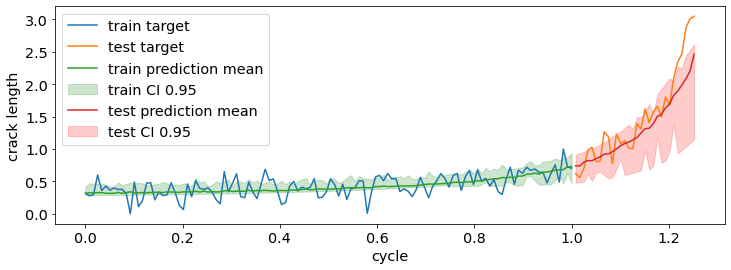

In [86]:
train_dropout_predictions = predict_dropout(model, 100, train_xtensor, train_ytensor) 
test_dropout_predictions = predict_dropout(model, 100, test_xtensor, test_ytensor)
# print(dropout_predictions.shape)

# fig = plot_multiple_target_prediction(train_xtensor, train_ytensor, train_predictions, 
#                        test_xtensor, test_ytensor, dropout_predictions, marker="")

fig = plot_target_prediction_sample(train_xtensor, train_ytensor, train_dropout_predictions, 
                       test_xtensor, test_ytensor, test_dropout_predictions, marker="")


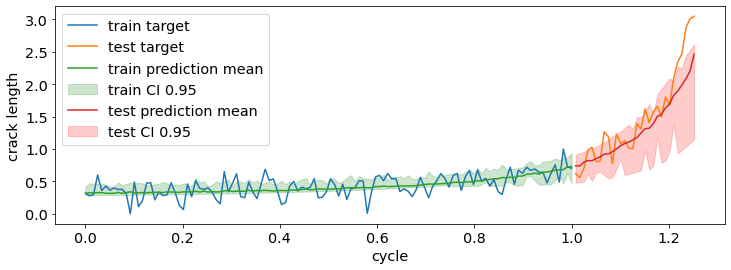

In [87]:
fig = plot_target_prediction_sample(train_xtensor, train_ytensor, train_dropout_predictions, 
                       test_xtensor, test_ytensor, test_dropout_predictions, marker="")

fig.savefig("probabilistic_prediction.png", bbox_inches="tight")

## Bayes by backprop

Plot evolution of parameters' Gaussian variance. More data and less noise should lead to smaller variance.

In [67]:
def mse_to_log_gaussian(mse, sigma):
    return float(-0.5 * np.log(2 * np.pi) - np.log(np.abs(sigma))) - mse / (2 * sigma**2)

def log_gaussian(x, mu, sigma):
    return float(-0.5 * np.log(2 * np.pi) - np.log(np.abs(sigma))) - (x - mu)**2 / (2 * sigma**2)

def log_gaussian_logsigma(x, mu, logsigma):
    return float(-0.5 * np.log(2 * np.pi)) - logsigma - (x - mu)**2 / (2 * torch.exp(logsigma)**2)

def sample_prediction(model, inputdata, targetdata=None, sample_size=10):
    model.eval()
    predictions = []

    with torch.no_grad():
        for sample_count in range(sample_size):
            prediction = model(inputdata.to(device), need_sample=True)
            predictions.append(prediction.detach().cpu())
    return torch.stack(predictions, dim=0)

def reparameterize_std(reparam_std):
    return torch.log1p(torch.exp(reparam_std))

In [68]:
def plot_metric(ax, metric, metrickey):
    return ax.plot(metric[metrickey], label=metrickey)
    
def plot_variational_training_metrics(metric, title=None, figsize=(20, 6)):

    fig, axes = plt.subplots(1, 2, figsize=(figsize))
    axes = axes.flatten()
    
    axes[0].set_xlabel("epoch")
    plot_metric(axes[0], metric, "logprior")
    plot_metric(axes[0], metric, "logproposal")
    axes[0].plot(metric["logproposal"] - metric["logprior"], label="KL divergence")
    axes[0].legend()

    plot_metric(axes[1], metric, "data_loglikelihood")
    plot_metric(axes[1], metric, "physics_loglikelihood")
    axes[1].plot(metric["data_loglikelihood"] + metric["physics_loglikelihood"], label="loglikelihood")
    axes[1].set_xlabel("epoch")
    axes[1].legend()  
        
    if title: plt.title(title)

    return fig    


In [69]:
# https://gist.github.com/vvanirudh/9e30b2f908e801da1bd789f4ce3e7aac
# https://github.com/cpark321/uncertainty-deep-learning/blob/master/01.%20Bayes-by-Backprop.ipynb

class GaussianLinear(nn.Module):
    def __init__(self, inputsize, outputsize, prior_std):
        super().__init__()
        self.inputsize = inputsize
        self.outputsize = outputsize
        self.prior_std = prior_std
        
        self.weight_mean = nn.Parameter(torch.Tensor(inputsize, outputsize).normal_(0, prior_std))
        self.weight_logstd = nn.Parameter(torch.Tensor(inputsize, outputsize).normal_(0, prior_std))
        
        self.bias_mean = nn.Parameter(torch.Tensor(outputsize).uniform_(-1, 1))
        self.bias_logstd = nn.Parameter(torch.Tensor(outputsize).uniform_(-1, 1))
        
        self.logprior = 0
        self.logproposal = 0
        self.normal01 = td.Normal(0,1)

    def forward(self, inputdata, need_sample=True):
        if not need_sample:
            output = torch.mm(inputdata, self.weight_mean) + self.bias_mean.expand(inputdata.size()[0], self.outputsize)
            return output
        
#         epsilon_W, epsilon_b = self.get_random()
        epsilon_weight = self.normal01.sample(self.weight_mean.shape).to(device)
        epsilon_bias = self.normal01.sample(self.bias_mean.shape).to(device)        
        weight = self.weight_mean + torch.log(1 + torch.exp(self.weight_logstd)) * epsilon_weight
        bias = self.bias_mean + torch.log(1 + torch.exp(self.bias_logstd)) * epsilon_bias
        
        output = torch.mm(inputdata, weight) + bias.expand(inputdata.size()[0], self.outputsize)
        self.logprior = log_gaussian(weight, 0, self.prior_std).sum() + log_gaussian(bias, 0, self.prior_std).sum()
        self.logproposal = log_gaussian_logsigma(weight, self.weight_mean, self.weight_logstd).sum() + log_gaussian_logsigma(bias, self.bias_mean, self.bias_logstd).sum()
        
        return output

#     def get_random(self):
#         return Variable(torch.Tensor(self.n_input, self.n_output).normal_(0, self.sigma_prior).cuda()), 
#             Variable(torch.Tensor(self.n_output).normal_(0, self.sigma_prior).cuda())


class GaussianMLP(nn.Module):
    def __init__(self, layer_size, likelihood_std=0.1, prior_std=1., activation=nn.ReLU, need_output_exp=False):
        super().__init__()
        self.prior_std = prior_std
        self.likelihood_std = likelihood_std
        self.need_output_exp = need_output_exp
        
        layers = []
        
        for i in range(len(layer_size) - 2):
            layers.append(GaussianLinear(layer_size[i], layer_size[i+1], prior_std))
            layers.append(activation())            
        
        self.layers = nn.Sequential(
            *layers,
            GaussianLinear(layer_size[-2], layer_size[-1], prior_std)
        )
    
    def forward(self, indata, need_sample=True):        
        outdata = indata
        for layer in self.layers:
            if isinstance(layer, GaussianLinear):
                outdata = layer(outdata, need_sample)
            else:
                outdata = layer(outdata)
        
        if self.need_output_exp: outdata = torch.exp(outdata)
        
        return outdata

#     def get_lpw_lqw(self):
#         lpw = self.l1.lpw + self.l2.lpw + self.l3.lpw
#         lqw = self.l1.lqw + self.l2.lqw + self.l3.lqw
#         return lpw, lqw

    def get_log_prior(self):
#         logprior = 0
#         for layer in self.layers:
#             if isinstance(layer, GaussianLinear):
#                 logprior += layer.logprior
        logprior = sum([layer.logprior for layer in self.layers if isinstance(layer, GaussianLinear)])
        return logprior

    def get_log_proposal(self):
        logproposal = sum([layer.logproposal for layer in self.layers if isinstance(layer, GaussianLinear)])
        return logproposal

    def forward_sample(inputdata, targetdata, sample_size=10):
                          
        samples_logprior, samples_logproposal, samples_loglikelihood = 0., 0., 0.

        for samplecount in range(sample_size):
            prediction = self.forward(inputdata)
    #         sample_log_pw, sample_log_qw = net.get_lpw_lqw()
    #         sample_log_likelihood = log_gaussian(y, output, sigma_prior).sum()

            samples_logprior += model.get_log_prior()
            samples_logproposal += model.get_log_proposal()
            samples_loglikelihood += log_gaussian(prediction, targetdata, self.likelihood_std).sum()

        return samples_logprior/sample_size, samples_logproposal/sample_size, samples_loglikelihood/sample_size


def elbo(l_pw, l_qw, l_likelihood):
    return ((1./n_batches) * (l_qw - l_pw) - l_likelihood).sum() / float(batch_size)


 Epoch 1 loss = 5.8613128662109375
data loss = dataloss=tensor(5.8613, grad_fn=<MseLossBackward0>) ; physics loss = 4.720663443480433e-11

 Epoch 1001 loss = 0.029242021963000298
data loss = dataloss=tensor(0.0292, grad_fn=<MseLossBackward0>) ; physics loss = 1.8411493440950721e-09

 Epoch 2001 loss = 0.028047777712345123
data loss = dataloss=tensor(0.0280, grad_fn=<MseLossBackward0>) ; physics loss = 4.709077572329079e-10

 Epoch 3001 loss = 0.02103533037006855
data loss = dataloss=tensor(0.0210, grad_fn=<MseLossBackward0>) ; physics loss = 5.555225168762945e-10

 Epoch 4001 loss = 0.02057410031557083
data loss = dataloss=tensor(0.0206, grad_fn=<MseLossBackward0>) ; physics loss = 5.448046458411682e-10

 Epoch 5001 loss = 0.020210811868309975
data loss = dataloss=tensor(0.0202, grad_fn=<MseLossBackward0>) ; physics loss = 6.579184974597752e-10

 Epoch 6001 loss = 0.021162962540984154
data loss = dataloss=tensor(0.0212, grad_fn=<MseLossBackward0>) ; physics loss = 9.873268869142748e-1

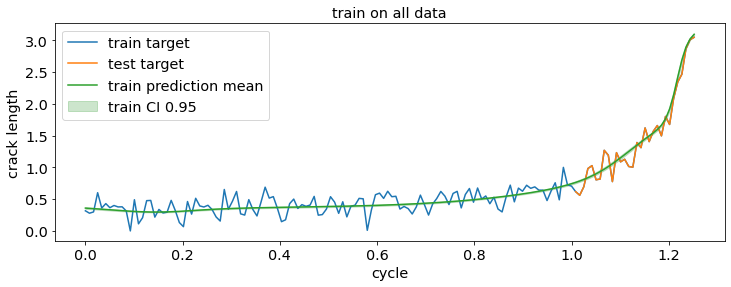

In [91]:
model = GaussianMLP([1, 4, 4, 1], activation=nn.Tanh).to(device)
figs=[]
epochs = 10000
physics_coeff = 1
# fig = plt.figure(1, figsize=(12,4))
losses = train_model_debug(model, torch.cat([train_xtensor, test_xtensor]), torch.cat([train_ytensor, test_ytensor]), physics_xtensor, 
    train_xscaler_torch, train_yscaler_torch, paris_C, paris_m, paris_dsigma, epochs=epochs, physics_coeff=physics_coeff)

train_predictions = sample_prediction(model, torch.cat([train_xtensor, test_xtensor]))
# test_predictions, test_loss = predict_model(model, test_xtensor, test_ytensor)
# print(train_predictions.shape, test_predictions.shape)

fig = plot_target_prediction_sample(torch.cat([train_xtensor, test_xtensor]), torch.cat([train_ytensor, test_ytensor]), train_predictions, 
                       test_xtensor, test_ytensor, title="train on all data", marker="")



 Epoch 1 loss = 0.22047187387943268
normalized data loss = 0.21047186851501465 ; normalized physics loss = 0.009999999776482582
data_norm = tensor(26.2073) differential_norm = tensor(3.1227e-06, grad_fn=<SumBackward0>)

 Epoch 1001 loss = 0.011665089055895805
normalized data loss = 0.0016650884645059705 ; normalized physics loss = 0.010000000707805157
data_norm = tensor(26.2073) differential_norm = tensor(6.1677e-07, grad_fn=<SumBackward0>)

 Epoch 2001 loss = 0.008313409052789211
normalized data loss = 0.00154314492829144 ; normalized physics loss = 0.006770264357328415
data_norm = tensor(26.2073) differential_norm = tensor(2.6852e-08, grad_fn=<SumBackward0>)

 Epoch 3001 loss = 0.0041666715405881405
normalized data loss = 0.0007592542679049075 ; normalized physics loss = 0.003407417330890894
data_norm = tensor(26.2073) differential_norm = tensor(4.0065e-07, grad_fn=<SumBackward0>)

 Epoch 4001 loss = 0.0028622241225093603
normalized data loss = 0.0015351739712059498 ; normalized phy

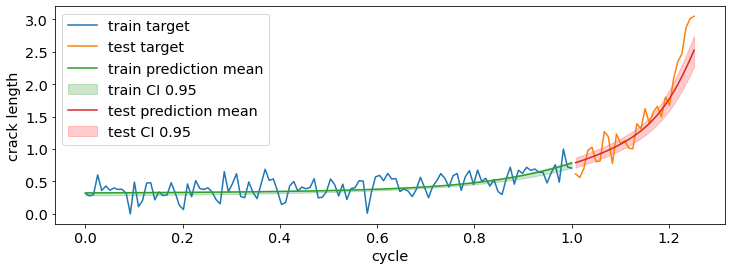

In [92]:
%%time

model = GaussianMLP([1, 4, 4, 1], likelihood_std=0.1, prior_std=0.1, activation=nn.Tanh).to(device)
figs=[]
epochs = 10000
physics_coeff = 1

optim = torch.optim.Adam(model.parameters(), lr=1e-2, weight_decay=1e-6)
metric_mse = train_model_physics_magnitude_norm(model, train_xtensor, train_ytensor, physics_xtensor, 
    train_xscaler_torch, train_yscaler_torch, paris_C, paris_m, paris_dsigma, epochs=epochs, physics_coeff=physics_coeff,
    optim=optim)

train_predictions = sample_prediction(model, train_xtensor, sample_size=10)
test_predictions = sample_prediction(model, test_xtensor, test_ytensor, sample_size=10)
# print(train_predictions.shape, test_predictions.shape)

fig = plot_target_prediction_sample(train_xtensor, train_ytensor, train_predictions, 
                       test_xtensor, test_ytensor, test_predictions, marker="")


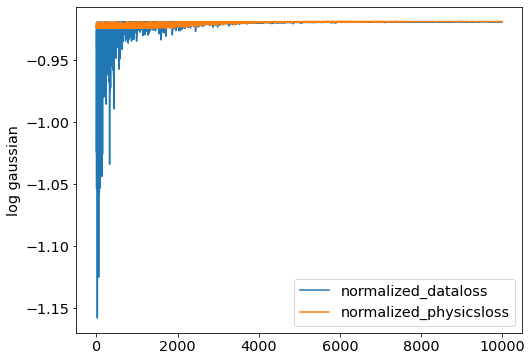

In [93]:

plt.figure(figsize=(8, 6))
plt.plot(mse_to_log_gaussian(metric_mse["normalized_dataloss"], 1), label="normalized_dataloss")
plt.plot(mse_to_log_gaussian(metric_mse["normalized_physicsloss"], 1), label="normalized_physicsloss")
plt.ylabel("log gaussian")
plt.legend()


 Epoch 1 loss = 0.030502423644065857
normalized data loss = 0.022273465991020203 ; normalized physics loss = 0.008228958584368229
data_norm = tensor(26.2073) differential_norm = tensor(6.5460e-06, grad_fn=<SumBackward0>)

 Epoch 1001 loss = 0.010318266227841377
normalized data loss = 0.0009907850762829185 ; normalized physics loss = 0.009327481500804424
data_norm = tensor(26.2073) differential_norm = tensor(5.2304e-08, grad_fn=<SumBackward0>)

 Epoch 2001 loss = 0.006010395009070635
normalized data loss = 0.0021019908599555492 ; normalized physics loss = 0.003908404149115086
data_norm = tensor(26.2073) differential_norm = tensor(1.4009e-08, grad_fn=<SumBackward0>)

 Epoch 3001 loss = 0.0022339532151818275
normalized data loss = 0.000729198451153934 ; normalized physics loss = 0.0015047546476125717
data_norm = tensor(26.2073) differential_norm = tensor(1.1099e-07, grad_fn=<SumBackward0>)

 Epoch 4001 loss = 0.0014944139402359724
normalized data loss = 0.000798839726485312 ; normalized 

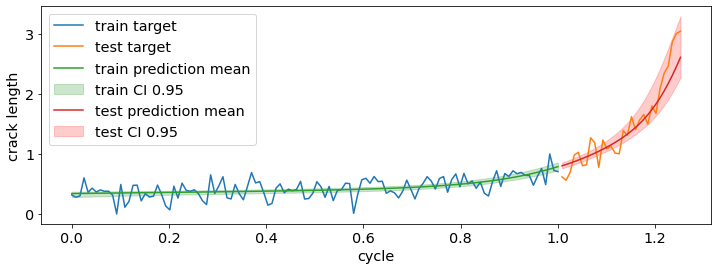

In [94]:
%%time

model = GaussianMLP([1, 4, 4, 1], likelihood_std=1, prior_std=1, activation=nn.Tanh).to(device)
figs=[]
epochs = 10000
physics_coeff = 1

optim = torch.optim.Adam(model.parameters(), lr=1e-2, weight_decay=1e-6)
metric_mse = train_model_physics_magnitude_norm(model, train_xtensor, train_ytensor, physics_xtensor, 
    train_xscaler_torch, train_yscaler_torch, paris_C, paris_m, paris_dsigma, epochs=epochs, physics_coeff=physics_coeff,
    optim=optim)

train_predictions = sample_prediction(model, train_xtensor, sample_size=10)
test_predictions = sample_prediction(model, test_xtensor, test_ytensor, sample_size=10)
# print(train_predictions.shape, test_predictions.shape)

fig = plot_target_prediction_sample(train_xtensor, train_ytensor, train_predictions, 
                       test_xtensor, test_ytensor, test_predictions, marker="")


In [70]:
def compute_data_physics_loss_gaussian_nn(paris_C, paris_m, paris_dsigma, model, inputdata, targetdata, inputphysics, 
    inputscaler, outputscaler, physics_coeff, sample_size=10):
    
    samples_logprior, samples_logproposal, data_samples_loglikelihood, physics_samples_loglikelihood = 0., 0., 0., 0.
    inputphysics.requires_grad_(True)
    
    for samplecount in range(sample_size):
        data_prediction = model.forward(inputdata)
        physics_prediction = model.forward(inputphysics)
        physics_constraint = 1 * paris_law(outputscaler.inverse(physics_prediction), paris_C, paris_m, paris_dsigma)    
        # print(f"{data_prediction = } \n {physics_prediction = } \n {physics_constraint = }")
        
        samples_logprior += model.get_log_prior()
        samples_logproposal += model.get_log_proposal()        
#         print(f"{samples_logprior = } {samples_logproposal = }")

        derivative = torch.autograd.grad(outputs=physics_prediction, inputs=inputphysics, 
            grad_outputs=torch.ones_like(inputphysics), retain_graph=True, create_graph=True)[0]
        rescaled_derivative = derivative * (outputscaler.max - outputscaler.min) / (inputscaler.max - inputscaler.min)
        
        differential_norm = torch.abs(rescaled_derivative) + torch.abs(physics_constraint)
        differential_norm = torch.sum(differential_norm**2)
        data_norm = torch.sum(targetdata**2)
        #         print(f"{data_norm = } {differential_norm = }")
        
        # print(f"{log_gaussian(targetdata, data_prediction, model.likelihood_std) = }")
        # data_samples_loglikelihood += log_gaussian(targetdata, data_prediction, model.likelihood_std).mean()
        # physics_samples_loglikelihood += log_gaussian(physics_constraint, rescaled_derivative, model.likelihood_std).mean()
        data_samples_loglikelihood += log_gaussian(data_prediction/torch.sqrt(data_norm), targetdata/torch.sqrt(data_norm), model.likelihood_std).mean()
        physics_samples_loglikelihood += log_gaussian(rescaled_derivative/torch.sqrt(differential_norm), physics_constraint/torch.sqrt(differential_norm), model.likelihood_std).mean()
#         print(f"{data_samples_loglikelihood = } {physics_samples_loglikelihood = }")
        
        # data_samples_loglikelihood += mse_to_log_gaussian(tnf.mse_loss(data_prediction, targetdata)/data_norm, model.likelihood_std)
        # physics_samples_loglikelihood += mse_to_log_gaussian(tnf.mse_loss(physics_prediction, physics_constraint)/differential_norm, model.likelihood_std)
        
    return samples_logprior/sample_size, samples_logproposal/sample_size, \
        data_samples_loglikelihood/sample_size, physics_samples_loglikelihood/sample_size

In [71]:
def train_model_physics_magnitude_norm_gaussian_nn(model, traininput, trainlabel, physicsinput, xscaler, yscaler, 
    paris_C , paris_m, paris_dsigma, epochs=5, physics_coeff=1, optim=None, verbose=True, sample_size=10, kldiv_coeff=1):
    
    if optim is None:
        optim = torch.optim.Adam(model.parameters(), lr=1e-1, weight_decay=1e-6)
    
    traininput = traininput.to(device)
    trainlabel = trainlabel.to(device)
    physicsinput = physicsinput.to(device)
#     scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, mode='min', 
#         factor=0.1, patience=10, threshold_mode="rel", threshold=1e-2, verbose=True)

    metric = {key: np.empty(epochs) for key in "data_loglikelihood physics_loglikelihood logprior logproposal".split()}
    model.train()
    
    for epoch in range(epochs):
        optim.zero_grad()
        loss = torch.zeros(1)
        
        logprior, logproposal, data_loglikelihood, physics_loglikelihood = compute_data_physics_loss_gaussian_nn(
            paris_C, paris_m, paris_dsigma, model, traininput, trainlabel, physicsinput, 
            xscaler, yscaler, physics_coeff=physics_coeff, sample_size=sample_size)
#             dataloss, physicsloss, rescaled_derivative, physics_constraint, physics_prediction = compute_data_physics_loss_gaussian_nn(paris_C, paris_m, paris_dsigma, 
#                model, traininput, trainlabel, physicsinput, xscaler, yscaler, physics_coeff=physics_coeff, sample_size=sample_size)

#             differential_norm = torch.abs(rescaled_derivative) + torch.abs(physics_constraint)
#             differential_norm = torch.sum(differential_norm**2)
#             data_norm = torch.sum(trainlabel**2)

#         elbo_datafit = data_loglikelihood + physics_loglikelihood
#         elbo_divergence = logproposal - logprior
#         elbo_loss = elbo_divergence - elbo_datafit
#         loss += elbo_loss
        loss = kldiv_coeff * (logproposal - logprior) - (data_loglikelihood + physics_loglikelihood)

        metric["data_loglikelihood"][epoch] = data_loglikelihood
        metric["physics_loglikelihood"][epoch] = physics_loglikelihood
        metric["logprior"][epoch] = logprior
        metric["logproposal"][epoch] = logproposal

#         metric["data_loglikelihood"][epoch][sample_count] = data_loglikelihood.detach().item()
#         metric["physics_loglikelihood"][epoch][sample_count] = physics_loglikelihood.detach().item()
#             metric["normalized_data_loglikelihood"][epoch][sample_count] = (data_loglikelihood / data_norm).detach().item()
#             metric["normalized_physics_loglikelihood"][epoch][sample_count] = (physics_loglikelihood / differential_norm).detach().item()
        
        loss.backward()
        optim.step()        
#         scheduler.step(loss)
                
        if verbose and (epochs < 10 or epoch % (epochs//10) == 0):
            print(f"\n Epoch {epoch+1} loss = {loss.detach().item()}") 
            print(f"{logprior = } ; {logproposal = } \n kl = {logproposal - logprior} ; log likelihood = {data_loglikelihood + physics_loglikelihood}")
            print(f"{data_loglikelihood = } {physics_loglikelihood = }")

#             print(f"normalized data loss = {(dataloss / data_norm).detach().item()} ; normalized physics loss = {(physicsloss / differential_norm).detach().item()}")
#             print(f"normalized data loss = {metric['normalized_data_loglikelihood'][epoch].mean()} ; normalized physics loss = {metric['normalized_physics_loglikelihood'][epoch].mean()}")
#             print(f"{data_norm = } {differential_norm = }")

#             figs.append(plot_twinx(tensor_to_array(xphysics), tensor_to_array(rescaled_derivative), "derivative",
#                 tensor_to_array(physics_constraint), "predictive paris"))#, paris_law(all_yscaled, paris_C, paris_m, paris_dsigma), "target paris"))

#             fig = plt.figure(figsize=(8,4))
#             plt.plot(tensor_to_array(physicsinput), tensor_to_array(rescaled_derivative), label="rescaled derivative", marker="o")
#             plt.plot(tensor_to_array(physicsinput), tensor_to_array(physics_constraint), label="paris", marker="o")
#             plt.legend()
#             figs.append(fig)
            
#             plt.close()            
            
    # metric["data_loglikelihood"] = metric["data_loglikelihood"].mean(1)
    # metric["physics_loglikelihood"] = metric["physics_loglikelihood"].mean(1)
#     metric["normalized_data_loglikelihood"] = metric["normalized_data_loglikelihood"].mean(1)
#     metric["normalized_physics_loglikelihood"] = metric["normalized_physics_loglikelihood"].mean(1)
    
    for metricname, metricvalue in metric.items():
        metric[metricname] = np.array(metricvalue)
    
    return metric

In [ ]:
%%time

model = GaussianMLP([1, 4, 4, 1], likelihood_std=0.1, prior_std=0.1, activation=nn.Tanh).to(device)
figs=[]
epochs = 10000
physics_coeff = 1

optim = torch.optim.Adam(model.parameters(), lr=1e-2, weight_decay=1e-6)
metric = train_model_physics_magnitude_norm_gaussian_nn(model, train_xtensor, train_ytensor, physics_xtensor, 
    train_xscaler_torch, train_yscaler_torch, paris_C, paris_m, paris_dsigma, epochs=epochs, physics_coeff=physics_coeff,
    optim=optim, sample_size=10, kldiv_coeff=1e-6)

train_predictions = sample_prediction(model, train_xtensor, sample_size=10)
test_predictions = sample_prediction(model, test_xtensor, test_ytensor, sample_size=10)
# print(train_predictions.shape, test_predictions.shape)

fig = plot_target_prediction_sample(train_xtensor, train_ytensor, train_predictions, 
                       test_xtensor, test_ytensor, test_predictions, marker="")



 Epoch 1 loss = 7.816163063049316
logprior = tensor(-1034.2679, grad_fn=<DivBackward0>) ; logproposal = tensor(-39.1759, grad_fn=<DivBackward0>) 
 kl = 995.092041015625 ; log likelihood = -7.8151679039001465
data_loglikelihood = tensor(-8.8160, grad_fn=<DivBackward0>) physics_loglikelihood = tensor(1.0009, grad_fn=<DivBackward0>)

 Epoch 1001 loss = -2.4903998374938965
logprior = tensor(-583.0081, grad_fn=<DivBackward0>) ; logproposal = tensor(-10.8255, grad_fn=<DivBackward0>) 
 kl = 572.1824951171875 ; log likelihood = 2.4909720420837402
data_loglikelihood = tensor(1.3065, grad_fn=<DivBackward0>) physics_loglikelihood = tensor(1.1845, grad_fn=<DivBackward0>)

 Epoch 2001 loss = -2.665165424346924
logprior = tensor(-1187.0789, grad_fn=<DivBackward0>) ; logproposal = tensor(7.3423, grad_fn=<DivBackward0>) 
 kl = 1194.421142578125 ; log likelihood = 2.6663599014282227
data_loglikelihood = tensor(1.3260, grad_fn=<DivBackward0>) physics_loglikelihood = tensor(1.3404, grad_fn=<DivBackward0

In [ ]:
fig = plot_variational_training_metrics(metric)

In [ ]:
plt.plot(metric["logproposal"])

In [99]:
# torch.save(model.state_dict(), os.path.join(saved_model_path, "gaussian_mlp_1.pt"))
           
# model = TheModelClass(*args, **kwargs)
# model.load_state_dict(torch.load(PATH))
# model.eval()


 Epoch 1 loss = 1.9860765933990479
logprior = tensor(-56.7769, grad_fn=<DivBackward0>) ; logproposal = tensor(-37.9399, grad_fn=<DivBackward0>) 
 kl = 18.837005615234375 ; log likelihood = -1.9860577583312988
data_loglikelihood = tensor(-1.0630, grad_fn=<DivBackward0>) physics_loglikelihood = tensor(-0.9231, grad_fn=<DivBackward0>)

 Epoch 1001 loss = 1.8437806367874146
logprior = tensor(-40.6247, grad_fn=<DivBackward0>) ; logproposal = tensor(-12.1133, grad_fn=<DivBackward0>) 
 kl = 28.511363983154297 ; log likelihood = -1.843752145767212
data_loglikelihood = tensor(-0.9221, grad_fn=<DivBackward0>) physics_loglikelihood = tensor(-0.9217, grad_fn=<DivBackward0>)

 Epoch 2001 loss = 1.8391685485839844
logprior = tensor(-41.3830, grad_fn=<DivBackward0>) ; logproposal = tensor(1.5353, grad_fn=<DivBackward0>) 
 kl = 42.9183464050293 ; log likelihood = -1.839125633239746
data_loglikelihood = tensor(-0.9196, grad_fn=<DivBackward0>) physics_loglikelihood = tensor(-0.9196, grad_fn=<DivBackwar

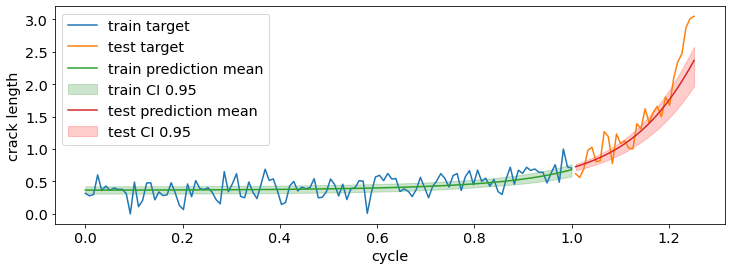

In [100]:
%%time

model = GaussianMLP([1, 4, 4, 1], likelihood_std=1, prior_std=1, activation=nn.Tanh).to(device)
figs=[]
epochs = 10000
physics_coeff = 1

optim = torch.optim.Adam(model.parameters(), lr=1e-2, weight_decay=1e-6)
metric = train_model_physics_magnitude_norm_gaussian_nn(model, train_xtensor, train_ytensor, physics_xtensor, 
    train_xscaler_torch, train_yscaler_torch, paris_C, paris_m, paris_dsigma, epochs=epochs, physics_coeff=physics_coeff,
    optim=optim, sample_size=10, kldiv_coeff=1e-6)

train_predictions = sample_prediction(model, train_xtensor, sample_size=10)
test_predictions = sample_prediction(model, test_xtensor, test_ytensor, sample_size=10)
# print(train_predictions.shape, test_predictions.shape)

fig = plot_target_prediction_sample(train_xtensor, train_ytensor, train_predictions, 
                       test_xtensor, test_ytensor, test_predictions, marker="")


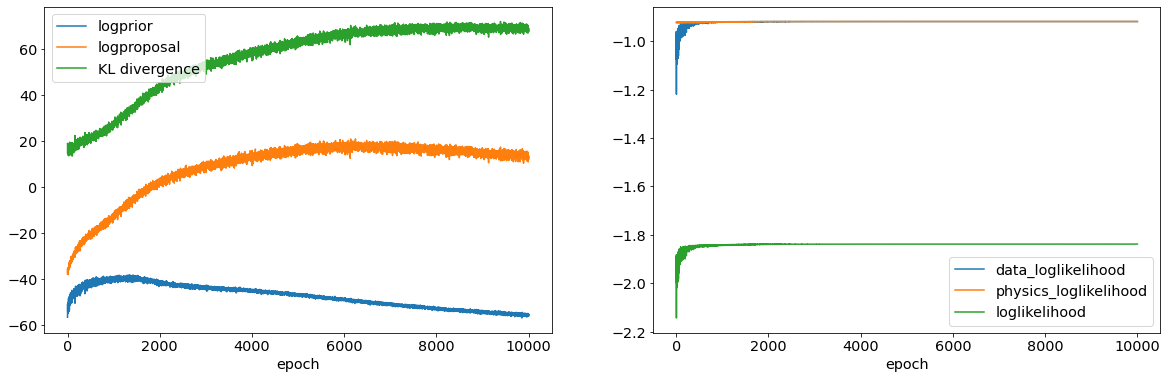

In [101]:
fig = plot_variational_training_metrics(metric)

In [72]:
def compute_data_physics_loss_debug(paris_C, paris_m, paris_dsigma, model, inputdata, targetdata, inputphysics, 
    inputscaler, outputscaler, physics_coeff, need_sample=True):
    
    data_prediction = model.forward(inputdata, need_sample)
    dataloss = tnf.mse_loss(data_prediction, targetdata)

    inputphysics.requires_grad_(True)
    prediction_physics = model.forward(inputphysics, need_sample)       

    derivative = torch.autograd.grad(outputs=prediction_physics, inputs=inputphysics, 
        grad_outputs=torch.ones_like(inputphysics), retain_graph=True, create_graph=True)[0]
    rescaled_derivative = derivative * (outputscaler.max - outputscaler.min) / (inputscaler.max - inputscaler.min)
    
    physics_constraint = 1 * paris_law(outputscaler.inverse(prediction_physics), paris_C, paris_m, paris_dsigma)
    physicsloss = physics_coeff * (rescaled_derivative - physics_constraint)**2
    
    return dataloss, torch.mean(physicsloss), rescaled_derivative, physics_constraint, prediction_physics

def compute_data_physics_loss_gaussian_nn_debug(paris_C, paris_m, paris_dsigma, model, inputdata, targetdata, inputphysics, 
    inputscaler, outputscaler, physics_coeff, sample_size=10):
    
    samples_logprior, samples_logproposal, data_samples_loglikelihood, physics_samples_loglikelihood = 0., 0., 0., 0.
    inputphysics.requires_grad_(True)
    
    for samplecount in range(sample_size):
        data_prediction = model.forward(inputdata, need_sample=False)
        physics_prediction = model.forward(inputphysics, need_sample=False)
        physics_constraint = 1 * paris_law(outputscaler.inverse(physics_prediction), paris_C, paris_m, paris_dsigma)    
        
        samples_logprior += model.get_log_prior()
        samples_logproposal += model.get_log_proposal()        

        derivative = torch.autograd.grad(outputs=physics_prediction, inputs=inputphysics, 
            grad_outputs=torch.ones_like(inputphysics), retain_graph=True, create_graph=True)[0]
        rescaled_derivative = derivative * (outputscaler.max - outputscaler.min) / (inputscaler.max - inputscaler.min)
        
        differential_norm = torch.abs(rescaled_derivative) + torch.abs(physics_constraint)
        differential_norm = torch.sum(differential_norm**2)
        data_norm = torch.sum(targetdata**2)

        data_samples_loglikelihood += log_gaussian(data_prediction/torch.sqrt(data_norm), targetdata/torch.sqrt(data_norm), model.likelihood_std).mean()
        physics_samples_loglikelihood += log_gaussian(rescaled_derivative/torch.sqrt(differential_norm), physics_constraint/torch.sqrt(differential_norm), model.likelihood_std).mean()
                    
    return samples_logprior/sample_size, samples_logproposal/sample_size, \
        data_samples_loglikelihood/sample_size, physics_samples_loglikelihood/sample_size

In [73]:
def train_model_physics_magnitude_norm_gaussian_nn_debug(model, traininput, trainlabel, physicsinput, xscaler, yscaler, 
    paris_C , paris_m, paris_dsigma, epochs=5, physics_coeff=1, optim=None, verbose=True, sample_size=10, kldiv_coeff=1):
    
    if optim is None:
        optim = torch.optim.Adam(model.parameters(), lr=1e-1, weight_decay=1e-6)
    
    traininput = traininput.to(device)
    trainlabel = trainlabel.to(device)
    physicsinput = physicsinput.to(device)
#     scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, mode='min', 
#         factor=0.1, patience=10, threshold_mode="rel", threshold=1e-2, verbose=True)

    metric = dict(dataloss=[], physicsloss=[], normalized_dataloss=[], normalized_physicsloss=[], 
        data_loglikelihood=np.empty(epochs), physics_loglikelihood=np.empty(epochs), logprior=np.empty(epochs), logproposal=np.empty(epochs))
    # metric = dict(data_loglikelihood=np.empty(epochs), physics_loglikelihood=np.empty(epochs), 
    #     logprior=np.empty(epochs), logproposal=np.empty(epochs))

    model.train()
    
    for epoch in range(epochs):
        optim.zero_grad()
               
        dataloss, physicsloss, rescaled_derivative, physics_constraint, physics_prediction = compute_data_physics_loss_debug(paris_C, paris_m, paris_dsigma, 
           model, traininput, trainlabel, physicsinput, xscaler, yscaler, physics_coeff=physics_coeff, need_sample=sample_size > 1)
        
        differential_norm = torch.abs(rescaled_derivative) + torch.abs(physics_constraint)
        differential_norm = torch.sum(differential_norm**2)
        data_norm = torch.sum(trainlabel**2)

        loss = dataloss / data_norm + physicsloss / differential_norm
        
        metric["dataloss"].append(dataloss.detach().item())
        metric["physicsloss"].append(physicsloss.detach().item())
        metric["normalized_dataloss"].append((dataloss / data_norm).detach().item())
        metric["normalized_physicsloss"].append((physicsloss / differential_norm).detach().item())
       
        loss.backward()
        optim.step()        
#         scheduler.step(loss)
        
        logprior, logproposal, data_loglikelihood, physics_loglikelihood = compute_data_physics_loss_gaussian_nn_debug(
            paris_C, paris_m, paris_dsigma, model, traininput, trainlabel, physicsinput, 
            xscaler, yscaler, physics_coeff=physics_coeff, sample_size=sample_size)
                
        negative_elbo = kldiv_coeff * (logproposal - logprior) - (data_loglikelihood + physics_loglikelihood)
            
        metric["data_loglikelihood"][epoch] = data_loglikelihood
        metric["physics_loglikelihood"][epoch] = physics_loglikelihood
        metric["logprior"][epoch] = logprior
        metric["logproposal"][epoch] = logproposal

        if verbose and (epochs < 10 or epoch % (epochs//10) == 0):
            print(f"\n Epoch {epoch+1} loss = {loss.detach().item()}") 
            print(f"normalized data loss = {metric['normalized_dataloss'][-1]} ; normalized physics loss = {metric['normalized_physicsloss'][-1]}")
            print(f"{data_norm = } {differential_norm = }")

            print(f"{negative_elbo = }")
            print(f"{logprior = } ; {logproposal = } \n kl = {logproposal - logprior} ; log likelihood = {data_loglikelihood + physics_loglikelihood}")
            print(f"{data_loglikelihood = } {physics_loglikelihood = }")

#             figs.append(plot_twinx(tensor_to_array(xphysics), tensor_to_array(rescaled_derivative), "derivative",
#                 tensor_to_array(physics_constraint), "predictive paris"))#, paris_law(all_yscaled, paris_C, paris_m, paris_dsigma), "target paris"))

#             fig = plt.figure(figsize=(8,4))
#             plt.plot(tensor_to_array(physicsinput), tensor_to_array(rescaled_derivative), label="rescaled derivative", marker="o")
#             plt.plot(tensor_to_array(physicsinput), tensor_to_array(physics_constraint), label="paris", marker="o")
#             plt.legend()
#             figs.append(fig)
            
#             plt.close()            
            
    
    for metricname, metricvalue in metric.items():
        metric[metricname] = np.array(metricvalue)
    
    return metric


 Epoch 1 loss = 0.0470084473490715
normalized data loss = 0.03948020935058594 ; normalized physics loss = 0.007528237067162991
data_norm = tensor(26.2073) differential_norm = tensor(1.5099e-07, grad_fn=<SumBackward0>)
negative_elbo = tensor(662.3823, grad_fn=<SubBackward0>)
logprior = tensor(-701.0291, grad_fn=<DivBackward0>) ; logproposal = tensor(-36.5045, grad_fn=<DivBackward0>) 
 kl = 664.5245971679688 ; log likelihood = 2.142305374145508
data_loglikelihood = tensor(1.2482, grad_fn=<DivBackward0>) physics_loglikelihood = tensor(0.8941, grad_fn=<DivBackward0>)

 Epoch 1001 loss = 0.0011248590890318155
normalized data loss = 0.0007225782610476017 ; normalized physics loss = 0.00040228079888038337
data_norm = tensor(26.2073) differential_norm = tensor(2.9618e-07, grad_fn=<SumBackward0>)
negative_elbo = tensor(1491.7445, grad_fn=<SubBackward0>)
logprior = tensor(-1489.8409, grad_fn=<DivBackward0>) ; logproposal = tensor(4.6079, grad_fn=<DivBackward0>) 
 kl = 1494.4488525390625 ; log l

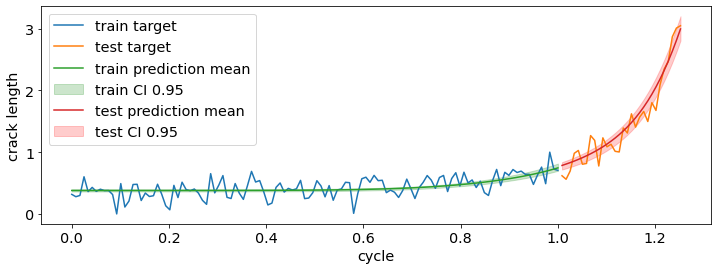

In [104]:
model = GaussianMLP([1, 4, 4, 1], likelihood_std=0.1, prior_std=0.1, activation=nn.Tanh).to(device)
figs=[]
epochs = 10000
physics_coeff = 1

optim = torch.optim.Adam(model.parameters(), lr=1e-1, weight_decay=1e-6)
metric_debug = train_model_physics_magnitude_norm_gaussian_nn_debug(model, train_xtensor, train_ytensor, physics_xtensor, 
    train_xscaler_torch, train_yscaler_torch, paris_C, paris_m, paris_dsigma, epochs=epochs, physics_coeff=physics_coeff,
    optim=optim)

train_predictions = sample_prediction(model, train_xtensor, sample_size=10)
test_predictions = sample_prediction(model, test_xtensor, test_ytensor, sample_size=10)
# print(train_predictions.shape, test_predictions.shape)

fig = plot_target_prediction_sample(train_xtensor, train_ytensor, train_predictions, 
                       test_xtensor, test_ytensor, test_predictions, marker="")


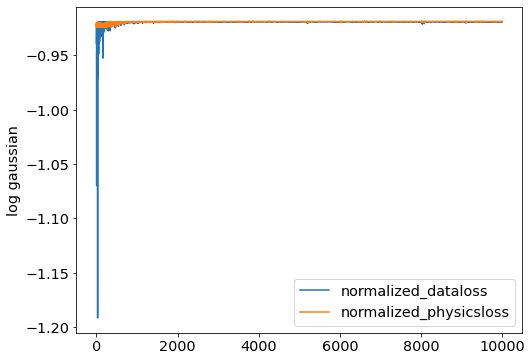

In [105]:
plt.figure(figsize=(8, 6))
plt.plot(mse_to_log_gaussian(metric_debug["normalized_dataloss"], 1), label="normalized_dataloss")
plt.plot(mse_to_log_gaussian(metric_debug["normalized_physicsloss"], 1), label="normalized_physicsloss")
plt.ylabel("log gaussian")
plt.legend()

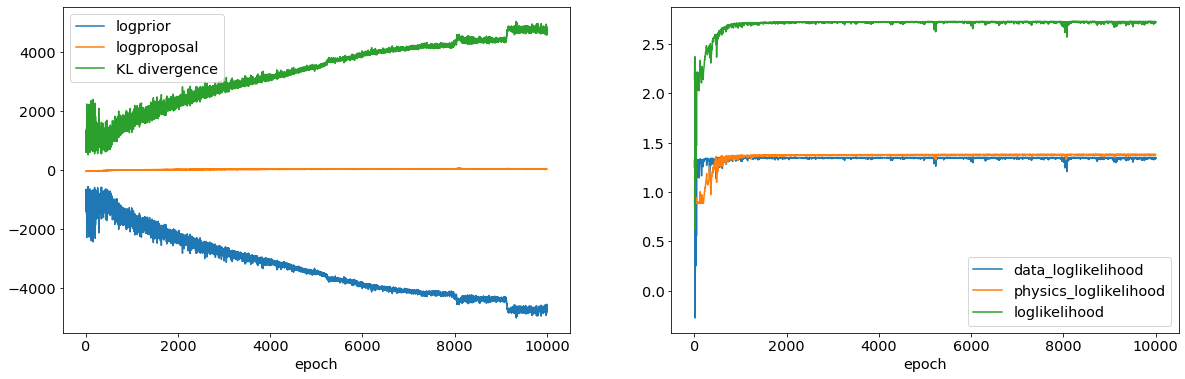

In [106]:
fig = plot_variational_training_metrics(metric_debug)


 Epoch 1 loss = 0.011202128604054451
normalized data loss = 0.0012021285947412252 ; normalized physics loss = 0.009999999776482582
data_norm = tensor(26.2073) differential_norm = tensor(2.0850e-08, grad_fn=<SumBackward0>)
negative_elbo = tensor(-2.0857, grad_fn=<RsubBackward1>)
logprior = 0.0 ; logproposal = 0.0 
 kl = 0.0 ; log likelihood = 2.0857419967651367
data_loglikelihood = tensor(1.2021, grad_fn=<DivBackward0>) physics_loglikelihood = tensor(0.8836, grad_fn=<DivBackward0>)

 Epoch 101 loss = 0.0011692247353494167
normalized data loss = 0.0007443843060173094 ; normalized physics loss = 0.0004248404293321073
data_norm = tensor(26.2073) differential_norm = tensor(4.0304e-07, grad_fn=<SumBackward0>)
negative_elbo = tensor(-2.7094, grad_fn=<RsubBackward1>)
logprior = 0.0 ; logproposal = 0.0 
 kl = 0.0 ; log likelihood = 2.709378242492676
data_loglikelihood = tensor(1.3441, grad_fn=<DivBackward0>) physics_loglikelihood = tensor(1.3652, grad_fn=<DivBackward0>)

 Epoch 201 loss = 0.00

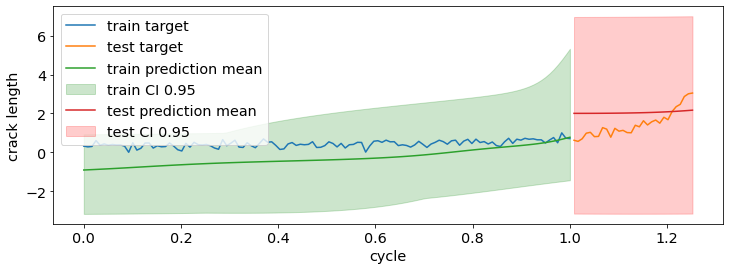

In [107]:
# no sampling, just the mean
model = GaussianMLP([1, 4, 4, 1], likelihood_std=0.1, prior_std=0.1, activation=nn.Tanh).to(device)
figs=[]
epochs = 1000
physics_coeff = 1

optim = torch.optim.Adam(model.parameters(), lr=1e-1, weight_decay=1e-6)
metric_mse = train_model_physics_magnitude_norm_gaussian_nn_debug(model, train_xtensor, train_ytensor, physics_xtensor, 
    train_xscaler_torch, train_yscaler_torch, paris_C, paris_m, paris_dsigma, epochs=epochs, physics_coeff=physics_coeff,
    optim=optim, sample_size=1)

train_predictions = sample_prediction(model, train_xtensor, sample_size=10)
test_predictions = sample_prediction(model, test_xtensor, test_ytensor, sample_size=10)
# print(train_predictions.shape, test_predictions.shape)

fig = plot_target_prediction_sample(train_xtensor, train_ytensor, train_predictions, 
                       test_xtensor, test_ytensor, test_predictions, marker="")


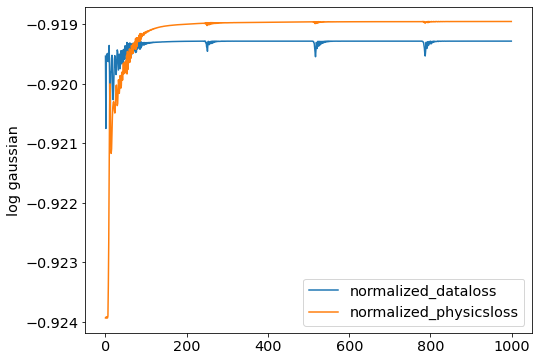

In [108]:
plt.figure(figsize=(8, 6))
plt.plot(mse_to_log_gaussian(metric_mse["normalized_dataloss"], 1), label="normalized_dataloss")
plt.plot(mse_to_log_gaussian(metric_mse["normalized_physicsloss"], 1), label="normalized_physicsloss")
plt.ylabel("log gaussian")
plt.legend()

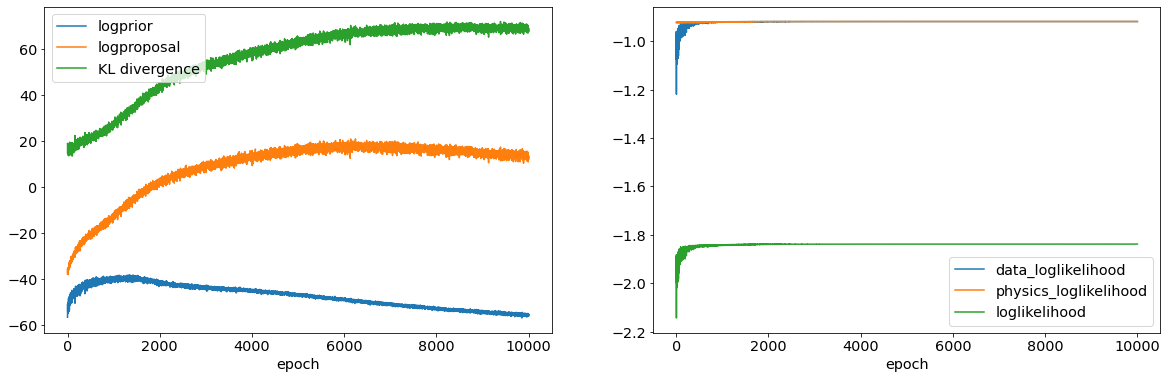

In [109]:
fig = plot_variational_training_metrics(metric)


 Epoch 1 loss = 159.90762329101562
logprior = tensor(-979.9662, grad_fn=<DivBackward0>) ; logproposal = tensor(-38.2865, grad_fn=<DivBackward0>) 
 kl = 941.6796875 ; log likelihood = -159.90667724609375
data_loglikelihood = tensor(-160.8561, grad_fn=<DivBackward0>) physics_loglikelihood = tensor(0.9495, grad_fn=<DivBackward0>)

 Epoch 1001 loss = 1.0023866891860962
logprior = tensor(-802.2821, grad_fn=<DivBackward0>) ; logproposal = tensor(-33.4780, grad_fn=<DivBackward0>) 
 kl = 768.8040771484375 ; log likelihood = -1.0016179084777832
data_loglikelihood = tensor(-1.9348, grad_fn=<DivBackward0>) physics_loglikelihood = tensor(0.9331, grad_fn=<DivBackward0>)

 Epoch 2001 loss = -2.138336181640625
logprior = tensor(-855.6771, grad_fn=<DivBackward0>) ; logproposal = tensor(-31.2810, grad_fn=<DivBackward0>) 
 kl = 824.3961791992188 ; log likelihood = 2.139160633087158
data_loglikelihood = tensor(1.1854, grad_fn=<DivBackward0>) physics_loglikelihood = tensor(0.9538, grad_fn=<DivBackward0>)

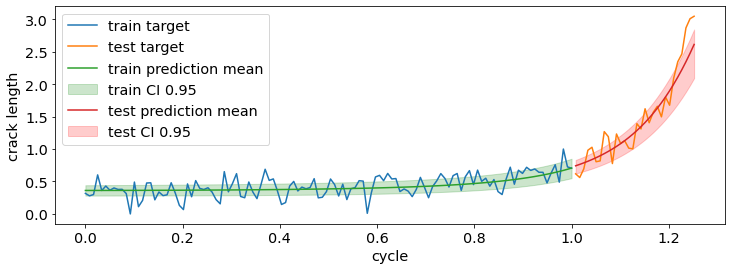

In [110]:
%%time

model = GaussianMLP([1, 4, 4, 1], likelihood_std=0.1, prior_std=0.1, activation=nn.Tanh, need_output_exp=True).to(device)
figs=[]
epochs = 10000
physics_coeff = 1

optim = torch.optim.Adam(model.parameters(), lr=1e-2, weight_decay=1e-6)
metric = train_model_physics_magnitude_norm_gaussian_nn(model, train_xtensor, train_ytensor, physics_xtensor, 
    train_xscaler_torch, train_yscaler_torch, paris_C, paris_m, paris_dsigma, epochs=epochs, physics_coeff=physics_coeff,
    optim=optim, sample_size=10, kldiv_coeff=1e-6)

train_predictions = sample_prediction(model, train_xtensor, sample_size=10)
test_predictions = sample_prediction(model, test_xtensor, test_ytensor, sample_size=10)
# print(train_predictions.shape, test_predictions.shape)

fig = plot_target_prediction_sample(train_xtensor, train_ytensor, train_predictions, 
                       test_xtensor, test_ytensor, test_predictions, marker="")


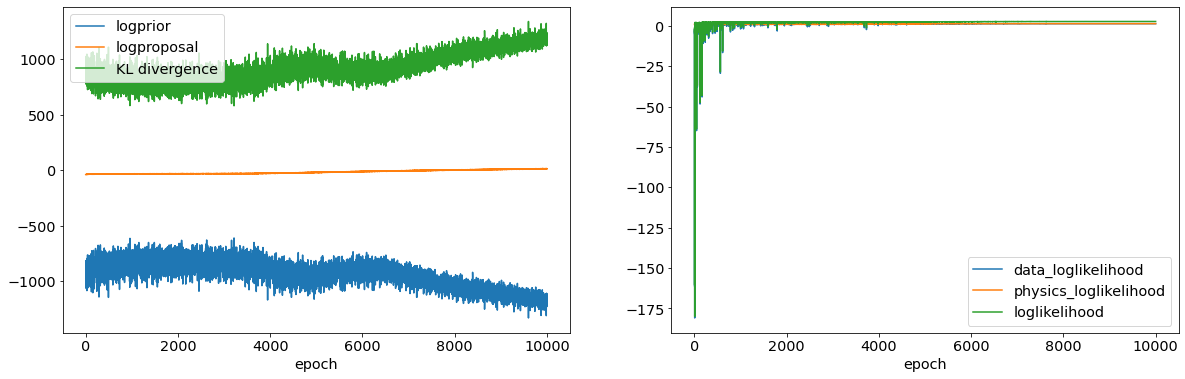

In [111]:
fig = plot_variational_training_metrics(metric)


 Epoch 1 loss = 0.6858266592025757
logprior = tensor(-1016.0873, grad_fn=<DivBackward0>) ; logproposal = tensor(-37.5478, grad_fn=<DivBackward0>) 
 kl = 978.5394897460938 ; log likelihood = -0.6760412454605103
data_loglikelihood = tensor(-1.6237, grad_fn=<DivBackward0>) physics_loglikelihood = tensor(0.9477, grad_fn=<DivBackward0>)

 Epoch 1001 loss = -2.503217935562134
logprior = tensor(-437.2404, grad_fn=<DivBackward0>) ; logproposal = tensor(-4.0964, grad_fn=<DivBackward0>) 
 kl = 433.1440124511719 ; log likelihood = 2.507549285888672
data_loglikelihood = tensor(1.2849, grad_fn=<DivBackward0>) physics_loglikelihood = tensor(1.2227, grad_fn=<DivBackward0>)

 Epoch 2001 loss = -2.6801598072052
logprior = tensor(-980.4032, grad_fn=<DivBackward0>) ; logproposal = tensor(11.3535, grad_fn=<DivBackward0>) 
 kl = 991.7567138671875 ; log likelihood = 2.690077304840088
data_loglikelihood = tensor(1.3374, grad_fn=<DivBackward0>) physics_loglikelihood = tensor(1.3527, grad_fn=<DivBackward0>)



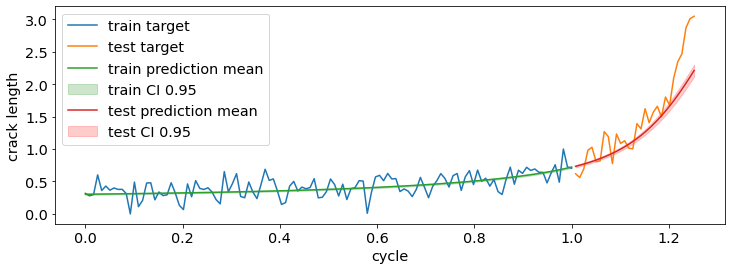

In [112]:
%%time

model = GaussianMLP([1, 4, 4, 1], likelihood_std=0.1, prior_std=0.1, activation=nn.Tanh).to(device)
figs=[]
epochs = 10000
physics_coeff = 1

optim = torch.optim.Adam(model.parameters(), lr=1e-2, weight_decay=1e-6)
metric = train_model_physics_magnitude_norm_gaussian_nn(model, train_xtensor, train_ytensor, physics_xtensor, 
    train_xscaler_torch, train_yscaler_torch, paris_C, paris_m, paris_dsigma, epochs=epochs, physics_coeff=physics_coeff,
    optim=optim, sample_size=10, kldiv_coeff=1e-5)

train_predictions = sample_prediction(model, train_xtensor, sample_size=10)
test_predictions = sample_prediction(model, test_xtensor, test_ytensor, sample_size=10)
# print(train_predictions.shape, test_predictions.shape)

fig = plot_target_prediction_sample(train_xtensor, train_ytensor, train_predictions, 
                       test_xtensor, test_ytensor, test_predictions, marker="")


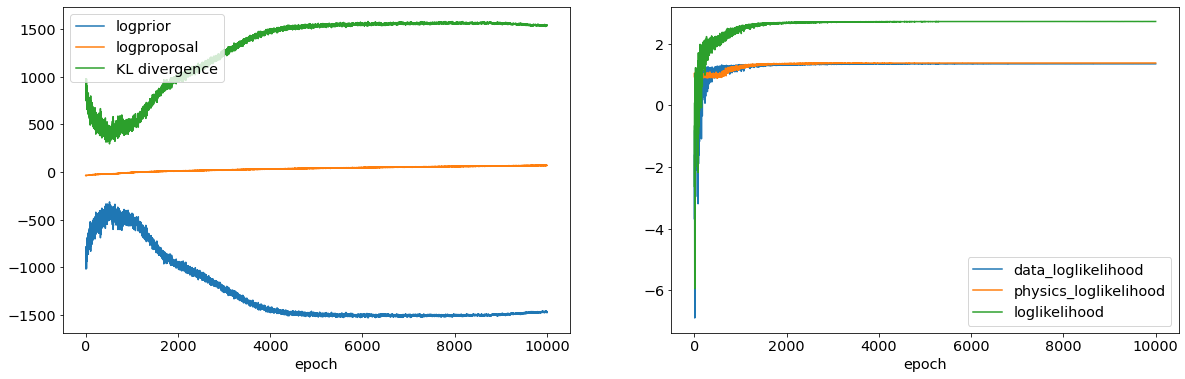

In [113]:
fig = plot_variational_training_metrics(metric)


 Epoch 1 loss = -1.7974351644515991
logprior = tensor(-903.6749, grad_fn=<DivBackward0>) ; logproposal = tensor(-36.6643, grad_fn=<DivBackward0>) 
 kl = 867.0106201171875 ; log likelihood = 1.7975218296051025
data_loglikelihood = tensor(0.7550, grad_fn=<DivBackward0>) physics_loglikelihood = tensor(1.0425, grad_fn=<DivBackward0>)

 Epoch 1001 loss = -2.5757317543029785
logprior = tensor(-437.4589, grad_fn=<DivBackward0>) ; logproposal = tensor(0.1101, grad_fn=<DivBackward0>) 
 kl = 437.56903076171875 ; log likelihood = 2.575775623321533
data_loglikelihood = tensor(1.3018, grad_fn=<DivBackward0>) physics_loglikelihood = tensor(1.2739, grad_fn=<DivBackward0>)

 Epoch 2001 loss = -2.6846470832824707
logprior = tensor(-1269.8998, grad_fn=<DivBackward0>) ; logproposal = tensor(17.5876, grad_fn=<DivBackward0>) 
 kl = 1287.4874267578125 ; log likelihood = 2.6847758293151855
data_loglikelihood = tensor(1.3364, grad_fn=<DivBackward0>) physics_loglikelihood = tensor(1.3483, grad_fn=<DivBackward

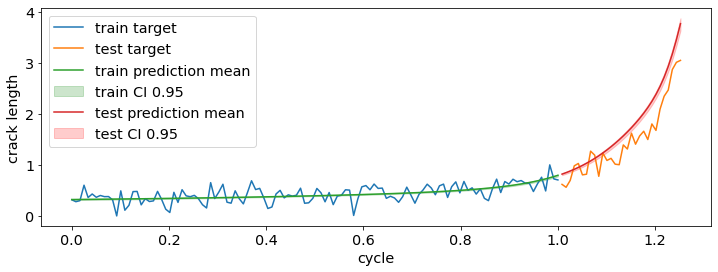

In [114]:
%%time

model = GaussianMLP([1, 4, 4, 1], likelihood_std=0.1, prior_std=0.1, activation=nn.Tanh).to(device)
figs=[]
epochs = 10000
physics_coeff = 1

optim = torch.optim.Adam(model.parameters(), lr=1e-2, weight_decay=1e-6)
metric = train_model_physics_magnitude_norm_gaussian_nn(model, train_xtensor, train_ytensor, physics_xtensor, 
    train_xscaler_torch, train_yscaler_torch, paris_C, paris_m, paris_dsigma, epochs=epochs, physics_coeff=physics_coeff,
    optim=optim, sample_size=10, kldiv_coeff=1e-7)

train_predictions = sample_prediction(model, train_xtensor, sample_size=10)
test_predictions = sample_prediction(model, test_xtensor, test_ytensor, sample_size=10)
# print(train_predictions.shape, test_predictions.shape)

fig = plot_target_prediction_sample(train_xtensor, train_ytensor, train_predictions, 
                       test_xtensor, test_ytensor, test_predictions, marker="")


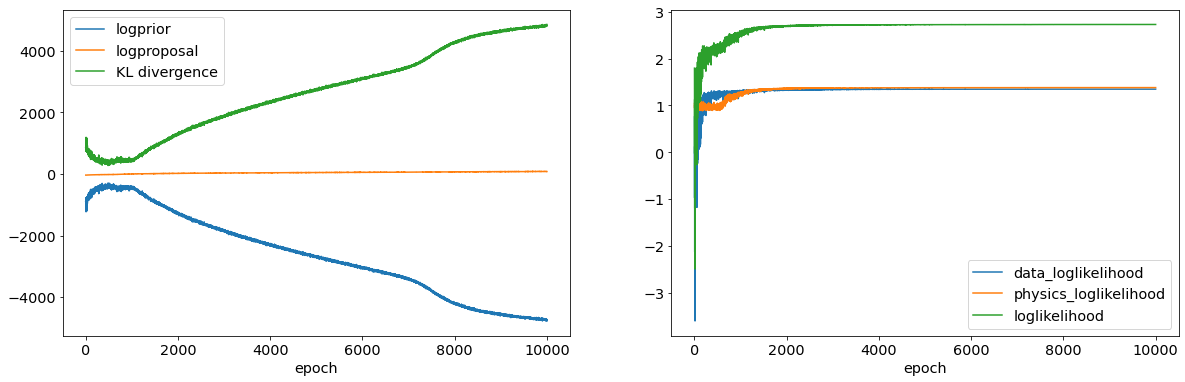

In [115]:
fig = plot_variational_training_metrics(metric)


 Epoch 1 loss = 4.763360500335693
logprior = tensor(-1076.5250, grad_fn=<DivBackward0>) ; logproposal = tensor(-40.1416, grad_fn=<DivBackward0>) 
 kl = 1036.3834228515625 ; log likelihood = -4.659722328186035
data_loglikelihood = tensor(-5.6101, grad_fn=<DivBackward0>) physics_loglikelihood = tensor(0.9504, grad_fn=<DivBackward0>)

 Epoch 1001 loss = -2.496668577194214
logprior = tensor(-356.6952, grad_fn=<DivBackward0>) ; logproposal = tensor(-2.8871, grad_fn=<DivBackward0>) 
 kl = 353.80810546875 ; log likelihood = 2.5320494174957275
data_loglikelihood = tensor(1.3040, grad_fn=<DivBackward0>) physics_loglikelihood = tensor(1.2281, grad_fn=<DivBackward0>)

 Epoch 2001 loss = -2.602379322052002
logprior = tensor(-553.5103, grad_fn=<DivBackward0>) ; logproposal = tensor(14.3182, grad_fn=<DivBackward0>) 
 kl = 567.8284301757812 ; log likelihood = 2.6591622829437256
data_loglikelihood = tensor(1.3337, grad_fn=<DivBackward0>) physics_loglikelihood = tensor(1.3255, grad_fn=<DivBackward0>)


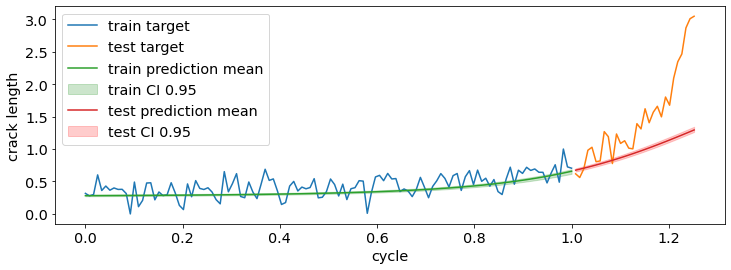

In [74]:
%%time

model = GaussianMLP([1, 4, 4, 1], likelihood_std=0.1, prior_std=0.1, activation=nn.Tanh).to(device)
figs=[]
epochs = 10000
physics_coeff = 1

optim = torch.optim.Adam(model.parameters(), lr=1e-2, weight_decay=1e-6)
metric = train_model_physics_magnitude_norm_gaussian_nn(model, train_xtensor, train_ytensor, physics_xtensor, 
    train_xscaler_torch, train_yscaler_torch, paris_C, paris_m, paris_dsigma, epochs=epochs, physics_coeff=physics_coeff,
    optim=optim, sample_size=10, kldiv_coeff=1e-4)

train_predictions = sample_prediction(model, train_xtensor, sample_size=10)
test_predictions = sample_prediction(model, test_xtensor, test_ytensor, sample_size=10)
# print(train_predictions.shape, test_predictions.shape)

fig = plot_target_prediction_sample(train_xtensor, train_ytensor, train_predictions, 
                       test_xtensor, test_ytensor, test_predictions, marker="")


In [117]:
model = GaussianMLP([1, 4, 4, 1], likelihood_std=0.1, prior_std=0.1, activation=nn.Tanh).to(device)
figs=[]
epochs = 1
physics_coeff = 1

optim = torch.optim.Adam(model.parameters(), lr=1e-2, weight_decay=1e-6)


In [118]:
%lprun -f train_model_physics_magnitude_norm_gaussian_nn train_model_physics_magnitude_norm_gaussian_nn(model, train_xtensor, train_ytensor, physics_xtensor, \
train_xscaler_torch, train_yscaler_torch, paris_C, paris_m, paris_dsigma, epochs=epochs, physics_coeff=physics_coeff,\
optim=optim, sample_size=10, kldiv_coeff=1e-7)


 Epoch 1 loss = 2.6882359981536865
logprior = tensor(-1380.5508, grad_fn=<DivBackward0>) ; logproposal = tensor(-42.9098, grad_fn=<DivBackward0>) 
 kl = 1337.6409912109375 ; log likelihood = -2.6881022453308105
data_loglikelihood = tensor(-3.6109, grad_fn=<DivBackward0>) physics_loglikelihood = tensor(0.9228, grad_fn=<DivBackward0>)


Timer unit: 1e-06 s

Total time: 0.03957 s
File: /tmp/ipykernel_12371/4170980669.py
Function: train_model_physics_magnitude_norm_gaussian_nn at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def train_model_physics_magnitude_norm_gaussian_nn(model, traininput, trainlabel, physicsinput, xscaler, yscaler, 
     2                                               paris_C , paris_m, paris_dsigma, epochs=5, physics_coeff=1, optim=None, verbose=True, sample_size=10, kldiv_coeff=1):
     3                                               
     4         1          2.0      2.0      0.0      if optim is None:
     5                                                   optim = torch.optim.Adam(model.parameters(), lr=1e-1, weight_decay=1e-6)
     6                                               
     7         1         11.0     11.0      0.0      traininput = traininput.to(device)
     8         1          4.0      4.0      0.0      

## Deep ensemble basic

In [119]:
def plot_target_prediction_ensemble(traininput, traintarget, testinput, testtarget, ensemble,
    title=None, figsize=(12, 4), marker=None):
    
    fig = plt.figure(figsize=figsize)
    plt.plot(traininput, traintarget, label="train target", marker=marker, linestyle="-.")
    plt.plot(testinput, testtarget, label="test target", marker=marker, linestyle="-.")
    
    for index, model in enumerate(ensemble):
        trainprediction, _ = predict_model(model, traininput, traintarget)
        testprediction, testloss = predict_model(model, testinput, testtarget)
        # print(trainprediction.shape, testprediction.shape)
         # label=f"train prediction {index}"
        plt.plot(traininput, trainprediction, marker=marker, alpha=0.6)
        plt.plot(testinput, testprediction, marker=marker, alpha=0.6)
    # plt.ylim(-0.01, 0.02)
        
    if title: plt.title(title)    
    
    plt.legend()
    plt.xlabel("cycle")
    plt.ylabel("crack length")

    return fig

torch.Size([120, 1]) torch.Size([120, 1]) torch.Size([30, 1]) torch.Size([30, 1])


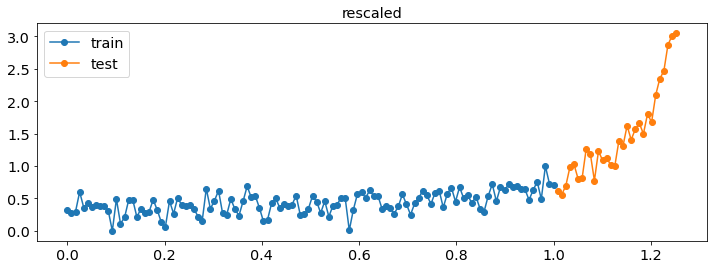

In [120]:
train_xtensor, train_ytensor, test_xtensor, test_ytensor, fig = generate_data_tensor()

CPU times: user 46.2 s, sys: 16 ms, total: 46.3 s
Wall time: 45.3 s


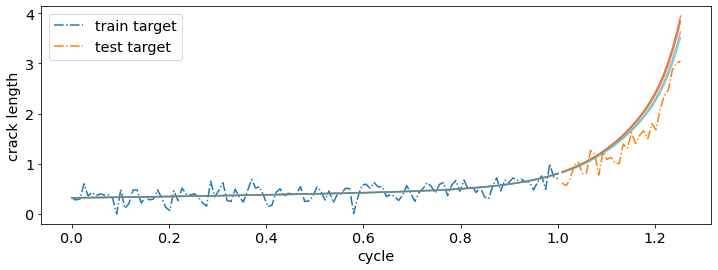

In [121]:
%%time

ensemble_size = 5
ensemble_model = []
ensemble_metric = []

for member_id in range(ensemble_size):
    # print(f"\n{member_id = }")
    model = FullyConnected([1, 4, 4, 1], activation=nn.Tanh).to(device)
    figs=[]
    epochs = 10000
    physics_coeff = 1

    optim = torch.optim.Adam(model.parameters(), lr=1e-2, weight_decay=1e-6)
    metric = train_model_physics_magnitude_norm(model, train_xtensor, train_ytensor, physics_xtensor, 
        train_xscaler_torch, train_yscaler_torch, paris_C, paris_m, paris_dsigma, epochs=epochs, physics_coeff=physics_coeff,
        optim=optim, verbose=False)
    
    ensemble_model.append(model)
    ensemble_metric.append(metric)
    
fig = plot_target_prediction_ensemble(train_xtensor, train_ytensor, 
    test_xtensor, test_ytensor, ensemble_model)


## Deep Ensemble Gaussian Mixture

In [122]:
class GaussianFullyConnected(nn.Module):
    "Defines a fully connected neural network  with output mean and variance of a Gaussian"
    def __init__(self, layer_size, activation=nn.ReLU, need_mean_exp=False):
        super().__init__()
        self.need_mean_exp = need_mean_exp
        layers = []
        
        for i in range(len(layer_size) - 2):
            layers.append(nn.Linear(layer_size[i], layer_size[i+1]))
            layers.append(activation())            
        
        self.layers = nn.Sequential(
            *layers,
            nn.Linear(layer_size[-2], layer_size[-1])
        )
        
    def forward(self, inpt):
        outpt = inpt
        for layer in self.layers:
            outpt = layer(outpt)
        # print(f"{outpt.shape=}")
        mean, logvar = torch.chunk(outpt, 2, dim=-1)
        var = tnf.softplus(logvar) + 1e-6
        # var = torch.exp(logvar)
        
        if self.need_mean_exp: mean =  torch.exp(mean)
        
        return mean, var

model = GaussianFullyConnected([1, 4, 4, 2])
mean, var = model(torch.rand(4, 1))
mean.shape, var.shape

(torch.Size([4, 1]), torch.Size([4, 1]))

In [123]:
# https://github.com/mpritzkoleit/deep-ensembles/blob/master/Deep%20Ensembles.ipynb
def gaussian_mixture_ensemble_forward(ensemble_models, inputtensor):
    means = []; variances = []
    for index, model in enumerate(ensemble_models):
        mean, variance = model(inputtensor)
        means.append(mean)
        variances.append(variance)
    
    means = torch.stack(means)
    variances = torch.stack(variances)
    mixture_mean = means.mean(0)
    mixture_var = (variances + means**2).mean(0) - mixture_mean**2
    
    return mixture_mean, mixture_var
        
def negative_gaussian_loglikelihood(mean, variance, target, mse_coeff=1):
    return (torch.log(variance) + mse_coeff * ((target - mean)**2) / variance).mean()

In [124]:
def compute_data_physics_loss_gaussian_mixture_ensemble(paris_C, paris_m, paris_dsigma, model, inputdata, targetdata, inputphysics, 
    inputscaler, outputscaler):
    
    inputphysics.requires_grad_(True)    
    data_mean, data_var = model(inputdata)
    physics_mean, physics_var = model(inputphysics)
    physics_constraint = 1 * paris_law(outputscaler.inverse(physics_mean), paris_C, paris_m, paris_dsigma)    
    
    derivative = torch.autograd.grad(outputs=physics_mean, inputs=inputphysics, 
        grad_outputs=torch.ones_like(inputphysics), retain_graph=True, create_graph=True)[0]
    rescaled_derivative = derivative * (outputscaler.max - outputscaler.min) / (inputscaler.max - inputscaler.min)
        
    differential_norm = torch.abs(rescaled_derivative) + torch.abs(physics_constraint)
    differential_norm = torch.sum(differential_norm**2)
    data_norm = torch.sum(targetdata**2)

    data_loss = negative_gaussian_loglikelihood(data_mean, data_var, targetdata, 1)
    physics_loss = negative_gaussian_loglikelihood(physics_mean, physics_var, physics_constraint, 1)
    
    return data_loss, data_norm, physics_loss, differential_norm

In [125]:
def train_model_physics_magnitude_norm_ensemble(model, traininput, trainlabel, physicsinput, xscaler, yscaler, 
    paris_C , paris_m, paris_dsigma, epochs=5, physics_coeff=1, optim=None, verbose=True, sample_size=10, kldiv_coeff=1):
    
    if optim is None:
        optim = torch.optim.Adam(model.parameters(), lr=1e-2, weight_decay=1e-6)
    
    traininput = traininput.to(device)
    trainlabel = trainlabel.to(device)
    physicsinput = physicsinput.to(device)
#     scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, mode='min', 
#         factor=0.1, patience=10, threshold_mode="rel", threshold=1e-2, verbose=True)
    metric = {key: np.empty(epochs) for key in "data_loss physics_loss data_norm differential_norm".split()}
    model.train()
    
    for epoch in range(epochs):
        optim.zero_grad()

        data_loss, data_norm, physics_loss, differential_norm = compute_data_physics_loss_gaussian_mixture_ensemble(paris_C, paris_m, paris_dsigma, 
               model, traininput, trainlabel, physicsinput, xscaler, yscaler)

        metric["data_loss"][epoch] = data_loss
        metric["physics_loss"][epoch] = physics_loss
        metric["data_norm"][epoch] = data_norm
        metric["differential_norm"][epoch] = differential_norm
        
        # loss = data_loss * torch.abs(torch.log(data_norm)) + physics_loss * torch.abs(torch.log(differential_norm))
        loss = data_loss + physics_loss
        # loss = data_loss - torch.log(data_norm) + physics_loss - torch.log(differential_norm)
        loss.backward()
        optim.step()        
#         scheduler.step(loss)

        if verbose and (epochs < 10 or epoch % (epochs//5) == 0):
            print(f"\n Epoch {epoch+1} loss = {loss.detach().item()}") 
            print(f"{data_loss = } {physics_loss = } \n {data_norm = } {differential_norm = }")
            print(f"{torch.log(data_norm) = } {torch.log(differential_norm) = }")
    
    # for metricname, metricvalue in metric.items():
    #     metric[metricname] = np.array(metricvalue)
    
    return metric

In [126]:
%%time

ensemble_size = 2
ensemble_model = []
ensemble_metric = []

for member_id in range(ensemble_size):
    # print(f"\n{member_id = }")
    model = GaussianFullyConnected([1, 4, 4, 2], activation=nn.Tanh, need_mean_exp=False).to(device)
    # figs=[]
    epochs = 10000
    physics_coeff = 1

    optim = torch.optim.Adam(model.parameters(), lr=1e-2, weight_decay=1e-6)
    metric = train_model_physics_magnitude_norm_ensemble(model, train_xtensor, train_ytensor, physics_xtensor, 
        train_xscaler_torch, train_yscaler_torch, paris_C, paris_m, paris_dsigma, epochs=epochs, optim=optim, verbose=True)
    
    ensemble_model.append(model)
    ensemble_metric.append(metric)
    
# fig = plot_target_prediction_ensemble(train_xtensor, train_ytensor, 
#     test_xtensor, test_ytensor, ensemble_model)



 Epoch 1 loss = 0.34036630392074585
data_loss = tensor(0.5660, grad_fn=<MeanBackward0>) physics_loss = tensor(-0.2256, grad_fn=<MeanBackward0>) 
 data_norm = tensor(26.2073) differential_norm = tensor(3.9961e-11, grad_fn=<SumBackward0>)
torch.log(data_norm) = tensor(3.2660) torch.log(differential_norm) = tensor(-23.9431, grad_fn=<LogBackward0>)

 Epoch 2001 loss = -5.239555358886719
data_loss = tensor(-1.6927, grad_fn=<MeanBackward0>) physics_loss = tensor(-3.5468, grad_fn=<MeanBackward0>) 
 data_norm = tensor(26.2073) differential_norm = tensor(1.4039e-08, grad_fn=<SumBackward0>)
torch.log(data_norm) = tensor(3.2660) torch.log(differential_norm) = tensor(-18.0814, grad_fn=<LogBackward0>)

 Epoch 4001 loss = -3.569876194000244
data_loss = tensor(-1.5609, grad_fn=<MeanBackward0>) physics_loss = tensor(-2.0090, grad_fn=<MeanBackward0>) 
 data_norm = tensor(26.2073) differential_norm = tensor(7.0514e-09, grad_fn=<SumBackward0>)
torch.log(data_norm) = tensor(3.2660) torch.log(differential

In [127]:
def predict_gaussian_ensemble_model(model, inputtensor):
    with torch.no_grad():
        mean, var = model(inputtensor)
    return mean.detach().cpu().numpy(), var.detach().cpu().numpy()

def plot_target_prediction_ensemble_gaussian(traininput, traintarget, testinput, testtarget, ensemble,
    title=None, figsize=(12, 4), marker=None):
    
    fig = plt.figure(figsize=figsize)
    plt.plot(traininput, traintarget, label="train target", marker=marker, linestyle="-.")
    plt.plot(testinput, testtarget, label="test target", marker=marker, linestyle="-.")
    
    for index, model in enumerate(ensemble):
        train_mean, train_var = predict_gaussian_ensemble_model(model, traininput)
        test_mean, test_var = predict_gaussian_ensemble_model(model, testinput)

        plt.plot(traininput, train_mean, marker=marker, alpha=0.6)
        plt.plot(testinput, test_mean, marker=marker, alpha=0.6)
        plt.fill_between(traininput.squeeze(), (train_mean - 2 * np.sqrt(train_var)).squeeze(), (train_mean + 2 * np.sqrt(train_var)).squeeze(),
            color="gray", alpha=0.2)
        plt.fill_between(testinput.squeeze(), (test_mean - 2 * np.sqrt(test_var)).squeeze(), (test_mean + 2 * np.sqrt(test_var)).squeeze(),
            color="gray", alpha=0.2)
        
    if title: plt.title(title)    
    plt.legend()
    plt.xlabel("cycle")
    plt.ylabel("crack length")

    return fig

def plot_target_prediction_ensemble_gaussian_mixture(traininput, traintarget, testinput, testtarget, ensemble,
    title=None, figsize=(12, 4), marker=None):
    
    fig = plt.figure(figsize=figsize)
    plt.plot(traininput, traintarget, label="train target", marker=marker, linestyle="-.")
    plt.plot(testinput, testtarget, label="test target", marker=marker, linestyle="-.")
    
    train_mean, train_var = gaussian_mixture_ensemble_forward(ensemble, traininput)
    test_mean, test_var = gaussian_mixture_ensemble_forward(ensemble, testinput)
    train_mean, train_var = train_mean.detach().numpy(), train_var.detach().numpy()
    test_mean, test_var = test_mean.detach().numpy(), test_var.detach().numpy()

    plt.plot(traininput, train_mean, marker=marker, alpha=0.6)
    plt.plot(testinput, test_mean, marker=marker, alpha=0.6)
    plt.fill_between(traininput.squeeze(), (train_mean - 2 * np.sqrt(train_var)).squeeze(), (train_mean + 2 * np.sqrt(train_var)).squeeze(),
        color="gray", alpha=0.2)
    plt.fill_between(testinput.squeeze(), (test_mean - 2 * np.sqrt(test_var)).squeeze(), (test_mean + 2 * np.sqrt(test_var)).squeeze(),
        color="gray", alpha=0.2)
        
    if title: plt.title(title)    
    plt.legend()
    plt.xlabel("cycle")
    plt.ylabel("crack length")

    return fig

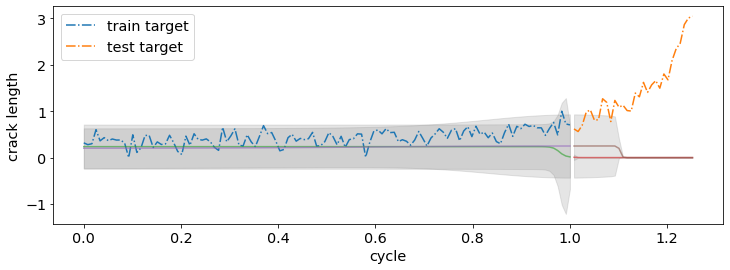

In [128]:
fig = plot_target_prediction_ensemble_gaussian(train_xtensor, train_ytensor, test_xtensor, test_ytensor, ensemble_model)

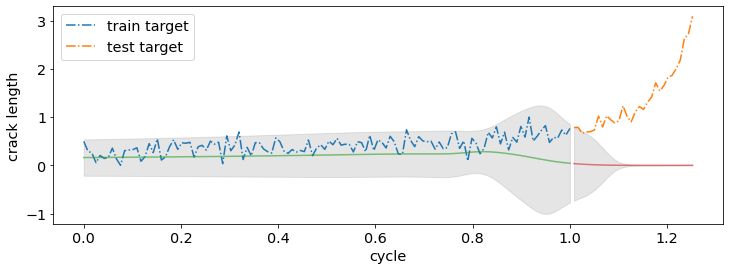

In [172]:
fig = plot_target_prediction_ensemble_gaussian_mixture(train_xtensor, train_ytensor, test_xtensor, test_ytensor, ensemble_model)

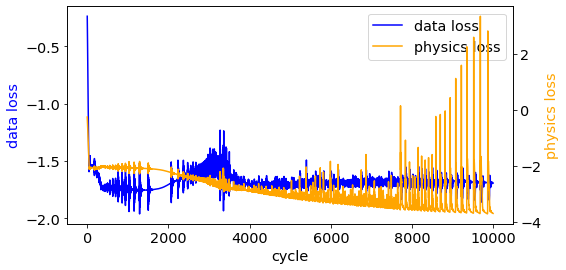

In [173]:
fig = plot_twinx(np.arange(epochs), ensemble_metric[0]["data_loss"], "data loss", ensemble_metric[0]["physics_loss"], "physics loss")

## Bayes by backprop old

In [108]:
# https://www.nitarshan.com/bayes-by-backprop/

class ReparametrizedGaussian():
    def __init__(self, mean, exp_std):
        super().__init__()
        self.mean = mean
        self.exp_std = exp_std
        self.normal01 = torch.distributions.Normal(0,1)
    
    def std(self):
        # std sigma = log( 1 + exp(exp_std) )
        return torch.log1p(torch.exp(self.exp_std))
    
    def sample(self):
        epsilon = self.normal01.sample(self.exp_std.size())
        return self.mean + self.std() * epsilon
    
    def log_prob(self, inputdata):
        return (-math.log(math.sqrt(2 * math.pi))
                - torch.log(self.std())
                - ((inputdata - self.mean) ** 2) / (2 * self.std() ** 2)).sum()
    
class ScaledMixtureGaussian():
    def __init__(self, weight1, std1, std2):
        super().__init__()
        self.weight1 = weight1
        self.std1 = std1
        self.std2 = std2
        self.gaussian1 = torch.distributions.Normal(0,std1)
        self.gaussian2 = torch.distributions.Normal(0,std2)
    
    def log_prob(self, inputdata):
        prob1 = torch.exp(self.gaussian1.log_prob(inputdata))
        prob2 = torch.exp(self.gaussian2.log_prob(inputdata))
        return (torch.log(self.weight1 * prob1 + (1 - self.weight1) * prob2)).sum()


class BayesianLinear(nn.Module):
    def __init__(self, inputsize, outputsize, mixture_weight=0.5, prior_std1=1, prior_std2=math.exp(-6)):
        super().__init__()
        self.input_size = inputsize
        self.output_size = outputsize
        
        # Weight parameters
        self.weight_mean = nn.Parameter(torch.Tensor(outputsize, inputsize).uniform_(-0.2, 0.2))
        self.weight_reparam_std = nn.Parameter(torch.Tensor(outputsize, inputsize).uniform_(-5,-4))
        # self.weight_gaussian = ReparametrizedGaussian(self.weight_mean, self.weight_exp_std)
        
        # Bias parameters
        self.bias_mean = nn.Parameter(torch.Tensor(outputsize).uniform_(-0.2, 0.2))
        self.bias_reparam_std = nn.Parameter(torch.Tensor(outputsize).uniform_(-5,-4))
        # self.bias_gaussian = ReparametrizedGaussian(self.bias_mean, self.bias_exp_std)
        
        # Prior distributions
        # mixture_weight=0.5
        # prior_std1 = 1
        # prior_std2 = math.exp(-6)
        
        self.weight_prior = ScaledMixtureGaussian(mixture_weight, prior_std1, prior_std2)
        self.bias_prior = ScaledMixtureGaussian(mixture_weight, prior_std1, prior_std2)
        
        self.log_prior = 0
        self.log_proposal = 0

    def forward(self, inputdata, need_sample=False, need_log_probs=False):
        # if self.training or need_sample:
        if need_sample:
            # weight = self.weight_gaussian.sample()
            weight = torch.randn(1).to(device) * reparameterize_std(self.weight_reparam_std) + self.weight_mean
            bias = torch.randn(1).to(device) * reparameterize_std(self.bias_reparam_std) + self.bias_mean
            # bias = self.bias_gaussian.sample()
        else:
            weight = self.weight_mean
            bias = self.bias_mean
        
        # if self.training or need_log_probs:
        self.log_prior = self.weight_prior.log_prob(weight) + self.bias_prior.log_prob(bias)
        # self.log_proposal = self.weight_gaussian.log_prob(weight) + self.bias_gaussian.log_prob(bias)
        self.log_proposal = log_gaussian_logsigma(weight, self.weight_mean, reparameterize_std(self.weight_reparam_std)).sum() \
            + log_gaussian_logsigma(bias, self.bias_mean, reparameterize_std(self.bias_reparam_std)).sum()
        
#         else:
#             self.log_prior, self.log_proposal = 0, 0

        return tnf.linear(inputdata, weight, bias)

class BayesianNN(nn.Module):
    def __init__(self, layer_size, activation=nn.ReLU, need_output_exp=True):
        super().__init__()
        layers = []
        
        for i in range(len(layer_size) - 2):
            layers.append(BayesianLinear(layer_size[i], layer_size[i+1]))
            layers.append(activation())            
        
        self.layers = nn.Sequential(
            *layers,
            BayesianLinear(layer_size[-2], layer_size[-1])
        )
        self.need_output_exp = need_output_exp
        
    def forward(self, indata, need_sample=False):        
        outdata = indata
        for layer in self.layers:
            if isinstance(layer, BayesianLinear):
                outdata = layer(outdata, need_sample)
            else:
                outdata = layer(outdata)
        if self.need_output_exp: outdata = torch.exp(outdata)
        
        return outdata
        # return torch.exp(outdata)
    
    def log_prior(self):
        # logprior = 0
        # for layer in self.layers:
        #     if isinstance(layer, GaussianLinear):
        #         logprior += layer.log_prior
        logprior = sum([layer.log_prior for layer in self.layers if isinstance(layer, BayesianLinear)])
        return logprior
    
    def log_proposal(self):
        # logproposal = 0
        # for layer in self.layers:
        #     if isinstance(layer, GaussianLinear):
        #         logproposal += layer.log_proposal
        logproposal = sum([layer.log_proposal for layer in self.layers if isinstance(layer, BayesianLinear)])
        return logproposal


    """
    def sample_log_prior_proposal(self, indata, targetdata, sample_size):
        outdata = torch.zeros(sample_size)
        log_priors = torch.zeros(sample_size)
        log_proposals = torch.zeros(sample_size)
        
        for i in range(sample_size):
            outdata[i] = self(indata, need_sample=True)
            log_priors[i] = self.log_prior()
            log_proposals[i] = self.log_proposal()
        
        log_prior = log_priors.mean()
        log_proposal = log_proposals.mean()
               
        return outdata, log_prior, log_proposal
"""
    


In [99]:
def compute_data_physics_loss_bayesian_nn(paris_C, paris_m, paris_dsigma, model, inputdata, targetdata, inputphysics, 
    inputscaler, outputscaler, physics_coeff, sample_size=10, likelihood_std=1.):
    
    samples_logprior, samples_logproposal, data_samples_loglikelihood, physics_samples_loglikelihood = 0., 0., 0., 0.
    inputphysics.requires_grad_(True)
    
    for samplecount in range(sample_size):
        data_prediction = model.forward(inputdata, need_sample=True)
        physics_prediction = model.forward(inputphysics, need_sample=True)
        physics_constraint = 1 * paris_law(outputscaler.inverse(physics_prediction), paris_C, paris_m, paris_dsigma)    
        # print(f"{data_prediction = } \n {physics_prediction = } \n {physics_constraint = }")
        
        samples_logprior += model.log_prior()
        samples_logproposal += model.log_proposal()        
#         print(f"{samples_logprior = } {samples_logproposal = }")

        derivative = torch.autograd.grad(outputs=physics_prediction, inputs=inputphysics, 
            grad_outputs=torch.ones_like(inputphysics), retain_graph=True, create_graph=True)[0]
        rescaled_derivative = derivative * (outputscaler.max - outputscaler.min) / (inputscaler.max - inputscaler.min)
        
        differential_norm = torch.abs(rescaled_derivative) + torch.abs(physics_constraint)
        differential_norm = torch.sum(differential_norm**2)
        data_norm = torch.sum(targetdata**2)
        #         print(f"{data_norm = } {differential_norm = }")
        
        dataloss = tnf.mse_loss(data_prediction, targetdata)
        physicsloss = physics_coeff * (rescaled_derivative - physics_constraint)**2
        
        # print(f"{log_gaussian(targetdata, data_prediction, model.likelihood_std) = }")
        # data_samples_loglikelihood += log_gaussian(targetdata, data_prediction, model.likelihood_std).mean()
        # physics_samples_loglikelihood += log_gaussian(physics_constraint, rescaled_derivative, model.likelihood_std).mean()
        data_samples_loglikelihood += mse_to_log_gaussian(dataloss / data_norm, likelihood_std).mean()
        physics_samples_loglikelihood += mse_to_log_gaussian(physicsloss / differential_norm, likelihood_std).mean()
#         print(f"{data_samples_loglikelihood = } {physics_samples_loglikelihood = }")
                    
    return samples_logprior/sample_size, samples_logproposal/sample_size, \
        data_samples_loglikelihood/sample_size, physics_samples_loglikelihood/sample_size

In [100]:
def train_model_physics_magnitude_norm_bayesian_nn(model, traininput, trainlabel, physicsinput, xscaler, yscaler, 
    paris_C , paris_m, paris_dsigma, epochs=5, physics_coeff=1, optim=None, verbose=True, sample_size=10, likelihood_coeff=1):
    
    if optim is None:
        optim = torch.optim.Adam(model.parameters(), lr=1e-1, weight_decay=1e-6)
    
    traininput = traininput.to(device)
    trainlabel = trainlabel.to(device)
    physicsinput = physicsinput.to(device)
#     scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, mode='min', 
#         factor=0.1, patience=10, threshold_mode="rel", threshold=1e-2, verbose=True)

    metric = dict(data_loglikelihood=np.empty(epochs), physics_loglikelihood=np.empty(epochs), 
        logprior=np.empty(epochs), logproposal=np.empty(epochs))
    model.train()
    
    for epoch in range(epochs):
        optim.zero_grad()
        loss = torch.zeros(1)
        
        logprior, logproposal, data_loglikelihood, physics_loglikelihood = compute_data_physics_loss_bayesian_nn(
            paris_C, paris_m, paris_dsigma, model, traininput, trainlabel, physicsinput, 
            xscaler, yscaler, physics_coeff=physics_coeff, sample_size=sample_size)
        loss = (logproposal - logprior) - likelihood_coeff * (data_loglikelihood + physics_loglikelihood)

        metric["data_loglikelihood"][epoch] = data_loglikelihood
        metric["physics_loglikelihood"][epoch] = physics_loglikelihood
        metric["logprior"][epoch] = logprior
        metric["logproposal"][epoch] = logproposal
        
        loss.backward()
        optim.step()        
#         scheduler.step(loss)
                
        if verbose and (epochs < 10 or epoch % (epochs//10) == 0):
            print(f"\n Epoch {epoch+1} loss = {loss.detach().item()}") 
            print(f"{logprior = } ; {logproposal = } \n kl = {logproposal - logprior} ; log likelihood = {data_loglikelihood + physics_loglikelihood}")
            print(f"{data_loglikelihood = } {physics_loglikelihood = }")

#             print(f"normalized data loss = {(dataloss / data_norm).detach().item()} ; normalized physics loss = {(physicsloss / differential_norm).detach().item()}")
#             print(f"normalized data loss = {metric['normalized_data_loglikelihood'][epoch].mean()} ; normalized physics loss = {metric['normalized_physics_loglikelihood'][epoch].mean()}")
#             print(f"{data_norm = } {differential_norm = }")

#             figs.append(plot_twinx(tensor_to_array(xphysics), tensor_to_array(rescaled_derivative), "derivative",
#                 tensor_to_array(physics_constraint), "predictive paris"))#, paris_law(all_yscaled, paris_C, paris_m, paris_dsigma), "target paris"))

#             fig = plt.figure(figsize=(8,4))
#             plt.plot(tensor_to_array(physicsinput), tensor_to_array(rescaled_derivative), label="rescaled derivative", marker="o")
#             plt.plot(tensor_to_array(physicsinput), tensor_to_array(physics_constraint), label="paris", marker="o")
#             plt.legend()
#             figs.append(fig)
            
#             plt.close()            
            
    # metric["data_loglikelihood"] = metric["data_loglikelihood"].mean(1)
    # metric["physics_loglikelihood"] = metric["physics_loglikelihood"].mean(1)
#     metric["normalized_data_loglikelihood"] = metric["normalized_data_loglikelihood"].mean(1)
#     metric["normalized_physics_loglikelihood"] = metric["normalized_physics_loglikelihood"].mean(1)
    
    for metricname, metricvalue in metric.items():
        metric[metricname] = np.array(metricvalue)
    
    return metric

In [101]:
model = BayesianNN([1, 4, 4, 1], activation=nn.Tanh, need_output_exp=True).to(device)
figs=[]
epochs = 4000
physics_coeff = 1
# fig = plt.figure(1, figsize=(12,4))
losses = train_model_debug(model, torch.cat([train_xtensor, test_xtensor]), torch.cat([train_ytensor, test_ytensor]), physics_xtensor, 
    train_xscaler_torch, train_yscaler_torch, paris_C, paris_m, paris_dsigma, epochs=epochs, physics_coeff=physics_coeff)

train_predictions = sample_prediction(model, torch.cat([train_xtensor, test_xtensor]))
# test_predictions, test_loss = predict_model(model, test_xtensor, test_ytensor)
# print(train_predictions.shape, test_predictions.shape)

fig = plot_target_prediction_sample(np.concatenate([train_xscaled, test_xscaled]), np.concatenate([train_yscaled, test_yscaled]), train_predictions, 
                       test_xscaled, test_yscaled, title="train on all data", marker="")


NameError: name 'BayesianNN' is not defined

In [ ]:
model = BayesianNN([1, 4, 4, 1], activation=nn.Tanh, need_output_exp=False).to(device)
figs=[]
epochs = 10000
physics_coeff = 1

optim = torch.optim.Adam(model.parameters(), lr=1e-1, weight_decay=1e-6)
metric_mse = train_model_physics_magnitude_norm(model, train_xtensor, train_ytensor, physics_xtensor, 
    train_xscaler_torch, train_yscaler_torch, paris_C, paris_m, paris_dsigma, epochs=epochs, physics_coeff=physics_coeff,
    optim=optim)

train_predictions = sample_prediction(model, train_xtensor, sample_size=10)
test_predictions = sample_prediction(model, test_xtensor, test_ytensor, sample_size=10)
# print(train_predictions.shape, test_predictions.shape)

fig = plot_target_prediction_sample(train_xtensor, train_ytensor, train_predictions, 
                       test_xtensor, test_ytensor, test_predictions, marker="")


In [ ]:
model = BayesianNN([1, 4, 4, 1], activation=nn.Tanh).to(device)
figs=[]
epochs = 1000
physics_coeff = 1

optim = torch.optim.Adam(model.parameters(), lr=1e-2, weight_decay=1e-6)
metric = train_model_physics_magnitude_norm_bayesian_nn(model, train_xtensor, train_ytensor, physics_xtensor, 
    train_xscaler_torch, train_yscaler_torch, paris_C, paris_m, paris_dsigma, epochs=epochs, physics_coeff=physics_coeff,
    optim=optim, sample_size=10, likelihood_coeff=1)

train_predictions = sample_prediction(model, train_xtensor, sample_size=10)
test_predictions = sample_prediction(model, test_xtensor, test_ytensor, sample_size=10)
# print(train_predictions.shape, test_predictions.shape)

fig = plot_target_prediction_sample(train_xtensor, train_ytensor, train_predictions, 
                       test_xtensor, test_ytensor, test_predictions, marker="")


## vary training size

torch.Size([90, 1]) torch.Size([90, 1]) torch.Size([60, 1]) torch.Size([60, 1])
torch.Size([90, 1]) torch.Size([90, 1]) torch.Size([60, 1]) torch.Size([60, 1])


Text(0.5, 1.0, 'rescaled')

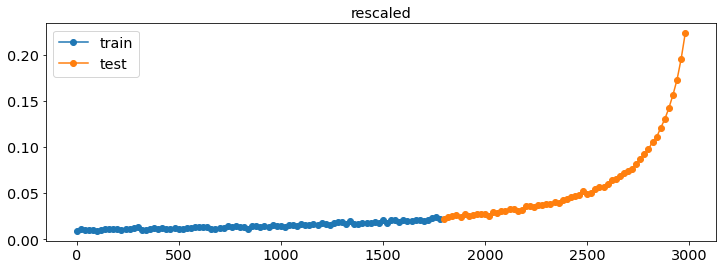

In [90]:
paris_C = np.exp(-23)
paris_m = 4.
paris_dsigma = 75.
paris_a0 = 0.01

train_input, train_target, test_input, test_target = generate_data(paris_C, paris_m, paris_a0, paris_dsigma, trainsize=0.6, 
    startN=0., endN=3000., stepN=20, noise_strength=1e-3)

train_xtensor = totensor(train_input)
train_ytensor = totensor(train_target)
test_xtensor = totensor(test_input)
test_ytensor = totensor(test_target)

print(train_xtensor.shape, train_ytensor.shape, test_xtensor.shape, test_ytensor.shape)

train_xscaler_torch = TorchMinMaxScaler().fit(train_xtensor)
train_yscaler_torch = TorchMinMaxScaler().fit(train_ytensor)

train_xtensor = train_xscaler_torch.forward(train_xtensor)
train_ytensor = train_yscaler_torch.forward(train_ytensor)
test_xtensor = train_xscaler_torch.forward(test_xtensor)
test_ytensor = train_yscaler_torch.forward(test_ytensor)

print(train_xtensor.shape, train_ytensor.shape, test_xtensor.shape, test_ytensor.shape)
plt.figure(figsize=(12, 4))
plt.plot(train_xscaler_torch.inverse(train_xtensor), train_yscaler_torch.inverse(train_ytensor), marker="o", label="train")
plt.plot(train_xscaler_torch.inverse(test_xtensor), train_yscaler_torch.inverse(test_ytensor), marker="o", label="test")
plt.legend()
plt.title("rescaled")


 Epoch 1 loss = 0.10268288850784302
normalized data loss = 0.09268289059400558 ; normalized physics loss = 0.009999999776482582
data_norm = tensor(18.8404) differential_norm = tensor(1.4002e-07, grad_fn=<SumBackward0>)

 Epoch 1001 loss = 0.00034907207009382546
normalized data loss = 0.00028660797397606075 ; normalized physics loss = 6.246409611776471e-05
data_norm = tensor(18.8404) differential_norm = tensor(7.2723e-08, grad_fn=<SumBackward0>)

 Epoch 2001 loss = 0.00023099913960322738
normalized data loss = 0.00022557310876436532 ; normalized physics loss = 5.426025381893851e-06
data_norm = tensor(18.8404) differential_norm = tensor(7.5356e-08, grad_fn=<SumBackward0>)

 Epoch 3001 loss = 0.00022964089293964207
normalized data loss = 0.00022522186918649822 ; normalized physics loss = 4.419019205670338e-06
data_norm = tensor(18.8404) differential_norm = tensor(7.5257e-08, grad_fn=<SumBackward0>)

 Epoch 4001 loss = 0.0002285507071064785
normalized data loss = 0.00022493174765259027 ; 

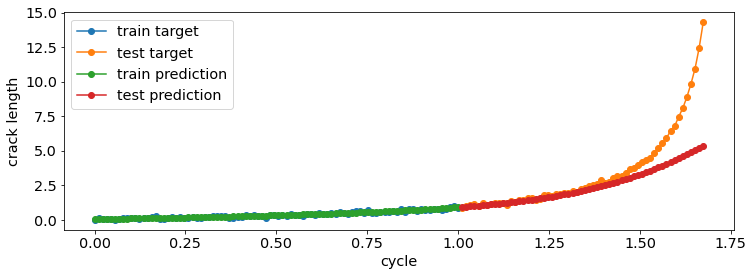

In [91]:
model = FullyConnectedExp([1, 4, 4, 1], activation=nn.Tanh).to(device)
figs=[]
epochs = 10000
physics_coeff = 1

optim = torch.optim.Adam(model.parameters(), lr=1e-2, weight_decay=1e-6)
metric = train_model_physics_magnitude_norm(model, train_xtensor, train_ytensor, physics_xtensor, 
    train_xscaler_torch, train_yscaler_torch, paris_C, paris_m, paris_dsigma, epochs=epochs, physics_coeff=physics_coeff,
    optim=optim)

train_predictions, _ = predict_model(model, train_xtensor)
test_predictions, test_loss = predict_model(model, test_xtensor, test_ytensor)
# print(train_predictions.shape, test_predictions.shape)

# fig = plot_target_prediction(train_xscaled, train_yscaled, torch.exp(train_predictions), 
#                        test_xscaled, test_yscaled, torch.exp(test_predictions))
fig = plot_target_prediction(train_xtensor, train_ytensor, train_predictions, 
                       test_xtensor, test_ytensor, test_predictions)

print(f"{test_loss = }")

torch.Size([105, 1]) torch.Size([105, 1]) torch.Size([45, 1]) torch.Size([45, 1])
torch.Size([105, 1]) torch.Size([105, 1]) torch.Size([45, 1]) torch.Size([45, 1])


Text(0.5, 1.0, 'rescaled')

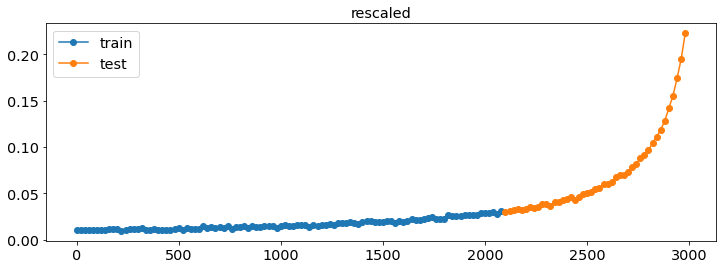

In [92]:
paris_C = np.exp(-23)
paris_m = 4.
paris_dsigma = 75.
paris_a0 = 0.01

train_input, train_target, test_input, test_target = generate_data(paris_C, paris_m, paris_a0, paris_dsigma, trainsize=0.7, 
    startN=0., endN=3000., stepN=20, noise_strength=1e-3)

train_xtensor = totensor(train_input)
train_ytensor = totensor(train_target)
test_xtensor = totensor(test_input)
test_ytensor = totensor(test_target)

print(train_xtensor.shape, train_ytensor.shape, test_xtensor.shape, test_ytensor.shape)

train_xscaler_torch = TorchMinMaxScaler().fit(train_xtensor)
train_yscaler_torch = TorchMinMaxScaler().fit(train_ytensor)

train_xtensor = train_xscaler_torch.forward(train_xtensor)
train_ytensor = train_yscaler_torch.forward(train_ytensor)
test_xtensor = train_xscaler_torch.forward(test_xtensor)
test_ytensor = train_yscaler_torch.forward(test_ytensor)

print(train_xtensor.shape, train_ytensor.shape, test_xtensor.shape, test_ytensor.shape)
plt.figure(figsize=(12, 4))
plt.plot(train_xscaler_torch.inverse(train_xtensor), train_yscaler_torch.inverse(train_ytensor), marker="o", label="train")
plt.plot(train_xscaler_torch.inverse(test_xtensor), train_yscaler_torch.inverse(test_ytensor), marker="o", label="test")
plt.legend()
plt.title("rescaled")


 Epoch 1 loss = 0.029395565390586853
normalized data loss = 0.01939556561410427 ; normalized physics loss = 0.009999999776482582
data_norm = tensor(18.5580) differential_norm = tensor(6.6390e-08, grad_fn=<SumBackward0>)

 Epoch 1001 loss = 9.812735515879467e-05
normalized data loss = 9.46472428040579e-05 ; normalized physics loss = 3.4801109904947225e-06
data_norm = tensor(18.5580) differential_norm = tensor(4.1686e-07, grad_fn=<SumBackward0>)

 Epoch 2001 loss = 9.587969543645158e-05
normalized data loss = 9.362313721794635e-05 ; normalized physics loss = 2.256561629110365e-06
data_norm = tensor(18.5580) differential_norm = tensor(4.2069e-07, grad_fn=<SumBackward0>)

 Epoch 3001 loss = 9.46128202485852e-05
normalized data loss = 9.297331416746601e-05 ; normalized physics loss = 1.6395094917243114e-06
data_norm = tensor(18.5580) differential_norm = tensor(4.2329e-07, grad_fn=<SumBackward0>)

 Epoch 4001 loss = 9.394072549184784e-05
normalized data loss = 9.266241249861196e-05 ; normal

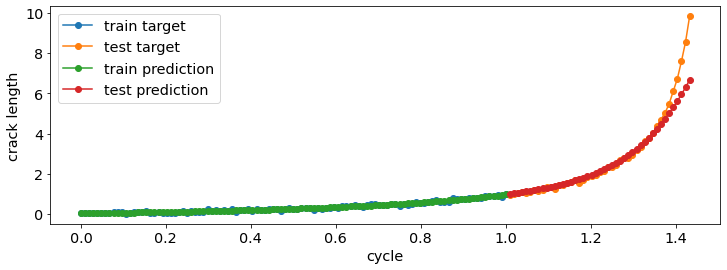

In [93]:
model = FullyConnectedExp([1, 4, 4, 1], activation=nn.Tanh).to(device)
figs=[]
epochs = 10000
physics_coeff = 1

optim = torch.optim.Adam(model.parameters(), lr=1e-2, weight_decay=1e-6)
metric = train_model_physics_magnitude_norm(model, train_xtensor, train_ytensor, physics_xtensor, 
    train_xscaler_torch, train_yscaler_torch, paris_C, paris_m, paris_dsigma, epochs=epochs, physics_coeff=physics_coeff,
    optim=optim)

train_predictions, _ = predict_model(model, train_xtensor)
test_predictions, test_loss = predict_model(model, test_xtensor, test_ytensor)
# print(train_predictions.shape, test_predictions.shape)

# fig = plot_target_prediction(train_xscaled, train_yscaled, torch.exp(train_predictions), 
#                        test_xscaled, test_yscaled, torch.exp(test_predictions))
fig = plot_target_prediction(train_xtensor, train_ytensor, train_predictions, 
                       test_xtensor, test_ytensor, test_predictions)

print(f"{test_loss = }")

## vary noise strength

torch.Size([120, 1]) torch.Size([120, 1]) torch.Size([30, 1]) torch.Size([30, 1])
torch.Size([120, 1]) torch.Size([120, 1]) torch.Size([30, 1]) torch.Size([30, 1])


Text(0.5, 1.0, 'rescaled')

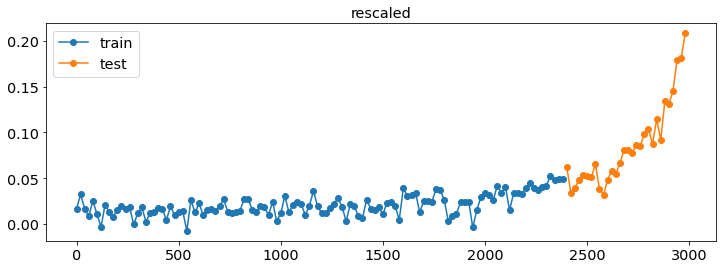

In [94]:
paris_C = np.exp(-23)
paris_m = 4.
paris_dsigma = 75.
paris_a0 = 0.01

train_input, train_target, test_input, test_target = generate_data(paris_C, paris_m, paris_a0, paris_dsigma, trainsize=0.8, 
    startN=0., endN=3000., stepN=20, noise_strength=1e-2)

train_xtensor = totensor(train_input)
train_ytensor = totensor(train_target)
test_xtensor = totensor(test_input)
test_ytensor = totensor(test_target)

print(train_xtensor.shape, train_ytensor.shape, test_xtensor.shape, test_ytensor.shape)

train_xscaler_torch = TorchMinMaxScaler().fit(train_xtensor)
train_yscaler_torch = TorchMinMaxScaler().fit(train_ytensor)

train_xtensor = train_xscaler_torch.forward(train_xtensor)
train_ytensor = train_yscaler_torch.forward(train_ytensor)
test_xtensor = train_xscaler_torch.forward(test_xtensor)
test_ytensor = train_yscaler_torch.forward(test_ytensor)

print(train_xtensor.shape, train_ytensor.shape, test_xtensor.shape, test_ytensor.shape)
plt.figure(figsize=(12, 4))
plt.plot(train_xscaler_torch.inverse(train_xtensor), train_yscaler_torch.inverse(train_ytensor), marker="o", label="train")
plt.plot(train_xscaler_torch.inverse(test_xtensor), train_yscaler_torch.inverse(test_ytensor), marker="o", label="test")
plt.legend()
plt.title("rescaled")


 Epoch 1 loss = 0.025925621390342712
normalized data loss = 0.016101431101560593 ; normalized physics loss = 0.00982419028878212
data_norm = tensor(31.4532) differential_norm = tensor(1.5427e-06, grad_fn=<SumBackward0>)

 Epoch 1001 loss = 0.0007092729792930186
normalized data loss = 0.0006901825545355678 ; normalized physics loss = 1.9090448404313065e-05
data_norm = tensor(31.4532) differential_norm = tensor(3.1537e-06, grad_fn=<SumBackward0>)

 Epoch 2001 loss = 0.0006685760454274714
normalized data loss = 0.0006546151707880199 ; normalized physics loss = 1.3960865544504486e-05
data_norm = tensor(31.4532) differential_norm = tensor(1.1792e-05, grad_fn=<SumBackward0>)

 Epoch 3001 loss = 0.0006618023617193103
normalized data loss = 0.0006500901072286069 ; normalized physics loss = 1.171227813756559e-05
data_norm = tensor(31.4532) differential_norm = tensor(1.9273e-05, grad_fn=<SumBackward0>)

 Epoch 4001 loss = 0.000658695527818054
normalized data loss = 0.0006472279201261699 ; norma

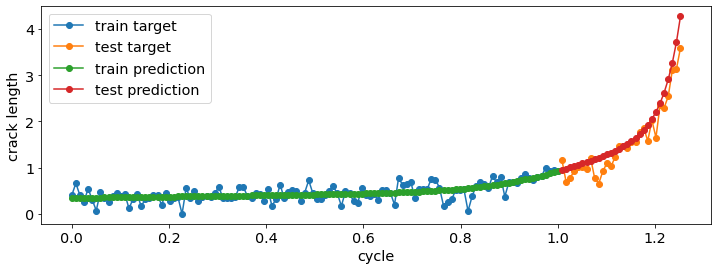

In [95]:
model = FullyConnectedExp([1, 4, 4, 1], activation=nn.Tanh).to(device)
figs=[]
epochs = 10000
physics_coeff = 1

optim = torch.optim.Adam(model.parameters(), lr=1e-2, weight_decay=1e-6)
metric = train_model_physics_magnitude_norm(model, train_xtensor, train_ytensor, physics_xtensor, 
    train_xscaler_torch, train_yscaler_torch, paris_C, paris_m, paris_dsigma, epochs=epochs, physics_coeff=physics_coeff,
    optim=optim)

train_predictions, _ = predict_model(model, train_xtensor)
test_predictions, test_loss = predict_model(model, test_xtensor, test_ytensor)
# print(train_predictions.shape, test_predictions.shape)

# fig = plot_target_prediction(train_xscaled, train_yscaled, torch.exp(train_predictions), 
#                        test_xscaled, test_yscaled, torch.exp(test_predictions))
fig = plot_target_prediction(train_xtensor, train_ytensor, train_predictions, 
                       test_xtensor, test_ytensor, test_predictions)

print(f"{test_loss = }")

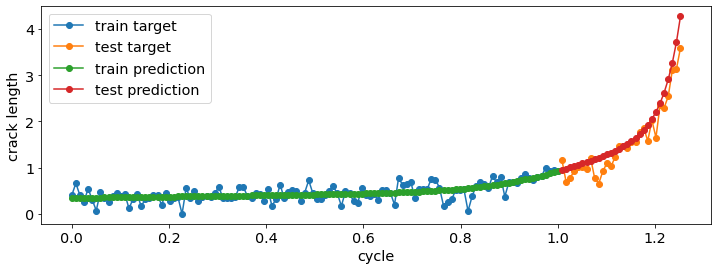

In [96]:
fig = plot_target_prediction(train_xtensor, train_ytensor, train_predictions, 
                       test_xtensor, test_ytensor, test_predictions, figsize=(12, 4))
fig.savefig("prediction.png", bbox_inches="tight")

## harmonic oscillator test

In [43]:
def oscillator(d, w0, x):
    """Defines the analytical solution to the 1D underdamped harmonic oscillator problem. 
    Equations taken from: https://beltoforion.de/en/harmonic_oscillator/"""
    assert d < w0
    w = np.sqrt(w0**2-d**2)
    phi = np.arctan(-d/w)
    A = 1/(2*np.cos(phi))
    cos = torch.cos(phi+w*x)
    sin = torch.sin(phi+w*x)
    exp = torch.exp(-d*x)
    y  = exp*2*A*cos
    return y

torch.Size([500, 1]) torch.Size([500, 1])
torch.Size([10, 1]) torch.Size([10, 1])


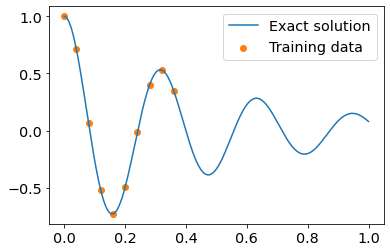

In [44]:
d, w0 = 2, 20

# get the analytical solution over the full domain
x = torch.linspace(0,1,500).view(-1,1)
y = oscillator(d, w0, x).view(-1,1)
print(x.shape, y.shape)

# slice out a small number of points from the LHS of the domain
x_data = x[0:200:20]
y_data = y[0:200:20]
print(x_data.shape, y_data.shape)

plt.figure()
plt.plot(x, y, label="Exact solution")
plt.scatter(x_data, y_data, color="tab:orange", label="Training data")
plt.legend()
plt.show()


In [45]:
def plot_result(x,y,x_data,y_data,yh, i,xp=None):
    "Pretty plot training results"
    plt.figure(figsize=(8,4))
    plt.plot(x,y, color="grey", linewidth=2, alpha=0.8, label="Exact solution")
    plt.plot(x,yh, color="tab:blue", linewidth=4, alpha=0.8, label="Neural network prediction")
    plt.scatter(x_data, y_data, s=60, color="tab:orange", alpha=0.4, label='Training data')
    if xp is not None:
        plt.scatter(xp, -0*torch.ones_like(xp), s=60, color="tab:green", alpha=0.4, 
                    label='Physics loss training locations')
    l = plt.legend(loc=(1.01,0.34), frameon=False, fontsize="large")
    plt.setp(l.get_texts(), color="k")
    plt.xlim(-0.05, 1.05)
#     plt.ylim(-1.1, 1.1)
#     plt.text(1.065,0.7,"Training step: %i"%(i+1),fontsize="xx-large",color="k")
    plt.axis("off")

In [46]:
def train_oscillator():

    x_physics = torch.linspace(0,1,30).view(-1,1).requires_grad_(True)# sample locations over the problem domain
    mu, k = 2*d, w0**2

    torch.manual_seed(2022)
    model = FullyConnected([1, 32, 32, 32, 1], activation=nn.Tanh)
    optimizer = torch.optim.Adam(model.parameters(),lr=1e-2)
    files = []
    epochs=4000
    for i in range(epochs):
        optimizer.zero_grad()

        # compute the "data loss"
        yh = model(x_data)
        loss1 = torch.mean((yh-y_data)**2)# use mean squared error

        # compute the "physics loss"
        yhp = model(x_physics)
        dx  = torch.autograd.grad(yhp, x_physics, torch.ones_like(yhp), create_graph=True)[0]# computes dy/dx
        dx2 = torch.autograd.grad(dx,  x_physics, torch.ones_like(dx),  create_graph=True)[0]# computes d^2y/dx^2
        physics = dx2 + mu*dx + k*yhp# computes the residual of the 1D harmonic oscillator differential equation
        loss2 = (1e-4)*torch.mean(physics**2)

        # backpropagate joint loss
        loss = loss1 + loss2# add two loss terms together
        loss.backward()
        optimizer.step()

        # plot the result as training progresses
#         if (i+1) % 10 == 0: 
        if (i+1) % (epochs//5) == 0: 

            yh = model(x).detach()
            xp = x_physics.detach()

            plot_result(x,y,x_data,y_data,yh, i, xp)
            plt.show()
            fig = plt.figure(figsize=(12, 4))
#             xphysics_plot = x_physics.detach().numpy()
            plt.plot(xp, dx.detach().numpy(), label="dx")
            plt.plot(xp, dx2.detach().numpy(), label="dx2")
            plt.plot(xp, -(mu*dx + k*yhp).detach().numpy(), label="physics law")
            plt.legend()
            figs.append(fig)
#             print(dx)
#             print(dx2, '\n',  mu*dx + k*yhp)
            print(loss1, loss2)
#             file = "plots/pinn_%.8i.png"%(i+1)
#             plt.savefig(file, bbox_inches='tight', pad_inches=0.1, dpi=100, facecolor="white")
#             files.append(file)

#             if (i+1) % 200 == 0: plt.show()
#             else: plt.close("all")

In [47]:
figs=[]
# train_oscillator()

## Pyro

In [106]:
# https://www.kaggle.com/code/carlossouza/simple-bayesian-neural-network-in-pyro/notebook
"""
class BayesianNNPyro(PyroModule):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.linear = PyroModule[nn.Linear](in_features, out_features)
        self.linear.weight = PyroSample(dist.Normal(0., 1.).expand([out_features, in_features]).to_event(2))
        self.linear.bias = PyroSample(dist.Normal(0., 10.).expand([out_features]).to_event(1))

    def forward(self, x, y=None):
        sigma = pyro.sample("sigma", dist.Uniform(0., 10.))
        mean = self.linear(x).squeeze(-1)
        with pyro.plate("data", x.shape[0]):
            obs = pyro.sample("obs", dist.Normal(mean, sigma), obs=y)
        return mean
"""

'\nclass BayesianNNPyro(PyroModule):\n    def __init__(self, in_features, out_features):\n        super().__init__()\n        self.linear = PyroModule[nn.Linear](in_features, out_features)\n        self.linear.weight = PyroSample(dist.Normal(0., 1.).expand([out_features, in_features]).to_event(2))\n        self.linear.bias = PyroSample(dist.Normal(0., 10.).expand([out_features]).to_event(1))\n\n    def forward(self, x, y=None):\n        sigma = pyro.sample("sigma", dist.Uniform(0., 10.))\n        mean = self.linear(x).squeeze(-1)\n        with pyro.plate("data", x.shape[0]):\n            obs = pyro.sample("obs", dist.Normal(mean, sigma), obs=y)\n        return mean\n'

## iterative approximation

In [34]:
def forward_step(initial_value, derivatives): 
    predictions = []
    current_value = initial_value
    for derivative in derivatives:
        predictions.append(current_value + derivative)
        
    return np.array(predictions)


Text(0, 0.5, 'crack length')

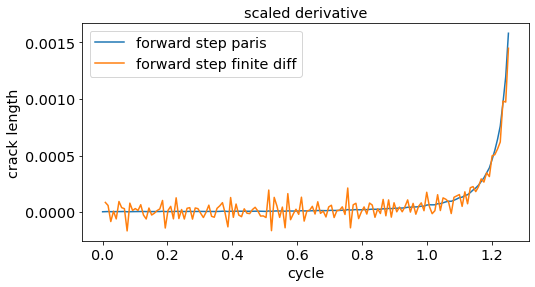

In [35]:

plt.figure(figsize=(8,4))
# plt.plot(all_xscaled[1:], dadN_scaled*(max(train_target) - min(train_target))/(max(train_input) - min(train_input)), label="da/dN")
# plt.plot(all_xscaled, parislaw_rescaled, label="paris law")
plt.plot(all_xscaled, forward_step(0, parislaw_rescaled), label="forward step paris")
plt.plot(all_xscaled[1:], forward_step(0, dadN_scaled*(max(train_target) - min(train_target))/(max(train_input) - min(train_input))), label="forward step finite diff")
plt.legend()
plt.title("scaled derivative")
plt.xlabel("cycle")
plt.ylabel("crack length")

# plt.xlim(0,1)

## linear regression

In [37]:
linreg = sklearn.linear_model.LinearRegression()
linreg.fit(train_input.reshape(-1, 1), train_target.reshape(-1, 1))

LinearRegression()

In [38]:
linreg_train_prediction = linreg.predict(train_input.reshape(-1,1))
linreg_test_prediction = linreg.predict(test_input.reshape(-1,1))

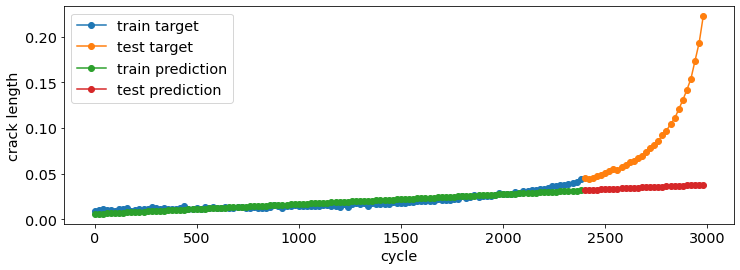

In [39]:
fig = plot_target_prediction(train_input, train_target, linreg_train_prediction, 
                       test_input, test_target, linreg_test_prediction)

## tolerant differential loss

In [76]:
def tolerant_l2_loss(prediction, target, tolerance):
    mse = tnf.mse_loss(prediction, target, reduction="none")
    loss = torch.max(torch.zeros(1).to(device), mse - tolerance**2 * target**2)
    return torch.mean(loss)

def train_model_physics_tolerant_mse(model, traininput, trainlabel, physicsinput, xscaler, yscaler, 
    paris_C , paris_m, paris_dsigma, epochs=5, physics_coeff=1, optim=None, verbose=True):
    
    if optim is None:
        optim = torch.optim.Adam(model.parameters(), lr=1e-1, weight_decay=1e-6)
    
    traininput = traininput.to(device)
    trainlabel = trainlabel.to(device)
    physicsinput = physicsinput.to(device)
#     scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, mode='min', 
#         factor=0.1, patience=10, threshold_mode="rel", threshold=1e-2, verbose=True)

    losses = dict(dataloss=[], physicsloss=[])
    model.train()
    
    for epoch in range(epochs):
        optim.zero_grad()
               
        dataloss, physicsloss, rescaled_derivative, physics_constraint, prediction_physics = compute_data_physics_loss(paris_C, paris_m, paris_dsigma, 
           model, traininput, trainlabel, physicsinput, xscaler, yscaler, physics_coeff=physics_coeff)
        
        tolerant_physicsloss = tolerant_l2_loss(rescaled_derivative, physics_constraint, tolerance=0.1)
        loss = dataloss + physics_coeff * tolerant_physicsloss
        loss.backward()
        optim.step()        
#         scheduler.step(loss)
        losses["dataloss"].append(dataloss.detach().item())
        losses["physicsloss"].append(physicsloss.detach().item())
        
        if verbose and (epochs < 10 or epoch % (epochs//10) == 0):
            print(f"\n Epoch {epoch+1} loss = {loss.detach().item()}") 
            print(f" data loss = {(dataloss).detach().item()} ; tolerant physics loss = {(tolerant_physicsloss).detach().item()}")

#             print(f"physic loss 2 = {physicsloss2.detach().item()}")
#             figs.append(plot_twinx(tensor_to_array(xphysics), tensor_to_array(rescaled_derivative), "derivative",
#                 tensor_to_array(physics_constraint), "predictive paris"))#, paris_law(all_yscaled, paris_C, paris_m, paris_dsigma), "target paris"))

            fig = plt.figure(figsize=(8,4))
            plt.plot(tensor_to_array(physicsinput), tensor_to_array(rescaled_derivative), label="rescaled derivative", marker="o")
            plt.plot(tensor_to_array(physicsinput), tensor_to_array(physics_constraint), label="paris", marker="o")
            plt.legend()
            figs.append(fig)
            
            plt.close()            
    return losses


 Epoch 1 loss = 0.1913996785879135
 data loss = 0.1913996785879135 ; tolerant physics loss = 2.601280952793661e-12

 Epoch 1001 loss = 0.0008192409295588732
 data loss = 0.0008192399982362986 ; tolerant physics loss = 9.127043565371196e-10

 Epoch 2001 loss = 0.0008227946818806231
 data loss = 0.0008227938087657094 ; tolerant physics loss = 8.572014764673952e-10

 Epoch 3001 loss = 0.0008354561286978424
 data loss = 0.0008354553137905896 ; tolerant physics loss = 8.423202690899245e-10

 Epoch 4001 loss = 0.0008232317632064223
 data loss = 0.0008232308900915086 ; tolerant physics loss = 8.490306235842127e-10

 Epoch 5001 loss = 0.0008214106201194227
 data loss = 0.000821409747004509 ; tolerant physics loss = 8.542030416336388e-10

 Epoch 6001 loss = 0.0008207950158976018
 data loss = 0.0008207941427826881 ; tolerant physics loss = 8.447622046325876e-10

 Epoch 7001 loss = 0.0008220687159337103
 data loss = 0.0008220679010264575 ; tolerant physics loss = 8.430353082289344e-10

 Epoch 80

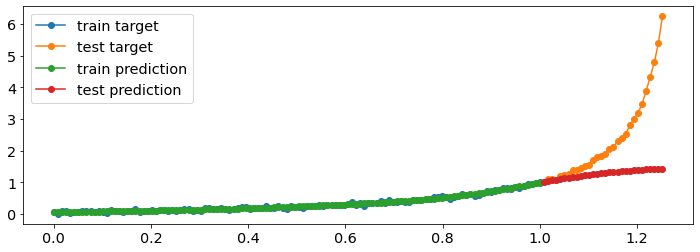

In [77]:
model = FullyConnected([1, 4, 4, 1], activation=nn.Tanh).to(device)
figs=[]
epochs = 10000
physics_coeff = 1

losses = train_model_physics_tolerant_mse(model, train_xtensor, train_ytensor, physics_xtensor, 
    train_xscaler_torch, train_yscaler_torch, paris_C, paris_m, paris_dsigma, epochs=epochs, physics_coeff=physics_coeff)



train_predictions, _ = predict_model(model, train_xtensor)
test_predictions, test_loss = predict_model(model, test_xtensor, test_ytensor)
# print(train_predictions.shape, test_predictions.shape)

# fig = plot_target_prediction(train_xscaled, train_yscaled, torch.exp(train_predictions), 
#                        test_xscaled, test_yscaled, torch.exp(test_predictions))
fig = plot_target_prediction(train_xscaled, train_yscaled, train_predictions, 
                       test_xscaled, test_yscaled, test_predictions)

print(f"{test_loss = }")

## Inverse dirichlet loss weight

In [93]:
def gradient_variance(loss, model):
    allgrad = torch.tensor([]).to(device)
    for module in model.modules():
        if not isinstance(module, nn.Linear): continue
        weightgrad = torch.autograd.grad(loss, module.weight, retain_graph=True)[0]
        biasgrad = torch.autograd.grad(loss, module.bias, retain_graph=True)[0]
#         print(f"{allgrad.shape = } {weightgrad.shape = } {biasgrad.shape = }")
        allgrad = torch.cat((allgrad, weightgrad.view(-1), biasgrad))
#     print(f"{allgrad.shape = }")

    return torch.std(allgrad)

def dirichlet_weight(dataloss, physicsloss, model, old_dataweight, old_physicsweight, moving_oldcoeff):
    data_gradvar = gradient_variance(dataloss, model)
    physics_gradvar = gradient_variance(physicsloss, model)
#     print(f"{data_gradvar = } {physics_gradvar = }")
    
    max_gradvar = torch.max(data_gradvar.detach(), physics_gradvar.detach())    
    dataweight = max_gradvar / data_gradvar
    physicsweight = max_gradvar / physics_gradvar
#     print(f"{dataweight = } {physicsweight = }")
#     weightedloss =  dataweight * dataloss +  physicsweight * physicsloss
    
    new_dataweight = old_dataweight * moving_oldcoeff + dataweight * (1-moving_oldcoeff)
    new_physicsweight = old_physicsweight * moving_oldcoeff + physicsweight * (1-moving_oldcoeff)
    
    return new_dataweight, new_physicsweight

def train_model_physics_dirichlet(model, traininput, trainlabel, physicsinput, xscaler, yscaler, 
    paris_C , paris_m, paris_dsigma, epochs=5, physics_coeff=1, optim=None, verbose=True):
    
    if optim is None:
        optim = torch.optim.Adam(model.parameters(), lr=1e-2, weight_decay=1e-6)
    
    traininput = traininput.to(device)
    trainlabel = trainlabel.to(device)
    physicsinput = physicsinput.to(device)
#     scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, mode='min', 
#         factor=0.1, patience=10, threshold_mode="rel", threshold=1e-2, verbose=True)

    losses = dict(dataloss=[], physicsloss=[])
    model.train()
    dataweight = 1; physicsweight = 1
    moving_oldcoeff = 0.5
    
    for epoch in range(epochs):
        optim.zero_grad()
               
        dataloss, physicsloss, rescaled_derivative, physics_constraint, prediction_physics = compute_data_physics_loss(paris_C, paris_m, paris_dsigma, 
           model, traininput, trainlabel, physicsinput, xscaler, yscaler, physics_coeff=physics_coeff)
        
        dataweight, physicsweight = dirichlet_weight(dataloss, physicsloss, model, dataweight, physicsweight, moving_oldcoeff)
        loss = dataweight * dataloss + physics_coeff * physicsweight * physicsloss
        loss.backward()
        optim.step()        
#         scheduler.step(loss)
        losses["dataloss"].append((dataweight * dataloss).detach().item())
        losses["physicsloss"].append((physics_coeff * physicsweight * physicsloss).detach().item())
        
        if verbose and (epochs < 10 or epoch % (epochs//10) == 0):
            print(f"\n Epoch {epoch+1} loss = {loss.detach().item()}") 
#             print(f"weighted data loss = {(dataweight * dataloss).detach().item()} ; weighted physics loss = {(physicsweight * physicsloss).detach().item()}")
            print(f"weighted data loss = {losses['dataloss'][-1]} ; weighted physics loss = {losses['physicsloss'][-1]}")

            print(f"{dataweight = } {physicsweight = }")

#             print(f"physic loss 2 = {physicsloss2.detach().item()}")
#             figs.append(plot_twinx(tensor_to_array(xphysics), tensor_to_array(rescaled_derivative), "derivative",
#                 tensor_to_array(physics_constraint), "predictive paris"))#, paris_law(all_yscaled, paris_C, paris_m, paris_dsigma), "target paris"))

            fig = plt.figure(figsize=(8,4))
            plt.plot(tensor_to_array(physicsinput), tensor_to_array(rescaled_derivative), label="rescaled derivative", marker="o")
            plt.plot(tensor_to_array(physicsinput), tensor_to_array(physics_constraint), label="paris", marker="o")
            plt.legend()
            figs.append(fig)
            
            plt.close()            
    return losses

In [94]:
# for module in model.modules():
#     if isinstance(module, nn.Linear):
#         print(module.weight.grad)


 Epoch 1 loss = 0.10751491785049438
weighted data loss = 0.08373495936393738 ; weighted physics loss = 0.02377995476126671
dataweight = tensor(1.) physicsweight = tensor(1.3319e+08)

 Epoch 1001 loss = 0.04982296749949455
weighted data loss = 0.018447954207658768 ; weighted physics loss = 0.031375013291835785
dataweight = tensor(1.) physicsweight = tensor(6.9495e+08)

 Epoch 2001 loss = 0.04994271695613861
weighted data loss = 0.018489733338356018 ; weighted physics loss = 0.03145298361778259
dataweight = tensor(1.) physicsweight = tensor(6.9760e+08)

 Epoch 3001 loss = 0.050219062715768814
weighted data loss = 0.01865769922733307 ; weighted physics loss = 0.031561363488435745
dataweight = tensor(1.) physicsweight = tensor(7.0375e+08)

 Epoch 4001 loss = 0.05159910023212433
weighted data loss = 0.019490892067551613 ; weighted physics loss = 0.032108210027217865
dataweight = tensor(1.) physicsweight = tensor(7.3974e+08)

 Epoch 5001 loss = 0.053233593702316284
weighted data loss = 0.02

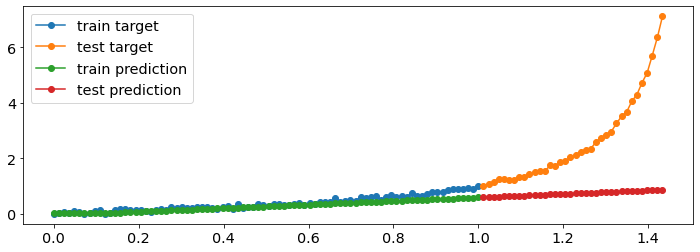

In [96]:
model = FullyConnected([1, 4, 4, 1]).to(device)
figs=[]
epochs = 10000
physics_coeff = 1

losses = train_model_physics_dirichlet(model, train_xtensor, train_ytensor, physics_xtensor, 
    train_xscaler_torch, train_yscaler_torch, paris_C, paris_m, paris_dsigma, epochs=epochs, physics_coeff=physics_coeff)

train_predictions, _ = predict_model(model, train_xtensor)
test_predictions, test_loss = predict_model(model, test_xtensor, test_ytensor)
# print(train_predictions.shape, test_predictions.shape)

# fig = plot_target_prediction(train_xscaled, train_yscaled, torch.exp(train_predictions), 
#                        test_xscaled, test_yscaled, torch.exp(test_predictions))
fig = plot_target_prediction(train_xtensor, train_ytensor, train_predictions, 
                       test_xtensor, test_ytensor, test_predictions)

print(f"{test_loss = }")

In [ ]:
figs[-1]

In [ ]:
fig = plot_twinx(np.arange(epochs), losses["dataloss"], "dataloss", losses["physicsloss"], "physicsloss")

In [ ]:
model = FullyConnectedExp([1, 4, 4, 1]).to(device)
figs=[]
epochs = 100
physics_coeff = 1

losses = train_model_physics_dirichlet(model, train_xtensor, train_ytensor, physics_xtensor, 
    train_xscaler_torch, train_yscaler_torch, paris_C, paris_m, paris_dsigma, epochs=epochs, physics_coeff=physics_coeff)



train_predictions, _ = predict_model(model, train_xtensor)
test_predictions, test_loss = predict_model(model, test_xtensor, test_ytensor)
# print(train_predictions.shape, test_predictions.shape)

# fig = plot_target_prediction(train_xscaled, train_yscaled, torch.exp(train_predictions), 
#                        test_xscaled, test_yscaled, torch.exp(test_predictions))
fig = plot_target_prediction(train_xscaled, train_yscaled, train_predictions, 
                       test_xscaled, test_yscaled, test_predictions)

print(f"{test_loss = }")

In [ ]:
figs[-1]

In [ ]:
fig = plot_twinx(np.arange(epochs), losses["dataloss"], "dataloss", losses["physicsloss"], "physicsloss")

## LBFGS

In [ ]:
# tensor_to_array = lambda tensor: tensor.detach().cpu().numpy().squeeze()
# array_to_tensor = lambda array: torch.tensor(array).to(device)

def train_model_physics_lbfgs_backup(model, traininput, trainlabel, testinput, xscaler, yscaler, 
    C , m, dsigma, epochs=5, physics_coeff=1, verbose=True):
    optim = torch.optim.LBFGS(model.parameters(), lr=1e-3, history_size=10, max_iter=4)
    traininput = traininput.to(device)
    trainlabel = trainlabel.to(device)
    testinput = testinput.to(device)
#     scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, mode='min', 
#         factor=0.1, patience=10, threshold_mode="rel", threshold=1e-2, verbose=True)

    losses = dict(dataloss=[], physicsloss=[])
    model.train()
    
    for epoch in range(epochs):
        dataloss = None; physicsloss = None; loss = None
        def closure():
            nonlocal dataloss; nonlocal physicsloss; nonlocal loss
            optim.zero_grad()
            outputdata = model(traininput)
    #         predictions = outputdata[0]
    #         print(f"{predictions.shape=}, {trainlabel.shape=}")
            dataloss = tnf.mse_loss(outputdata, trainlabel)

            min_input = min(min(traininput), min(testinput)).detach().item()
            max_input = max(max(traininput), max(testinput)).detach().item()
            xphysics = torch.linspace(min_input, max_input, steps=100).reshape(-1, 1).requires_grad_(True).to(device)        
            yphysics = model(xphysics)       

            derivative = torch.autograd.grad(outputs=yphysics, inputs=xphysics, 
                grad_outputs=torch.ones_like(xphysics), retain_graph=True, create_graph=True)[0]
            physics_constraint = paris_law(yscaler.inverse(yphysics), paris_C, paris_m, paris_dsigma)

            rescaled_derivative = derivative * (yscaler.max - yscaler.min) / (xscaler.max - xscaler.min)
            physicsloss = physics_coeff * torch.mean(torch.pow(rescaled_derivative - physics_constraint, 2))        

            loss = dataloss + physicsloss
            loss.backward()
            
            return loss
        
        optim.step(closure)        
#         scheduler.step(loss)
#         losses["dataloss"].append(dataloss.detach().item())
#         losses["physicsloss"].append(physicsloss.detach().item())

        if epochs < 10 or epoch % (epochs//10) == 0:
#             loss = closure()
#             print(f"Epoch {epoch+1} data loss = {dataloss.detach().item()} ; physics loss = {physicsloss.detach().item()}")
            print(f"\n Epoch {epoch+1} loss = {loss.detach().item()}") 
            print(f"data loss = {dataloss.detach().item()} ; physics loss = {physicsloss.detach().item()}")#             figs.append(plot_twinx(tensor_to_array(xphysics), tensor_to_array(derivative), "derivative",
#                 tensor_to_array(physics_constraint), "predictive paris"))#, paris_law(all_yscaled, paris_C, paris_m, paris_dsigma), "target paris"))
#             plt.close()
            
    return losses

In [ ]:
# tensor_to_array = lambda tensor: tensor.detach().cpu().numpy().squeeze()
# array_to_tensor = lambda array: torch.tensor(array).to(device)

def train_model_physics_lbfgs(model, traininput, trainlabel, physicsinput, xscaler, yscaler, 
    C , m, dsigma, epochs=5, physics_coeff=1, optim=None, verbose=True):
    
    if optim is None:
        optim = torch.optim.LBFGS(model.parameters(), lr=1e-3, history_size=20, max_iter=8)
    
    traininput = traininput.to(device)
    trainlabel = trainlabel.to(device)
    physicsinput = physicsinput.to(device)
#     scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, mode='min', 
#         factor=0.1, patience=10, threshold_mode="rel", threshold=1e-2, verbose=True)

    losses = dict(dataloss=[], physicsloss=[])
    model.train()
    
    for epoch in range(epochs):
        dataloss = None; physicsloss = None; loss = None
        def closure():
            nonlocal dataloss; nonlocal physicsloss; nonlocal loss
            optim.zero_grad()

            dataloss, physicsloss, rescaled_derivative, physics_constraint, prediction_physics = compute_data_physics_loss(paris_C, paris_m, paris_dsigma, 
               model, traininput, trainlabel, physicsinput, xscaler, yscaler, physics_coeff=physics_coeff)      
        
            loss = dataloss + physicsloss
            loss.backward()
            
            return loss
        
        optim.step(closure)        
#         scheduler.step(loss)
        losses["dataloss"].append(dataloss.detach().item())
        losses["physicsloss"].append(physicsloss.detach().item())

        if verbose and (epochs < 10 or epoch % (epochs//10) == 0):
#             loss = closure()
#             print(f"Epoch {epoch+1} data loss = {dataloss.detach().item()} ; physics loss = {physicsloss.detach().item()}")
            print(f"\n Epoch {epoch+1} loss = {loss.detach().item()}") 
            print(f"data loss = {dataloss.detach().item()} ; physics loss = {physicsloss.detach().item()}")
        #             figs.append(plot_twinx(tensor_to_array(xphysics), tensor_to_array(derivative), "derivative",
#                 tensor_to_array(physics_constraint), "predictive paris"))#, paris_law(all_yscaled, paris_C, paris_m, paris_dsigma), "target paris"))
#             plt.close()
            
    return losses

In [ ]:
model_lbfgs = FullyConnected([1, 16, 16, 1]).to(device)
figs=[]
epochs = 100
physics_coeff=1e6
# fig = plt.figure(1, figsize=(12,4))

# random_seed=2022
# set_random_seed(random_seed)

losses = train_model_physics_lbfgs(model_lbfgs, train_xtensor[:], train_ytensor[:], physics_xtensor[:], 
    train_xscaler_torch, train_yscaler_torch, paris_C, paris_m, paris_dsigma, epochs=epochs, physics_coeff=physics_coeff)

train_predictions, _ = predict_model(model_lbfgs, train_xtensor)
test_predictions, test_loss = predict_model(model_lbfgs, test_xtensor, test_ytensor)

fig = plot_target_prediction(train_xscaled, train_yscaled, train_predictions, 
                       test_xscaled, test_yscaled, test_predictions)

print(f"{test_loss = }")

In [ ]:
model_lbfgs = FullyConnectedExp([1, 16, 16, 1]).to(device)
figs=[]
epochs = 100
physics_coeff=1e6
# fig = plt.figure(1, figsize=(12,4))

# random_seed=2022
# set_random_seed(random_seed)

losses = train_model_physics_lbfgs(model_lbfgs, train_xtensor[:], train_ytensor[:], physics_xtensor[:], 
    train_xscaler_torch, train_yscaler_torch, paris_C, paris_m, paris_dsigma, epochs=epochs, physics_coeff=physics_coeff)

train_predictions, _ = predict_model(model_lbfgs, train_xtensor)
test_predictions, test_loss = predict_model(model_lbfgs, test_xtensor, test_ytensor)

fig = plot_target_prediction(train_xscaled, train_yscaled, train_predictions, 
                       test_xscaled, test_yscaled, test_predictions)

print(f"{test_loss = }")

In [ ]:
model_adam = FullyConnected([1, 16, 16, 1]).to(device)
figs=[]
epochs = 100
physics_coeff=1e9
# fig = plt.figure(1, figsize=(12,4))

# random_seed=2022
# set_random_seed(random_seed)

losses = train_model_physics(model_adam, train_xtensor, train_ytensor, physics_xtensor, 
    train_xscaler_torch, train_yscaler_torch, paris_C, paris_m, paris_dsigma, epochs=epochs, physics_coeff=physics_coeff)


train_predictions, _ = predict_model(model_adam, train_xtensor)
test_predictions, test_loss = predict_model(model_adam, test_xtensor, test_ytensor)

fig = plot_target_prediction(train_xscaled, train_yscaled, train_predictions, 
                       test_xscaled, test_yscaled, test_predictions)

print(f"{test_loss = }")

In [ ]:
model_sgd = FullyConnected([1, 4, 4, 1]).to(device)
figs=[]
epochs = 100
physics_coeff=1e10
# fig = plt.figure(1, figsize=(12,4))


# random_seed=2023
# set_random_seed(random_seed)

losses = train_model_physics(model_sgd, train_xtensor[:], train_ytensor[:], physics_xtensor[:], 
    train_xscaler_torch, train_yscaler_torch, paris_C, paris_m, paris_dsigma, epochs=epochs, physics_coeff=physics_coeff,
    optim=torch.optim.SGD(model_sgd.parameters(), lr=1e-2))

train_predictions, _ = predict_model(model_sgd, train_xtensor)
test_predictions, test_loss = predict_model(model_sgd, test_xtensor, test_ytensor)

fig = plot_target_prediction(train_xscaled, train_yscaled, train_predictions, 
                       test_xscaled, test_yscaled, test_predictions)

print(f"{test_loss = }")

## constrained optimization

https://cooper.readthedocs.io/en/latest/auto_tutorials/plot_gaussian_mixture.html

In [ ]:
class TwoStepMinimization(cooper.ConstrainedMinimizationProblem):
    def __init__(self, dataloss_max, tolerance, is_constrained=True):
        super().__init__(is_constrained=is_constrained)
        self.dataloss_max = dataloss_max
        self.tolerance = tolerance

    def closure(self, dataloss, physicsloss):
        # |dataloss - maxloss| <= tolerance
        ineq_defect = torch.abs(dataloss - self.dataloss_max) - self.tolerance
#         print(ineq_defect)
        state = cooper.CMPState(
            loss=physicsloss,
            ineq_defect=ineq_defect,
        )
        return state

In [ ]:
def train_constrained_lagrangian(model, traininput, trainlabel, physicsinput, xscaler, yscaler, 
    paris_C , paris_m, paris_dsigma, dataloss_max, tolerance, epochs=5, physics_coeff=1, verbose=True):
    
    cmp = TwoStepMinimization(dataloss_max=dataloss_max, tolerance=tolerance)
    formulation = cooper.LagrangianFormulation(cmp)

    primal_optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)#, weight_decay=1e-6)
    dual_optimizer = cooper.optim.partial(torch.optim.Adam, lr=1e-2)#, momentum=0.7)

    constrained_optimizer = cooper.ConstrainedOptimizer(
        formulation=formulation,
        primal_optimizer=primal_optimizer,
        dual_optimizer=dual_optimizer,
    )

    losses = dict(dataloss=[], physicsloss=[])
    for epoch in range(epochs):
        constrained_optimizer.zero_grad()
        
        dataloss, physicsloss, rescaled_derivative, physics_constraint, prediction_physics = compute_data_physics_loss(paris_C, paris_m, paris_dsigma, 
           model, traininput, trainlabel, physicsinput, xscaler, yscaler, physics_coeff=physics_coeff)
        
#         print(dataloss, physicsloss)
        lagrangian = formulation.composite_objective(cmp.closure, dataloss.cpu(), physicsloss.cpu())
        formulation.custom_backward(lagrangian)
        constrained_optimizer.step()
        
        losses["dataloss"].append(dataloss.detach().item())
        losses["physicsloss"].append(physicsloss.detach().item())

        if verbose and (epochs < 10 or epoch % (epochs//10) == 0):
            print(f"\n Epoch {epoch+1} ineq_defect = {cmp.closure(dataloss.cpu(), physicsloss.cpu()).ineq_defect}") 
            print(f"data loss = {dataloss.detach().item()} ; physics loss = {physicsloss.detach().item()}")

    return losses

In [ ]:
model = FullyConnected([1, 16, 16, 1]).to(device)
figs=[]
epochs = 100


physics_coeff=1
losses = train_model_physics(model, train_xtensor, train_ytensor, physics_xtensor, 
    train_xscaler_torch, train_yscaler_torch, paris_C, paris_m, paris_dsigma, epochs=epochs, physics_coeff=physics_coeff)

train_predictions, _ = predict_model(model, train_xtensor)
test_predictions, test_loss = predict_model(model, test_xtensor, test_ytensor)

fig = plot_target_prediction(train_xscaled, train_yscaled, train_predictions, 
                       test_xscaled, test_yscaled, test_predictions)

In [ ]:
physics_coeff=1e10
losses = train_constrained_lagrangian(model, train_xtensor.to(device), train_ytensor.to(device), physics_xtensor.to(device), 
    train_xscaler_torch, train_yscaler_torch, paris_C, paris_m, paris_dsigma, dataloss_max=0.001, tolerance=0.0005 , epochs=epochs, physics_coeff=physics_coeff,
)
    
train_predictions, _ = predict_model(model, train_xtensor)
test_predictions, test_loss = predict_model(model, test_xtensor, test_ytensor)

fig = plot_target_prediction(train_xscaled, train_yscaled, train_predictions, 
                       test_xscaled, test_yscaled, test_predictions)

In [ ]:
def generate_mog_dataset():
    """
    Generate a MoG dataset on 2D, with two classes.
    """

    n_per_class = 100
    dim = 2
    n_gaussians = 4
    mus = [(0, 1), (-1, 0), (0, -1), (1, 0)]
    mus = [torch.tensor(m) for m in mus]
    var = 0.05

    inputs, labels = [], []

    for id in range(n_gaussians):
        # Generate input data by mu + x @ sqrt(cov)
        cov = np.sqrt(var) * torch.eye(dim)
        mu = mus[id]
        inputs.append(mu + torch.randn(n_per_class, dim) @ cov)

        # Labels
        labels.append(torch.tensor(n_per_class * [1.0 if id < 2 else 0.0]))

    return torch.cat(inputs, dim=0), torch.cat(labels, dim=0)


def plot_pane(ax, inputs, x1, x2, achieved_const, titles, colors):
    const_str = str(np.round(achieved_const, 0)) + "%"
    ax.scatter(*torch.transpose(inputs, 0, 1), color=colors)
    ax.plot(x1, x2, color="gray", linestyle="--")
    ax.fill_between(x1, -2, x2, color=blue, alpha=0.1)
    ax.fill_between(x1, x2, 2, color=red, alpha=0.1)

    ax.set_aspect("equal")
    ax.set_xlim(-2, 2)
    ax.set_ylim(-2, 2)
    ax.set_title(titles[idx] + " - Pred. Blue Prop.: " + const_str)


class MixtureSeparation(cooper.ConstrainedMinimizationProblem):
    """
    Implements CMP for separating the MoG dataset with a linear predictor.

    Args:
        is_constrained: Flag to apply or not the constraint on the percentage of
            points predicted as belonging to the blue class
        use_proxy: Flag to use proxy-constraints. If ``True``, we use a hinge
            relaxation. Defaults to ``False``.
        const_level: Minimum proportion of points to be predicted as belonging
            to the blue class. Ignored when ``is_constrained==False``. Defaults
            to ``0.7``.
    """

    def __init__(
        self, is_constrained: bool, use_proxy: bool = False, const_level: float = 0.7
    ):

        super().__init__(is_constrained=is_constrained)

        self.const_level = const_level
        self.use_proxy = use_proxy

    def closure(self, model, inputs, targets):

        logits = model(inputs)
        loss = bce_loss(logits.flatten(), targets)

        if not self.is_constrained:
            # Unconstrained problem of separating two classes
            state = cooper.CMPState(
                loss=loss,
            )
        else:
            # Separating classes s.t. predicting at least const_level as class 0

            # Hinge approximation of the rate
            probs = torch.sigmoid(logits)
            hinge = torch.mean(torch.max(torch.zeros_like(probs), 1 - probs))

            # level - proxy_ineq_defect <= 0
            hinge_defect = self.const_level - hinge

            if not self.use_proxy:
                ineq_defect = hinge_defect
                proxy_ineq_defect = None
            else:
                # Use non-proxy defects to update the Lagrange multipliers

                # Proportion of elements in class 0 is the non-proxy defect
                classes = logits >= 0.0
                prop_0 = torch.sum(classes == 0) / targets.numel()
                ineq_defect = self.const_level - prop_0
                proxy_ineq_defect = hinge_defect

            state = cooper.CMPState(
                loss=loss,
                ineq_defect=ineq_defect,
                proxy_ineq_defect=proxy_ineq_defect,
            )

        return state


def train(problem_name, inputs, targets, num_iters=5000, lr=1e-2, const_level=0.7):
    """
    Train via SGD
    """

    is_constrained = problem_name.lower() in ["constrained", "proxy"]
    use_proxy = problem_name.lower() == "proxy"

    model = torch.nn.Linear(2, 1)

    cmp = MixtureSeparation(is_constrained, use_proxy, const_level)
    formulation = cooper.LagrangianFormulation(cmp)

    primal_optimizer = SGD(model.parameters(), lr=lr, momentum=0.7)

    if is_constrained:
        dual_optimizer = cooper.optim.partial(SGD, lr=lr, momentum=0.7)
    else:
        dual_optimizer = None

    constrained_optimizer = cooper.ConstrainedOptimizer(
        formulation=formulation,
        primal_optimizer=primal_optimizer,
        dual_optimizer=dual_optimizer,
    )

    for i in range(num_iters):
        constrained_optimizer.zero_grad()
        if is_constrained:
            lagrangian = formulation.composite_objective(
                cmp.closure, model, inputs, targets
            )
            formulation.custom_backward(lagrangian)
        else:
            # No Lagrangian in the unconstrained case
            loss = cmp.closure(model, inputs, targets).loss
            loss.backward()

        constrained_optimizer.step()

    # Number of elements predicted as class 0 in the train set after training
    logits = model(inputs)
    pred_classes = logits >= 0.0
    prop_0 = torch.sum(pred_classes == 0) / targets.numel()

    return model, 100 * prop_0.item()


# Plot configs
titles = ["Unconstrained", "Constrained", "Proxy"]
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Data and training configs
inputs, labels = generate_mog_dataset()
const_level = 0.7
lr = 2e-2
num_iters = 5000

for idx, name in enumerate(titles):

    model, achieved_const = train(
        name, inputs, labels, lr=lr, num_iters=num_iters, const_level=const_level
    )

    # Compute decision boundary
    weight, bias = model.weight.data.flatten().numpy(), model.bias.data.numpy()
    x1 = np.linspace(-2, 2, 100)
    x2 = (-1 / weight[1]) * (weight[0] * x1 + bias)

    # Color points according to true label
    red, blue = style_utils.COLOR_DICT["red"], style_utils.COLOR_DICT["blue"]
    colors = [red if _ == 1 else blue for _ in labels.flatten()]
    plot_pane(axs[idx], inputs, x1, x2, achieved_const, titles, colors)

fig.suptitle("Goal: Predict at least " + str(const_level * 100) + "% as blue")
plt.show()


## loss landscape

In [ ]:
# %matplotlib ipympl

In [ ]:
landscape_step = 40
xlandscape = np.array([[j for j in range(landscape_step)] for i in range(landscape_step)])
ylandscape = np.array([[i for _ in range(landscape_step)] for i in range(landscape_step)])
# print(xlandscape.shape, ylandscape.shape)

In [ ]:
class DataPhysicsLoss(loss_landscapes.metrics.Metric):
#     def __init__(self, xdata, ydata, xphysics, yphysics, physics_coeff):
    def __init__(self, xdata, ydata, xscaler, yscaler, physics_coeff):
        super().__init__()
        self.xdata = xdata
        self.ydata = ydata
#         self.xphysics = xphysics
#         self.yphysics = yphysics
        self.physics_coeff = physics_coeff
        self.xscaler = xscaler
        self.yscaler = yscaler
        
    def __call__(self, model_wrapper):
#         data_prediction = model_wrapper.forward(self.xdata)
#         dataloss = tnf.mse_loss(data_prediction, self.ydata)

        min_input = min(self.xdata).detach().item()
        max_input = max(self.xdata).detach().item()
        xphysics = torch.linspace(min_input, max_input, steps=200).reshape(-1, 1).requires_grad_(True)
#         prediction_physics = model_wrapper.forward(xphysics)       

#         derivative = torch.autograd.grad(outputs=prediction_physics, inputs=xphysics, 
#             grad_outputs=torch.ones_like(xphysics), retain_graph=True, create_graph=True)[0]
#         physics_constraint = paris_law(self.yscaler.inverse(prediction_physics), paris_C, paris_m, paris_dsigma)

#         rescaled_derivative = derivative * (self.yscaler.max - self.yscaler.min) / (self.xscaler.max - self.xscaler.min)
#         physicsloss = self.physics_coeff * torch.mean(torch.pow(rescaled_derivative - physics_constraint, 2))    
        dataloss, physicsloss, rescaled_derivative, physics_constraint, prediction_physics = compute_data_physics_loss(paris_C, paris_m, paris_dsigma, 
               model_wrapper.forward, self.xdata, self.ydata, xphysics, self.xscaler, self.yscaler, physics_coeff=self.physics_coeff)      
    
        loss = dataloss + physicsloss
        
        return loss.detach().numpy()

In [ ]:
model_lbfgs.eval()
# metric = loss_landscapes.metrics.Loss(tnf.mse_loss, train_xtensor, train_ytensor)
metric = DataPhysicsLoss(train_xtensor, train_ytensor, train_xscaler_torch, train_yscaler_torch, physics_coeff=physics_coeff)
loss_data = loss_landscapes.random_plane(model_lbfgs.cpu(), metric, distance=120, steps=landscape_step, normalization='filter', deepcopy_model=True)

In [ ]:
plt.figure()
plt.contour(loss_data, levels=50)
plt.title('Loss Contours around Model LBFGS')
plt.colorbar()
plt.show()


In [ ]:
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection='3d')
surface = ax.plot_surface(xlandscape, ylandscape, loss_data, rstride=1, cstride=1, cmap='viridis', edgecolor='none')
ax.set_title('Loss Landscape Surface LBFGS')
fig.colorbar(surface)
# fig.show()

In [ ]:
model_adam.eval()
# metric = loss_landscapes.metrics.Loss(tnf.mse_loss, train_xtensor, train_ytensor)
metric = DataPhysicsLoss(train_xtensor, train_ytensor, train_xscaler_torch, train_yscaler_torch, physics_coeff=physics_coeff)
loss_data = loss_landscapes.random_plane(model_adam.cpu(), metric, distance=120, steps=landscape_step, normalization='filter', deepcopy_model=True)

In [ ]:
plt.figure()
plt.contour(loss_data, levels=50)
plt.title('Loss Contours Model Adam')
plt.colorbar()
plt.show()


In [ ]:
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection='3d')
surface = ax.plot_surface(xlandscape, ylandscape, loss_data, rstride=1, cstride=1, cmap='viridis', edgecolor='none')
ax.set_title('Loss Landscape Surface Adam')
fig.colorbar(surface)
# fig.show()

In [ ]:
model.eval()
# metric = loss_landscapes.metrics.Loss(tnf.mse_loss, train_xtensor, train_ytensor)
metric = DataPhysicsLoss(train_xtensor, train_ytensor, train_xscaler_torch, train_yscaler_torch, physics_coeff=physics_coeff)
loss_data = loss_landscapes.random_plane(model.cpu(), metric, distance=120, steps=landscape_step, normalization='filter', deepcopy_model=True)

In [ ]:
plt.figure()
plt.contour(loss_data, levels=50)
plt.title('Loss Contours Model Adam')
plt.colorbar()
plt.show()


In [ ]:
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection='3d')
surface = ax.plot_surface(xlandscape, ylandscape, loss_data, rstride=1, cstride=1, cmap='viridis', edgecolor='none')
ax.set_title('Loss Landscape Surface Adam')
fig.colorbar(surface)
# fig.show()

In [ ]:
# %matplotlib inline

## bayesian optimization basic

In [ ]:
# for name, param in model.named_parameters():
#     print(name, " ; " , param.data)

model.state_dict()

In [ ]:
def build_ax_parameters(model):
    statedict = model.cpu().state_dict()
    allparams = []
    for layername, layerparam in statedict.items():
#         print(layername, layerparam.shape)
        for i, paramvalue in enumerate(layerparam.flatten()):
            allparams.append(dict(
                name=f"{layername}.{i}",
                type="range",
                bounds=[-2.0, 2.0],
                value_type="float"
            ))
    return allparams

# ax_parameters = build_ax_parameters(model)
# pprint(ax_parameters)

In [ ]:
def build_torch_state_dict(axvalues, old_statedict):
    new_statedict = copy.deepcopy(old_statedict)
    statedict = {}
#     pprint(axvalues)
    for paramname, paramvalue in axvalues.items():
        layername = paramname[0:paramname.rfind(".")]
        statedict.setdefault(layername, []).append(paramvalue)
        
    for layername in old_statedict.keys():
#         print(layername)
        new_statedict[layername] = torch.tensor(statedict[layername]).reshape(new_statedict[layername].shape).to(device)
    return new_statedict

In [ ]:
def evaluate_objective(parameters, model, traininput, traintarget, physicsinput, xscaler, yscaler, physics_coeff):
    new_statedict = build_torch_state_dict(parameters, model.state_dict())
#     pprint(new_statedict)
    model.load_state_dict(new_statedict)
#     print(model)
        
    dataloss, physicsloss, rescaled_derivative, physics_constraint, prediction_physics = compute_data_physics_loss(paris_C, paris_m, paris_dsigma, 
       model.to(device), traininput.to(device), traintarget.to(device), physicsinput, xscaler, yscaler, physics_coeff=physics_coeff)      
        
#     loss = dataloss + physicsloss

    return {"dataphysics": (loss.detach().item(), 0.0)}

def evaluate_multi_objective(parameters, model, traininput, traintarget, physicsinput, xscaler, yscaler, physics_coeff):
    new_statedict = build_torch_state_dict(parameters, model.state_dict())
#     pprint(new_statedict)
    model.load_state_dict(new_statedict)
#     print(model)
        
    dataloss, physicsloss, rescaled_derivative, physics_constraint, prediction_physics = compute_data_physics_loss(paris_C, paris_m, paris_dsigma, 
       model.to(device), traininput.to(device), traintarget.to(device), physicsinput, xscaler, yscaler, physics_coeff=physics_coeff)      
        
    return dict(
        data=(dataloss.detach().item(), 0.0),
        physics=(1e9 * physicsloss.detach().item(), 0.0),   
    )

In [ ]:
def ax_optimize(axclient, model, traininput, traintarget, physicsinput, xscaler, yscaler, physics_coeff, trials=50):
    for i in range(trials):
        parameters, trial_index = axclient.get_next_trial()
        axclient.complete_trial(
            trial_index=trial_index, 
            raw_data=evaluate_multi_objective(parameters, model, traininput, traintarget, physicsinput, xscaler, yscaler, physics_coeff))



In [ ]:
model_bayesopt = FullyConnected([1, 4, 4, 1]).to(device)

ax_client = AxClient(torch_device=device, verbose_logging=False)
ax_client.create_experiment(
    name="dataphysics",
    parameters=build_ax_parameters(model_bayesopt),
    objectives={
        "data": ObjectiveProperties(minimize=True),
        "physics": ObjectiveProperties(minimize=True),
    },
)

ax_optimize(ax_client, model_bayesopt, train_xtensor, train_ytensor, physics_xtensor,
    train_xscaler_torch, train_yscaler_torch, physics_coeff, trials=200)

In [ ]:
ax_client.get_trials_data_frame()
# ax_client.generation_strategy.trials_as_df

In [ ]:
# ax_parameters, ax_values = ax_client.get_best_parameters()
# # print(f"Best parameters: {parameters}")expected improvement
# print(f"Corresponding mean: {ax_values[0]}, covariance: {ax_values[1]}")

# new_statedict = build_torch_state_dict(ax_parameters, model_bayesopt.state_dict())
# #     pprint(new_statedict)
# model_bayesopt.load_state_dict(new_statedict)


In [ ]:
figs=[]
pareto_front = ax_client.get_pareto_optimal_parameters()
for iteration, result in pareto_front.items():
    new_statedict = build_torch_state_dict(result[0], model_bayesopt.state_dict())
    #     pprint(new_statedict)
    model_bayesopt.load_state_dict(new_statedict)
    train_predictions, _ = predict_model(model_bayesopt, train_xtensor)
    test_predictions, test_loss = predict_model(model_bayesopt, test_xtensor, test_ytensor)

    fig = plot_target_prediction(train_xscaled, train_yscaled, train_predictions, 
                           test_xscaled, test_yscaled, test_predictions, title=f"dataloss={result[1][0]['data']} physicsloss={result[1][0]['physics']}")
    figs.append(fig)


In [ ]:
train_predictions, _ = predict_model(model_bayesopt, train_xtensor)
test_predictions, test_loss = predict_model(model_bayesopt, test_xtensor, test_ytensor)

fig = plot_target_prediction(train_xscaled, train_yscaled, train_predictions, 
                       test_xscaled, test_yscaled, test_predictions)

print(f"{test_loss = }")

In [ ]:
render(ax_client.get_contour_plot(metric_name="data"))

In [ ]:
render(ax_client.get_contour_plot("layers.0.weight.2", "layers.0.weight.3"))

In [ ]:
render(ax_client.get_optimization_trace())

In [ ]:
losses = train_model_physics_lbfgs(model_bayesopt, train_xtensor[:], train_ytensor[:], physics_xtensor[:], 
    train_xscaler_torch, train_yscaler_torch, paris_C, paris_m, paris_dsigma, epochs=epochs, physics_coeff=physics_coeff)

train_predictions, _ = predict_model(model_bayesopt, train_xtensor)
test_predictions, test_loss = predict_model(model_bayesopt, test_xtensor, test_ytensor)

fig = plot_target_prediction(train_xscaled, train_yscaled, train_predictions, 
                       test_xscaled, test_yscaled, test_predictions)

print(f"{test_loss = }")


## bayesian optimization advanced

In [ ]:
gen_strat = GenerationStrategy(
    steps=[
        # 1. Initialization step (does not require pre-existing data and is well-suited for 
        # initial sampling of the search space)
        GenerationStep(
            model=Models.SOBOL,
            num_trials=16,  # How many trials should be produced from this generation step
#             min_trials_observed=3, # How many trials need to be completed to move to next model
            max_parallelism=10,  # Max parallelism for this step
#             model_kwargs={"torch_device": device}
        ),
        # 2. Bayesian optimization step (requires data obtained from previous phase and learns
        # from all data available at the time of each new candidate generation call)
        GenerationStep(
            model=Models.GPEI,
            num_trials=-1,  # No limitation on how many trials should be produced from this step
            max_parallelism=3,  # Parallelism limit for this step, often lower than for Sobol
            # More on parallelism vs. required samples in BayesOpt:
            # https://ax.dev/docs/bayesopt.html#tradeoff-between-parallelism-and-total-number-of-trials
        ),
    ]
)


In [ ]:
model_bayesopt = FullyConnected([1, 4, 1]).to(device)

ax_client = AxClient(generation_strategy=gen_strat, verbose_logging=False, torch_device=device)
ax_client.create_experiment(
    name="dataphysics",
    parameters=build_ax_parameters(model_bayesopt),
    objectives={
        "dataphysics": ObjectiveProperties(minimize=True),
    },
)

ax_optimize(ax_client, model_bayesopt, train_xtensor, train_ytensor, physics_xtensor,
    train_xscaler_torch, train_yscaler_torch, physics_coeff, trials=64)

ax_parameters, ax_values = ax_client.get_best_parameters()
# print(f"Best parameters: {parameters}")expected improvement
print(f"Corresponding mean: {ax_values[0]}, covariance: {ax_values[1]}")

new_statedict = build_torch_state_dict(ax_parameters, model_bayesopt.state_dict())
#     pprint(new_statedict)
model_bayesopt.load_state_dict(new_statedict)


train_predictions, _ = predict_model(model_bayesopt, train_xtensor)
test_predictions, test_loss = predict_model(model_bayesopt, test_xtensor, test_ytensor)

fig = plot_target_prediction(train_xscaled, train_yscaled, train_predictions, 
                       test_xscaled, test_yscaled, test_predictions)

print(f"{test_loss = }")

In [ ]:
epochs=100
losses = train_model_physics(model_bayesopt, train_xtensor[:], train_ytensor[:], physics_xtensor[:], 
    train_xscaler_torch, train_yscaler_torch, paris_C, paris_m, paris_dsigma, epochs=epochs, physics_coeff=physics_coeff)

train_predictions, _ = predict_model(model_bayesopt, train_xtensor)
test_predictions, test_loss = predict_model(model_bayesopt, test_xtensor, test_ytensor)

fig = plot_target_prediction(train_xscaled, train_yscaled, train_predictions, 
                       test_xscaled, test_yscaled, test_predictions)

print(f"{test_loss = }")

## Optimization experiment

In [ ]:
def initialize_result(filepath):
    header = "optimizer,trainloss,physicsloss,testloss,duration_seconds,randomseed\n"
    with open(filepath, "w") as file:
        file.write(header)    
    return header

def append_result(filepath, optimizer, trainloss, physicsloss, testloss, duration, randomseed):
    line = f"{optimizer},{trainloss},{physicsloss},{testloss},{duration},{randomseed}\n"
    with open(filepath, "a") as file:
        file.write(line)
    return line

        

In [ ]:
def run_single_optimizer(train_function, optimname, iteration, resultpath, optim=None):
    starttime = time.time()

    model = FullyConnected([1, 4, 1]).to(device)
    epochs = 100
    physics_coeff=1e10
    
    if optimname == "sgd":
#         print("sgd")
        optim = torch.optim.SGD(model.parameters(), lr=1e-2)

    losses = train_function(model, train_xtensor, train_ytensor, physics_xtensor, train_xscaler_torch, train_yscaler_torch, 
        paris_C, paris_m, paris_dsigma, epochs=epochs, physics_coeff=physics_coeff, optim=optim, verbose=False)
    
    test_predictions, test_loss = predict_model(model, test_xtensor, test_ytensor)
    
    endtime = time.time()
    append_result(resultpath, optimname, losses["dataloss"][-1], losses["physicsloss"][-1],
        test_loss, endtime - starttime, iteration)    

In [ ]:
def run_bayesopt(iteration, resultpath):
    starttime = time.time()
    model = FullyConnected([1, 4, 1]).to(device)
    physics_coeff=1e10

    gen_strat = GenerationStrategy(steps=[
        GenerationStep(model=Models.SOBOL, num_trials=16, max_parallelism=10),
        GenerationStep(model=Models.GPEI, num_trials=-1, max_parallelism=3),
    ])

    ax_client = AxClient(generation_strategy=gen_strat, verbose_logging=False, torch_device=device)
    ax_client.create_experiment(
        name="dataphysics",
        parameters=build_ax_parameters(model),
        objectives={
            "dataphysics": ObjectiveProperties(minimize=True),
        },
    )

    ax_optimize(ax_client, model, train_xtensor, train_ytensor, physics_xtensor,
        train_xscaler_torch, train_yscaler_torch, physics_coeff, trials=64)

    ax_parameters, ax_values = ax_client.get_best_parameters()
    new_statedict = build_torch_state_dict(ax_parameters, model.state_dict())
    model.load_state_dict(new_statedict)

    dataloss, physicsloss, rescaled_derivative, physics_constraint, prediction_physics = compute_data_physics_loss(paris_C, paris_m, paris_dsigma, 
       model.to(device), train_xtensor.to(device), train_ytensor.to(device), physics_xtensor, 
       train_xscaler_torch, train_yscaler_torch, physics_coeff=physics_coeff)      
    
    test_predictions, test_loss = predict_model(model, test_xtensor, test_ytensor)

    endtime = time.time()
    append_result(resultpath, "bayesopt", dataloss, physicsloss,
        test_loss, endtime - starttime, iteration)    
    

In [ ]:
def run_double_optimizer(train_function, optimname, iteration, resultpath, optim=None):
    starttime = time.time()
    model = FullyConnected([1, 4, 1]).to(device)
    physics_coeff=1e10

    gen_strat = GenerationStrategy(steps=[
        GenerationStep(model=Models.SOBOL, num_trials=16, max_parallelism=10),
        GenerationStep(model=Models.GPEI, num_trials=-1, max_parallelism=3),
    ])

    ax_client = AxClient(generation_strategy=gen_strat, verbose_logging=False, torch_device=device)
    ax_client.create_experiment(
        name="dataphysics",
        parameters=build_ax_parameters(model),
        objectives={
            "dataphysics": ObjectiveProperties(minimize=True),
        },
    )

    ax_optimize(ax_client, model, train_xtensor, train_ytensor, physics_xtensor,
        train_xscaler_torch, train_yscaler_torch, physics_coeff, trials=64)

    ax_parameters, ax_values = ax_client.get_best_parameters()
    new_statedict = build_torch_state_dict(ax_parameters, model.state_dict())
    model.load_state_dict(new_statedict)
    
    if "sgd" in optimname:
#         print("sgd")
        optim = torch.optim.SGD(model.parameters(), lr=1e-2)
    
    epochs=100
    losses = train_function(model, train_xtensor, train_ytensor, physics_xtensor, train_xscaler_torch, train_yscaler_torch, 
        paris_C, paris_m, paris_dsigma, epochs=epochs, physics_coeff=physics_coeff, optim=optim, verbose=False)
    
    test_predictions, test_loss = predict_model(model, test_xtensor, test_ytensor)
    
    endtime = time.time()
    append_result(resultpath, optimname, losses["dataloss"][-1], losses["physicsloss"][-1],
        test_loss, endtime - starttime, iteration)   

In [ ]:
def run_optimization(iterations, resultpath):
    initialize_result(resultpath)
    
    for iteration in range(iterations):
        set_all_random_seeds(iteration)
        
#         run_single_optimizer(train_model_physics, "adam", iteration, resultpath)
#         run_single_optimizer(train_model_physics, "sgd", iteration, resultpath)
#         run_single_optimizer(train_model_physics_lbfgs, "lbfgs", iteration, resultpath, optim=None)
#         run_bayesopt(iteration, resultpath)
    
#         run_double_optimizer(train_model_physics, "bayesopt->adam", iteration, resultpath, optim=None)
        run_double_optimizer(train_model_physics, "bayesopt->sgd", iteration, resultpath)
#         run_double_optimizer(train_model_physics_lbfgs, "bayesopt->lbfgs", iteration, resultpath, optim=None)

# result_path = "/mnt/beegfs/projects/power-conv/result/optimize.csv"
# run_optimization(10, result_path)